In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7991309347446658065
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17836249518230481951
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7801326797
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6973764289898825684
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:0a:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7782773556
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13086955576246450352
physical_device_desc: "device: 1, name: GeForce RTX 2080, pci bus id: 0000:42:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8538702093451247321
physical_device_desc: "device: XLA_GPU device"
, name: "/de

In [3]:
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
#view_1hot_test_wout_true_df = feather.read_dataframe("/home/whsu014/data/view_1hot_test_unflattened_wout_true_HG_imputed.feather")

#view_1hot_wout_true_df = feather.read_dataframe("/home/whsu014/data/train_24to4.feather")
#view_1hot_test_wout_true_df = feather.read_dataframe("/home/whsu014/data/test_24to4.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)
#print(view_1hot_test_wout_true_df.shape)
#print(view_1hot_df.iloc[:, 0].equals(view_1hot_test_wout_true_df.iloc[:, 0]))
#feather.write_dataframe(view_1hot_df, "/home/whsu014/data/true_27to1.feather")

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)


In [4]:
view_1hot_df.describe()

VSIMPLE_INDEX_MASTER       QUARTER           AGE           SEX  \
count  2.902784e+06          2.902784e+06  2.902784e+06  2.902784e+06   
mean   5.004835e+04          1.400000e+01  6.332461e+01  4.349724e-01   
std    2.889598e+04          8.366602e+00  1.147760e+01  4.957535e-01   
min    0.000000e+00          0.000000e+00  1.800000e+01  0.000000e+00   
25%    2.502375e+04          7.000000e+00  5.550000e+01  0.000000e+00   
50%    5.004850e+04          1.400000e+01  6.350000e+01  0.000000e+00   
75%    7.507225e+04          2.100000e+01  7.125000e+01  1.000000e+00   
max    1.000980e+05          2.800000e+01  1.077500e+02  1.000000e+00   

              NZDEP        ETHN_1        ETHN_2        ETHN_3        ETHN_4  \
count  2.902784e+06  2.902784e+06  2.902784e+06  2.902784e+06  2.902784e+06   
mean   3.051121e+00  5.658668e-01  9.967431e-02  1.486373e-01  8.962396e-02   
std    1.474513e+00  4.956427e-01  2.995653e-01  3.557307e-01  2.856423e-01   
min    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    3.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    4.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    5.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

             ETHN_5          TEST           HDL           LDL           TRI  \
count  2.902784e+06  2.902784e+06  2.902784e+06  2.902784e+06  2.902784e+06   
mean   9.619765e-02  3.141047e-01  1.282541e+00  2.627992e+00  1.756533e+00   
std    2.948622e-01  4.641584e-01  3.664940e-01  9.620199e-01  1.043589e+00   
min    0.000000e+00  0.000000e+00  1.000000e-01  1.000000e-01  1.132075e-01   
25%    0.000000e+00  0.000000e+00  1.025029e+00  1.942222e+00  1.100000e+00   
50%    0.000000e+00  0.000000e+00  1.216516e+00  2.475824e+00  1.514286e+00   
75%    0.000000e+00  1.000000e+00  1.471215e+00  3.177406e+00  2.114307e+00   
max    1.000000e+00  1.000000e+00  5.590000e+00  2.020000e+01  5.376271e+01   

                TCL         TCHDL        TESTED          DIED  LL_SIMVASTATIN  \
count  2.902784e+06  2.902784e+06  2.902784e+06  2.902784e+06  2.902784e+06     
mean   4.696293e+00  3.859836e+00  9.546504e-01  2.014342e-02  4.158610e+01     
std    1.137124e+00  1.153262e+00  2.080697e-01  1.404908e-01  4.638312e+01     
min    9.642202e-01  8.000000e-01  0.000000e+00  0.000000e+00  0.000000e+00     
25%    3.893108e+00  3.044831e+00  1.000000e+00  0.000000e+00  0.000000e+00     
50%    4.556396e+00  3.700000e+00  1.000000e+00  0.000000e+00  0.000000e+00     
75%    5.372489e+00  4.500000e+00  1.000000e+00  0.000000e+00  9.888889e+01     
max    3.040000e+01  2.840000e+01  1.000000e+00  1.000000e+00  1.000000e+02     

       LL_BEZAFIBRATE  LL_ATORVASTATIN  LL_EZETIMIBE  LL_NICOTINIC_ACID  \
count  2.902784e+06    2.902784e+06     2.902784e+06  2.902784e+06        
mean   2.584176e+00    2.541959e+01     2.274507e+00  1.348005e-01        
std    1.528619e+01    4.142674e+01     1.426850e+01  3.468806e+00        
min    0.000000e+00    0.000000e+00     0.000000e+00  0.000000e+00        
25%    0.000000e+00    0.000000e+00     0.000000e+00  0.000000e+00        
50%    0.000000e+00    0.000000e+00     0.000000e+00  0.000000e+00        
75%    0.000000e+00    6.444444e+01     0.000000e+00  0.000000e+00        
max    1.000000e+02    1.000000e+02     1.000000e+02  1.000000e+02        

        LL_ACIPIMOX  LL_CHOLESTYRAMINE  LL_COLESTIPOL_HYDROCHLORIDE  \
count  2.902784e+06  2.902784e+06       2.902784e+06                  
mean   4.620660e-02  2.243555e-02       1.443097e-02                  
std    2.074576e+00  1.369291e+00       1.040594e+00                  
min    0.000000e+00  0.000000e+00       0.000000e+00                  
25%    0.000000e+00  0.000000e+00       0.000000e+00                  
50%    0.000000e+00  0.000000e+00       0.000000e+00                  
75%    0.000000e+00  0

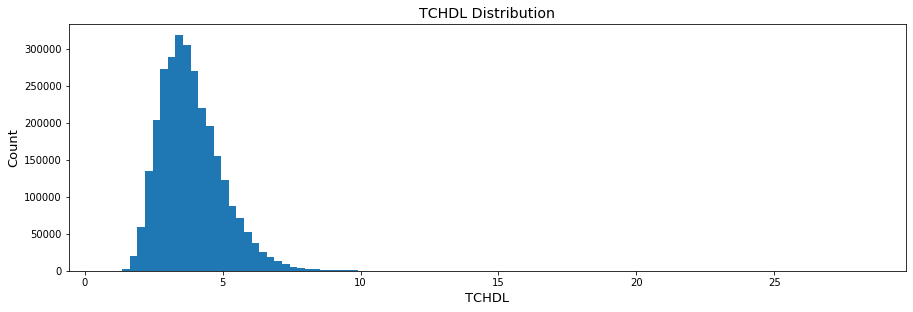

Max: 28.4
Min: 0.8


In [5]:
pyplot.figure(figsize=(15,10))
pyplot.subplot(211)
fs = 13
pyplot.title('TCHDL Distribution', fontsize=fs*1.1)
pyplot.xlabel('TCHDL', fontsize=fs)
pyplot.ylabel('Count', fontsize=fs)
pyplot.hist(view_1hot_df.TCHDL, bins=100)
#filename = "/home/whsu014/plots/TCHDL_Distribution.png"
#pyplot.savefig(filename)
pyplot.show()

print("Max:", max(view_1hot_df.TCHDL))
print("Min:", min(view_1hot_df.TCHDL))

In [6]:
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set to length 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0


In [7]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 

In [8]:
print(scaled_train.shape)
print(view_1hot_df.columns.get_loc('TCHDL'))
print(list(view_1hot_df.columns))

(2520000, 182)
14
['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'TESTED', 'DIED', 'LL_SIMVASTATIN', 'LL_BEZAFIBRATE', 'LL_ATORVASTATIN', 'LL_EZETIMIBE', 'LL_NICOTINIC_ACID', 'LL_ACIPIMOX', 'LL_CHOLESTYRAMINE', 'LL_COLESTIPOL_HYDROCHLORIDE', 'LL_PRAVASTATIN', 'LL_EZETIMIBE_WITH_SIMVASTATIN', 'LL_GEMFIBROZIL', 'LL_PDC', 'CVD_FELODIPINE', 'CVD_QUINAPRIL', 'CVD_METOPROLOL_SUCCINATE', 'CVD_CILAZAPRIL', 'CVD_ATENOLOL', 'CVD_BENDROFLUMETHIAZIDE', 'CVD_WARFARIN_SODIUM', 'CVD_FUROSEMIDE', 'CVD_CELIPROLOL', 'CVD_DILTIAZEM_HYDROCHLORIDE', 'CVD_ASPIRIN', 'CVD_NIFEDIPINE', 'CVD_CAPTOPRIL', 'CVD_DIPYRIDAMOLE', 'CVD_CANDESARTAN_CILEXETIL', 'CVD_INDAPAMIDE', 'CVD_ENALAPRIL_MALEATE', 'CVD_SOTALOL', 'CVD_GLYCERYL_TRINITRATE', 'CVD_ISOSORBIDE_MONONITRATE', 'CVD_PINDOLOL', 'CVD_CARVEDILOL', 'CVD_METHYLDOPA', 'CVD_LOSARTAN_POTASSIUM', 'CVD_VERAPAMIL_HYDROCHLORIDE', 'CVD_AMILORIDE_HYDROCHLORIDE', 'CVD_CLONIDINE_

In [9]:
###################################
# CuDNNLSTM and SimpleRNN
###################################

print(scaled_train.base is view_1hot_df)
print(scaled_train.shape)

num_of_inds = scaled_train.shape[0]//28
print("Number of individuals: ", num_of_inds)

x_train_list = []
y_train_list = []

start_time = time.time()
for i in range(num_of_inds): #num_of_inds[]
    ind_train = copy.deepcopy(scaled_train[(i*28):((i+1)*28), :])
    ind_train_x = copy.deepcopy(ind_train[0:8, :]) #8
    #z_pad = np.zeros((12, 184)) #changed from 12 to 20 timesteps
    ##############################
    #instead zero padding
    #extrapolate
    #z_pad = np.array([ind_train[7, :]]*12)
    #z_pad = np.array([ind_train[0, :]]*12)
    ##############################
    #ind_train_x = np.append(ind_train_x, z_pad, axis=0)
    x_train_list.append(ind_train_x)
    ##################################################
    # Training just on TCHDL
    ##################################################
    y_train_list.append(np.array([ind_train[8:, 14]]).T) #8:, -1
    #ground_truth[(i*28):((i+1)*28), :] = copy.deepcopy(ind_train)
    #ind_test = np.copy(scaled_test[(i*28):((i+1)*28), :])
    #ind_test_x = np.copy(ind_test[0:8, :]) #8
    #z_pad = np.zeros((12, 183)) #changed from 12 to 20 timesteps
    ##############################
    #instead zero padding
    #extrapolate
    #z_pad = np.array([ind_test[7, :]]*12)
    #z_pad = np.array([ind_test[0, :]]*12)
    ##############################
    #ind_test_x = np.append(ind_test_x, z_pad, axis=0)
    #x_test_list.append(ind_test_x)
    
    #naive[(i*28):((i+1)*28),:] = copy.deepcopy(ind_test)    
    if i % 1000 == 0:
        print("Iteration: ", str(i))
        print(time.time() - start_time)
print("Time to build train test data: ", time.time() - start_time)
x_train = np.array(x_train_list)
y_train = np.array(y_train_list)
#x_test = np.array(x_test_list)
#ground_truth = np.array(ground_truth_list)
#naive = np.array(naive_list)
#y_test = np.array(y_test_list)
print(x_train.shape)
print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)
#print(ground_truth.shape)
#print(naive.shape)

False
(2520000, 182)
Number of individuals:  90000
Iteration:  0
0.0003933906555175781
Iteration:  1000
0.016483545303344727
Iteration:  2000
0.03213214874267578
Iteration:  3000
0.04726552963256836
Iteration:  4000
0.06262612342834473
Iteration:  5000
0.07989358901977539
Iteration:  6000
0.09713578224182129
Iteration:  7000
0.11423921585083008
Iteration:  8000
0.13138937950134277
Iteration:  9000
0.14866352081298828
Iteration:  10000
0.1658616065979004
Iteration:  11000
0.18313217163085938
Iteration:  12000
0.20107746124267578
Iteration:  13000
0.2182331085205078
Iteration:  14000
0.23537445068359375
Iteration:  15000
0.252382755279541
Iteration:  16000
0.26980090141296387
Iteration:  17000
0.28691864013671875
Iteration:  18000
0.30391955375671387
Iteration:  19000
0.32115817070007324
Iteration:  20000
0.3380258083343506
Iteration:  21000
0.3550834655761719
Iteration:  22000
0.37234950065612793
Iteration:  23000
0.38939809799194336
Iteration:  24000
0.40682363510131836
Iteration:  250

In [10]:
num_per_fold = x_train.shape[0]//10
print(num_per_fold)

9000


9000
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 0.6690 - val_loss: 0.5210

Epoch 00001: val_loss improved from inf to 0.52100, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.4926 - val_loss: 0.4750

Epoch 00002: val_loss improved from 0.52100 to 0.47502, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.4676 - val_loss: 0.4615

Epoch 00003: val_loss improved from 0.47502 to 0.46155, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.4575 - val_loss: 0.4546

Epoch 00004: val_loss improved from 0.46155 to 0.45455, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.4519 - val_loss: 0.4500

Epoch 00005: val_loss improved from 0.45455 to 0.45001, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4482 - val_loss: 0.4475

Epoch 00006: val_loss improved from 0.45001 to 0.44755, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4456 - val_loss: 0.4458

Epoch 00007: val_loss improved from 0.

 - 1s - loss: 0.4261 - val_loss: 0.4341

Epoch 00066: val_loss did not improve from 0.43336
Epoch 67/100
 - 1s - loss: 0.4261 - val_loss: 0.4349

Epoch 00067: val_loss did not improve from 0.43336
Epoch 68/100
 - 1s - loss: 0.4261 - val_loss: 0.4345

Epoch 00068: val_loss did not improve from 0.43336
Epoch 69/100
 - 1s - loss: 0.4261 - val_loss: 0.4340

Epoch 00069: val_loss did not improve from 0.43336
Epoch 70/100
 - 1s - loss: 0.4262 - val_loss: 0.4347

Epoch 00070: val_loss did not improve from 0.43336
Epoch 71/100
 - 1s - loss: 0.4258 - val_loss: 0.4340

Epoch 00071: val_loss did not improve from 0.43336
Epoch 72/100
 - 1s - loss: 0.4257 - val_loss: 0.4346

Epoch 00072: val_loss did not improve from 0.43336
Epoch 73/100
 - 1s - loss: 0.4259 - val_loss: 0.4345

Epoch 00073: val_loss did not improve from 0.43336
Epoch 74/100
 - 1s - loss: 0.4256 - val_loss: 0.4339

Epoch 00074: val_loss did not improve from 0.43336
Epoch 75/100
 - 1s - loss: 0.4260 - val_loss: 0.4344

Epoch 00075: v

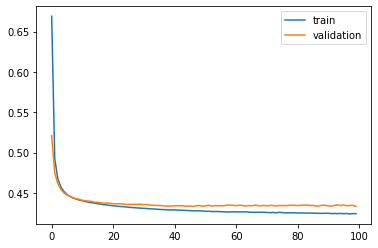

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 0.6522 - val_loss: 0.5208

Epoch 00001: val_loss improved from inf to 0.52077, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.4961 - val_loss: 0.4760

Epoch 00002: val_loss improved from 0.52077 to 0.47596, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.4688 - val_loss: 0.4606

Epoch 00003: val_loss improved from 0.47596 to 0.46058, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.4577 - val_loss: 0.4538

Epoch 00004: val_loss improved from 0.46058 to 0.45377, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.4518 - val_loss: 0.4494

Epoch 00005: val_loss improved from 0.45377 to 0.44935, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4478 - val_loss: 0.4464

Epoch 00006: val_loss improved from 0.44935 to 0.44644, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4451 - val_loss: 0.4441

Epoch 00007: val_loss improved from 0.44644

 - 1s - loss: 0.4262 - val_loss: 0.4355

Epoch 00068: val_loss did not improve from 0.43494
Epoch 69/100
 - 1s - loss: 0.4259 - val_loss: 0.4353

Epoch 00069: val_loss did not improve from 0.43494
Epoch 70/100
 - 1s - loss: 0.4254 - val_loss: 0.4354

Epoch 00070: val_loss did not improve from 0.43494
Epoch 71/100
 - 1s - loss: 0.4259 - val_loss: 0.4349

Epoch 00071: val_loss improved from 0.43494 to 0.43488, saving model to val_weights2.hdf5
Epoch 72/100
 - 1s - loss: 0.4257 - val_loss: 0.4354

Epoch 00072: val_loss did not improve from 0.43488
Epoch 73/100
 - 1s - loss: 0.4260 - val_loss: 0.4353

Epoch 00073: val_loss did not improve from 0.43488
Epoch 74/100
 - 1s - loss: 0.4260 - val_loss: 0.4355

Epoch 00074: val_loss did not improve from 0.43488
Epoch 75/100
 - 1s - loss: 0.4254 - val_loss: 0.4350

Epoch 00075: val_loss did not improve from 0.43488
Epoch 76/100
 - 1s - loss: 0.4254 - val_loss: 0.4349

Epoch 00076: val_loss did not improve from 0.43488
Epoch 77/100
 - 1s - loss: 0.

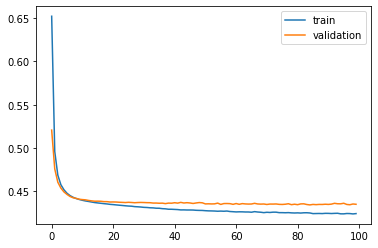

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 0.6460 - val_loss: 0.5189

Epoch 00001: val_loss improved from inf to 0.51890, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.4896 - val_loss: 0.4768

Epoch 00002: val_loss improved from 0.51890 to 0.47680, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.4643 - val_loss: 0.4629

Epoch 00003: val_loss improved from 0.47680 to 0.46288, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.4547 - val_loss: 0.4571

Epoch 00004: val_loss improved from 0.46288 to 0.45715, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.4500 - val_loss: 0.4539

Epoch 00005: val_loss improved from 0.45715 to 0.45391, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4470 - val_loss: 0.4515

Epoch 00006: val_loss improved from 0.45391 to 0.45147, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4449 - val_loss: 0.4502

Epoch 00007: val_loss improved from 0.45147

 - 1s - loss: 0.4262 - val_loss: 0.4401

Epoch 00063: val_loss did not improve from 0.43972
Epoch 64/100
 - 1s - loss: 0.4261 - val_loss: 0.4399

Epoch 00064: val_loss did not improve from 0.43972
Epoch 65/100
 - 1s - loss: 0.4261 - val_loss: 0.4400

Epoch 00065: val_loss did not improve from 0.43972
Epoch 66/100
 - 1s - loss: 0.4258 - val_loss: 0.4400

Epoch 00066: val_loss did not improve from 0.43972
Epoch 67/100
 - 1s - loss: 0.4257 - val_loss: 0.4396

Epoch 00067: val_loss improved from 0.43972 to 0.43964, saving model to val_weights3.hdf5
Epoch 68/100
 - 1s - loss: 0.4260 - val_loss: 0.4399

Epoch 00068: val_loss did not improve from 0.43964
Epoch 69/100
 - 1s - loss: 0.4258 - val_loss: 0.4401

Epoch 00069: val_loss did not improve from 0.43964
Epoch 70/100
 - 1s - loss: 0.4256 - val_loss: 0.4398

Epoch 00070: val_loss did not improve from 0.43964
Epoch 71/100
 - 1s - loss: 0.4253 - val_loss: 0.4398

Epoch 00071: val_loss did not improve from 0.43964
Epoch 72/100
 - 1s - loss: 0.

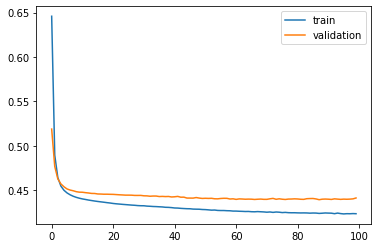

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f295c19f7f0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 0.6603 - val_loss: 0.5144

Epoch 00001: val_loss improved from inf to 0.51445, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.4932 - val_loss: 0.4692

Epoch 00002: val_loss improved from 0.51445 to 0.46916, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.4664 - val_loss: 0.4547

Epoch 00003: val_loss improved from 0.46916 to 0.45466, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.4559 - val_loss: 0.4482

Epoch 00004: val_loss improved from 0.45466 to 0.44818, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.4502 - val_loss: 0.4447

Epoch 00005: val_loss improved from 0.44818 to 0.44470, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4468 - val_loss: 0.4422

Epoch 00006: val_loss improved from 0.44470 to 0.44219, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4443 - val_loss: 0.4408

Epoch 00007: val_loss improved from 0.44219


Epoch 00067: val_loss did not improve from 0.43289
Epoch 68/100
 - 1s - loss: 0.4253 - val_loss: 0.4331

Epoch 00068: val_loss did not improve from 0.43289
Epoch 69/100
 - 1s - loss: 0.4252 - val_loss: 0.4336

Epoch 00069: val_loss did not improve from 0.43289
Epoch 70/100
 - 1s - loss: 0.4252 - val_loss: 0.4336

Epoch 00070: val_loss did not improve from 0.43289
Epoch 71/100
 - 1s - loss: 0.4248 - val_loss: 0.4333

Epoch 00071: val_loss did not improve from 0.43289
Epoch 72/100
 - 1s - loss: 0.4252 - val_loss: 0.4336

Epoch 00072: val_loss did not improve from 0.43289
Epoch 73/100
 - 1s - loss: 0.4247 - val_loss: 0.4334

Epoch 00073: val_loss did not improve from 0.43289
Epoch 74/100
 - 1s - loss: 0.4251 - val_loss: 0.4324

Epoch 00074: val_loss improved from 0.43289 to 0.43239, saving model to val_weights4.hdf5
Epoch 75/100
 - 1s - loss: 0.4247 - val_loss: 0.4331

Epoch 00075: val_loss did not improve from 0.43239
Epoch 76/100
 - 1s - loss: 0.4246 - val_loss: 0.4340

Epoch 00076: va

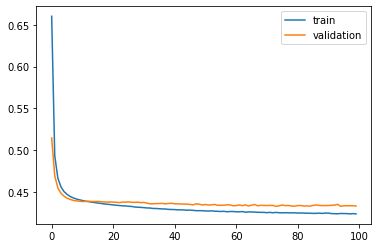

Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 0.6560 - val_loss: 0.5226

Epoch 00001: val_loss improved from inf to 0.52263, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.4947 - val_loss: 0.4776

Epoch 00002: val_loss improved from 0.52263 to 0.47755, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.4673 - val_loss: 0.4635

Epoch 00003: val_loss improved from 0.47755 to 0.46352, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.4565 - val_loss: 0.4573

Epoch 00004: val_loss improved from 0.46352 to 0.45729, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.4505 - val_loss: 0.4535

Epoch 00005: val_loss improved from 0.45729 to 0.45348, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4468 - val_loss: 0.4506

Epoch 00006: val_loss improved from 0.45348 to 0.45061, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4442 - val_loss: 0.4489

Epoch 00007: val_loss improved from 0.45061

 - 1s - loss: 0.4257 - val_loss: 0.4393

Epoch 00066: val_loss did not improve from 0.43898
Epoch 67/100
 - 1s - loss: 0.4255 - val_loss: 0.4394

Epoch 00067: val_loss did not improve from 0.43898
Epoch 68/100
 - 1s - loss: 0.4256 - val_loss: 0.4397

Epoch 00068: val_loss did not improve from 0.43898
Epoch 69/100
 - 1s - loss: 0.4250 - val_loss: 0.4386

Epoch 00069: val_loss improved from 0.43898 to 0.43856, saving model to val_weights5.hdf5
Epoch 70/100
 - 1s - loss: 0.4251 - val_loss: 0.4392

Epoch 00070: val_loss did not improve from 0.43856
Epoch 71/100
 - 1s - loss: 0.4252 - val_loss: 0.4391

Epoch 00071: val_loss did not improve from 0.43856
Epoch 72/100
 - 1s - loss: 0.4253 - val_loss: 0.4387

Epoch 00072: val_loss did not improve from 0.43856
Epoch 73/100
 - 1s - loss: 0.4249 - val_loss: 0.4386

Epoch 00073: val_loss did not improve from 0.43856
Epoch 74/100
 - 1s - loss: 0.4248 - val_loss: 0.4389

Epoch 00074: val_loss did not improve from 0.43856
Epoch 75/100
 - 1s - loss: 0.

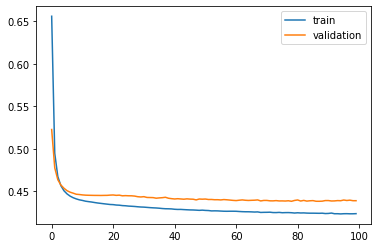

Time to train LSTM:  147.6394557952881
Entire process took:  726.4394164085388
Experiment record:
[[16, 512, 0, 0.4333624108367496], [16, 512, 1, 0.4343771222697364], [16, 512, 2, 0.4393650966750251], [16, 512, 3, 0.4323898213704427], [16, 512, 4, 0.4381372983985477]]


In [22]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units_list = [16] #[32, 64] #[2, 4, 8, 16, 32]#[4, 8]#[32, 64, 128, 256] # [16, 32, 64, 128, 256] [4, 8]#
batch_size_list = [512]# [1024, 2048, 4096, 8192]# [4096, 8192]#[2048] #[64, 128, 256, 512, 1024]# [512, 1024]# [1024] # [64, 128, 256, 512, 1024]

start_time = time.time()

exp_record = []

for units in units_list:
    for batch_s in batch_size_list:
        for f in range(5):#10
            #start = f*num_per_fold
            end = (f+1)*num_per_fold
            train1_x = x_train[:end, ]
            train2_x = x_train[end:, ]
            train_x_lstm = np.append(train2_x, train1_x, axis=0) #new obj
            train1_y = y_train[:end, ]
            train2_y = y_train[end:, ]
            train_y_lstm = np.append(train2_y, train1_y, axis=0)

            start_time_inner = time.time()
            #config = tf.ConfigProto(log_device_placement = True)
            #config.gpu_options.visible_device_list='1'
            with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
                model = Sequential()
                model.add(CuDNNLSTM(units, #CuDNNLSTM
                                    kernel_regularizer=regularizers.l2(0.01),
                                    #dropout=0.5, #recurrent_dropout=0.5,
                                    #recurrent_regularizer=regularizers.l2(0.01),
                                    #bias_regularizer=regularizers.l2(0.01),
                                    #activity_regularizer=regularizers.l2(0.01),
                                    #return_sequences=True, 
                                    input_shape=(8, 182))) #20 , 27
                model.add(RepeatVector(20))
                model.add(CuDNNLSTM(units, 
                                    #kernel_regularizer=regularizers.l2(1e-6),
                                    return_sequences=True))
                model.add(TimeDistributed(Dense(1)))
                #model.add(Dense(1))
                #adam = optimizers.Adam(lr=0.0015) #decay=1e-4
                #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-7) 
                model.compile(loss='mae', optimizer='adam')#'adam'
                #weight = "weightsCuDNNLSTMPDC" + str(f+1) + ".hdf5" #"Test"+str(f+1)+".hdf5" 
                train_weight = "train_weights" + str(f+1) + ".hdf5"
                val_weight = "val_weights" + str(f+1) + ".hdf5"
                #train_checkpointer = ModelCheckpoint(filepath=train_weight,
                #                            monitor='loss', verbose=1,
                #                            save_best_only=True)
                val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
                history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                                    epochs=100, validation_split=0.1, 
                                    callbacks=[val_checkpointer], 
                                    verbose=2, 
                                    shuffle=False) 
                print("#################################")
                print("Number of units:", units)
                print("Batch size:", batch_s)
                print("Fold:", f)
                print("best val loss:", min(history.history['val_loss']))
                exp_record.append([units, batch_s, f, min(history.history['val_loss'])])
                print("#################################")
                if(f==4):
                    print(exp_record)
                pyplot.plot(history.history['loss'], label='train')
                pyplot.plot(history.history['val_loss'], label='validation')
                pyplot.legend()
                pyplot.show()
    end_time = time.time()
    print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [11]:
exp_record = [[16, 512, 0, 0.4350551462438371], [16, 512, 1, 0.43474338022867837], [16, 512, 2, 0.4404511207739512], [16, 512, 3, 0.4333895516925388], [16, 512, 4, 0.4389758901860979], [16, 512, 0, 0.4344315363566081], [16, 512, 1, 0.43451421059502493], [16, 512, 2, 0.4398775424692366], [16, 512, 3, 0.4338124470975664], [16, 512, 4, 0.4366424799760183], [16, 512, 0, 0.4325419854587979], [16, 512, 1, 0.4360417475435469], [16, 512, 2, 0.44194589206907486], [16, 512, 3, 0.43535155958599514], [16, 512, 4, 0.43750676078266565], [16, 512, 0, 0.43349929144647387], [16, 512, 1, 0.4341993330849542], [16, 512, 2, 0.4401734705236223], [16, 512, 3, 0.4321923662556542], [16, 512, 4, 0.437993773010042], [16, 512, 0, 0.4328704081641303], [16, 512, 1, 0.4354187105761634], [16, 512, 2, 0.44070384889178804], [16, 512, 3, 0.43202898528840805], [16, 512, 4, 0.43600691032409666], [16, 512, 0, 0.4334958676232232], [16, 512, 1, 0.4344417900509304], [16, 512, 2, 0.4403160875108507], [16, 512, 3, 0.4322848067018721], [16, 512, 4, 0.43491947746276854], [16, 512, 0, 0.43243014142248365], [16, 512, 1, 0.4353958645661672], [16, 512, 2, 0.4391321777237786], [16, 512, 3, 0.4324299308458964], [16, 512, 4, 0.4384291270573934], [16, 512, 0, 0.43283882276217145], [16, 512, 1, 0.4325374876393212], [16, 512, 2, 0.4384850461483002], [16, 512, 3, 0.43188436489635046], [16, 512, 4, 0.43664561327298484], [16, 512, 0, 0.43136333110597397], [16, 512, 1, 0.4336786542203691], [16, 512, 2, 0.43785787375768026], [16, 512, 3, 0.4303162037266625], [16, 512, 4, 0.43501672172546385], [16, 512, 0, 0.43208330620659724], [16, 512, 1, 0.43102050624953375], [16, 512, 2, 0.4381223063733843], [16, 512, 3, 0.431602219608095], [16, 512, 4, 0.4345264368057251], [16, 512, 0, 0.4312801745732625], [16, 512, 1, 0.4348516686492496], [16, 512, 2, 0.43832475537723964], [16, 512, 3, 0.43210862045817905], [16, 512, 4, 0.43467236510912577], [16, 512, 0, 0.4312482013967302], [16, 512, 1, 0.4331749376455943], [16, 512, 2, 0.43822879897223577], [16, 512, 3, 0.43092502673467], [16, 512, 4, 0.4364958811601003], [16, 512, 0, 0.4329143573443095], [16, 512, 1, 0.4344928305943807], [16, 512, 2, 0.43879785601298016], [16, 512, 3, 0.4338542101913028], [16, 512, 4, 0.4375094917615255], [16, 512, 0, 0.4320273357762231], [16, 512, 1, 0.433087144613266], [16, 512, 2, 0.43837659793429906], [16, 512, 3, 0.42951837452252706], [16, 512, 4, 0.43453967187139725], [16, 512, 0, 0.4315477267106374], [16, 512, 1, 0.43341324909528095], [16, 512, 2, 0.4381144377125634], [16, 512, 3, 0.43063004435433283], [16, 512, 4, 0.4351514553229014], [16, 512, 0, 0.43213928339216445], [16, 512, 1, 0.43396654031011794], [16, 512, 2, 0.4379345570405324], [16, 512, 3, 0.4322992239528232], [16, 512, 4, 0.435081837521659], [16, 512, 0, 0.4302238917880588], [16, 512, 1, 0.43083575593100654], [16, 512, 2, 0.437662692838245], [16, 512, 3, 0.42979905811945596], [16, 512, 4, 0.4352493704424964], [16, 512, 0, 0.4294488502343496], [16, 512, 1, 0.43167176802953083], [16, 512, 2, 0.4375809104442596], [16, 512, 3, 0.43139523490269976], [16, 512, 4, 0.4338317383395301], [16, 512, 0, 0.4350057112640805], [16, 512, 1, 0.43606570347150164], [16, 512, 2, 0.4420445711877611], [16, 512, 3, 0.43420865472157794], [16, 512, 4, 0.439760324716568], [16, 512, 0, 0.4318123586177826], [16, 512, 1, 0.4325127352078756], [16, 512, 2, 0.4408653530544705], [16, 512, 3, 0.43189129919475977], [16, 512, 4, 0.43681525042321945], [16, 512, 0, 0.4320236026975844], [16, 512, 1, 0.43417886935340033], [16, 512, 2, 0.43978310476409066], [16, 512, 3, 0.4327602663040161], [16, 512, 4, 0.4354184965822432], [16, 512, 0, 0.431446894036399], [16, 512, 1, 0.433419856707255], [16, 512, 2, 0.4382007599671682], [16, 512, 3, 0.43174807307455276], [16, 512, 4, 0.4373624995019701], [16, 512, 0, 0.4307393908235762], [16, 512, 1, 0.4327530149353875], [16, 512, 2, 0.43972124507692123], [16, 512, 3, 0.4314941351148817], [16, 512, 4, 0.43662549363242253], [16, 512, 0, 0.4316587953567505], [16, 512, 1, 0.43223516991403366], [16, 512, 2, 0.43950667696528967], [16, 512, 3, 0.43106105091836716], [16, 512, 4, 0.4371338419914246], [16, 512, 0, 0.4364922677675883], [16, 512, 1, 0.4385794024467468], [16, 512, 2, 0.4453554453584883], [16, 512, 3, 0.4360550480948554], [16, 512, 4, 0.4407018284532759], [16, 512, 0, 0.4344573038419088], [16, 512, 1, 0.4365992444091373], [16, 512, 2, 0.4426360325548384], [16, 512, 3, 0.43485970091819764], [16, 512, 4, 0.4407508127689362], [16, 512, 0, 0.4357217559814453], [16, 512, 1, 0.4363554527759552], [16, 512, 2, 0.4425682479805417], [16, 512, 3, 0.4332049188613892], [16, 512, 4, 0.4422407053576575], [16, 512, 0, 0.43422267452875773], [16, 512, 1, 0.4363209609190623], [16, 512, 2, 0.444603362666236], [16, 512, 3, 0.4319161358409458], [16, 512, 4, 0.43871187347835966], [16, 512, 0, 0.434035870525572], [16, 512, 1, 0.4366390668551127], [16, 512, 2, 0.4436675448152754], [16, 512, 3, 0.4331337535381317], [16, 512, 4, 0.4411143362522125], [16, 512, 0, 0.4342808267540402], [16, 512, 1, 0.4364978257285224], [16, 512, 2, 0.4426169227229224], [16, 512, 3, 0.434269199848175], [16, 512, 4, 0.4389158812628852]]
complete_v = np.array(exp_record)
print(complete_v.shape)
print(exp_record)

val_loss_list = []
for i in range(30):
    model_v = complete_v[(i*5):((i+1)*5), :]
    print("#######################")
    print("Units:", model_v[0, 0])
    print("Batch size:", model_v[0, 1])
    print("Val loss (mean):", np.mean(model_v[:, 3]))
    print("Val loss (Std):", np.std(model_v[:, 3]))
    #print("Val loss (mean):", np.round(np.mean(model_v[:, 3]), decimals=5))
    #print("Val loss (Std):", np.round(np.std(model_v[:, 3]), decimals=5))
    print("#######################")
    val_loss_list.append(np.mean(model_v[:, 3]))
print(min(val_loss_list))

(150, 4)
[[16, 512, 0, 0.4350551462438371], [16, 512, 1, 0.43474338022867837], [16, 512, 2, 0.4404511207739512], [16, 512, 3, 0.4333895516925388], [16, 512, 4, 0.4389758901860979], [16, 512, 0, 0.4344315363566081], [16, 512, 1, 0.43451421059502493], [16, 512, 2, 0.4398775424692366], [16, 512, 3, 0.4338124470975664], [16, 512, 4, 0.4366424799760183], [16, 512, 0, 0.4325419854587979], [16, 512, 1, 0.4360417475435469], [16, 512, 2, 0.44194589206907486], [16, 512, 3, 0.43535155958599514], [16, 512, 4, 0.43750676078266565], [16, 512, 0, 0.43349929144647387], [16, 512, 1, 0.4341993330849542], [16, 512, 2, 0.4401734705236223], [16, 512, 3, 0.4321923662556542], [16, 512, 4, 0.437993773010042], [16, 512, 0, 0.4328704081641303], [16, 512, 1, 0.4354187105761634], [16, 512, 2, 0.44070384889178804], [16, 512, 3, 0.43202898528840805], [16, 512, 4, 0.43600691032409666], [16, 512, 0, 0.4334958676232232], [16, 512, 1, 0.4344417900509304], [16, 512, 2, 0.4403160875108507], [16, 512, 3, 0.432284806701872

In [12]:
units = 16
batch_size = 64
model = Sequential()
model.add(CuDNNLSTM(units, #CuDNNLSTM
                                    #######kernel_regularizer=regularizers.l2(0.01),
                                    #dropout=0.5, #recurrent_dropout=0.5,
                                    #recurrent_regularizer=regularizers.l2(0.01),
                                    #bias_regularizer=regularizers.l2(0.01),
                                    #activity_regularizer=regularizers.l2(0.01),
                                    #return_sequences=True, 
         input_shape=(8, 182))) #20 , 27
model.add(RepeatVector(20))
model.add(CuDNNLSTM(units, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 16)                12800     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 16)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 20, 16)            2176      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 1)             17        
Total params: 14,993
Trainable params: 14,993
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
###########################
# generate random numbers
# for layer 1 and 2 
# L2 search
###########################
from numpy.random import seed
seed(5) # seed 1 for LSTM seed 5 for SimpleRNN
# L2 for layer 1 between 0.005 and 0.015
L2_1_list = []
for i in range(25):
    L2_1_list.append(np.random.uniform(0.005, 0.015))
# L2 for layer 2 between 1e-4 and 1e-8
L2_2_list = []
for i in range(25):
    r = -4*np.random.rand()
    s = 0.0001*(10**r)
    L2_2_list.append(s)
print(min(L2_1_list))
print(max(L2_1_list))
print(min(L2_2_list))
print(max(L2_2_list))
print(L2_1_list)
print(L2_2_list)
#pyplot.hist(L2_1_list, bins=25)

0.005807412687648748
0.014186109079379214
1.1415695836643046e-08
9.849888381867553e-05
[0.0072199317108973945, 0.013707323061773764, 0.007067191553394264, 0.014186109079379214, 0.00988411188794829, 0.011117438629026456, 0.012659078564803155, 0.010184179878729431, 0.007968005015762218, 0.006877212286612516, 0.005807412687648748, 0.012384402961989699, 0.00941309222895953, 0.006583098677126512, 0.013799370312012789, 0.0077408646199222456, 0.009142350190810514, 0.007960799327336478, 0.011287879088794833, 0.01079837810189545, 0.010999291966249875, 0.007658191175355072, 0.007846858806413637, 0.007535882057737874, 0.00827563947688734]
[2.6505914783975005e-05, 2.175447240794305e-05, 1.394048500868052e-08, 1.4424246609572321e-08, 1.76336159394718e-05, 7.994176883795366e-05, 1.5197698149525386e-05, 1.5871776653550959e-07, 7.619766407841797e-08, 8.095946512357794e-05, 4.890447122292986e-07, 9.849888381867553e-05, 8.671805976616734e-07, 2.7594294531006584e-07, 1.1415695836643046e-08, 9.19622554919

9000
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 1.0146 - val_loss: 0.8139

Epoch 00001: val_loss improved from inf to 0.81393, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7258 - val_loss: 0.6499

Epoch 00002: val_loss improved from 0.81393 to 0.64993, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.6074 - val_loss: 0.5736

Epoch 00003: val_loss improved from 0.64993 to 0.57362, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5530 - val_loss: 0.5343

Epoch 00004: val_loss improved from 0.57362 to 0.53433, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5219 - val_loss: 0.5099

Epoch 00005: val_loss improved from 0.53433 to 0.50992, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.5023 - val_loss: 0.4938

Epoch 00006: val_loss improved from 0.50992 to 0.49384, saving

 - 1s - loss: 0.4381 - val_loss: 0.4407

Epoch 00056: val_loss did not improve from 0.44008
Epoch 57/100
 - 1s - loss: 0.4380 - val_loss: 0.4402

Epoch 00057: val_loss did not improve from 0.44008
Epoch 58/100
 - 1s - loss: 0.4378 - val_loss: 0.4404

Epoch 00058: val_loss did not improve from 0.44008
Epoch 59/100
 - 1s - loss: 0.4377 - val_loss: 0.4405

Epoch 00059: val_loss did not improve from 0.44008
Epoch 60/100
 - 1s - loss: 0.4377 - val_loss: 0.4403

Epoch 00060: val_loss did not improve from 0.44008
Epoch 61/100
 - 1s - loss: 0.4377 - val_loss: 0.4406

Epoch 00061: val_loss did not improve from 0.44008
Epoch 62/100
 - 1s - loss: 0.4377 - val_loss: 0.4405

Epoch 00062: val_loss did not improve from 0.44008
Epoch 63/100
 - 1s - loss: 0.4376 - val_loss: 0.4404

Epoch 00063: val_loss did not improve from 0.44008
Epoch 64/100
 - 1s - loss: 0.4375 - val_loss: 0.4405

Epoch 00064: val_loss did not improve from 0.44008
Epoch 65/100
 - 1s - loss: 0.4374 - val_loss: 0.4407

Epoch 00065: v

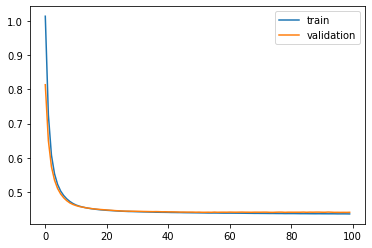

Time to train LSTM:  99.5637059211731
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 0.8856 - val_loss: 0.7205

Epoch 00001: val_loss improved from inf to 0.72050, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6509 - val_loss: 0.5953

Epoch 00002: val_loss improved from 0.72050 to 0.59532, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5682 - val_loss: 0.5409

Epoch 00003: val_loss improved from 0.59532 to 0.54091, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5261 - val_loss: 0.5096

Epoch 00004: val_loss improved from 0.54091 to 0.50959, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5015 - val_loss: 0.4907

Epoch 00005: val_loss improved from 0.50959 to 0.49069, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4862 - val_loss: 0.4782

Epoch 00006: val_loss improved from 0.49069 to 0.47816, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4756 - val_loss: 0.4694

Epoch 

 - 1s - loss: 0.4357 - val_loss: 0.4382

Epoch 00060: val_loss did not improve from 0.43815
Epoch 61/100
 - 1s - loss: 0.4357 - val_loss: 0.4382

Epoch 00061: val_loss did not improve from 0.43815
Epoch 62/100
 - 1s - loss: 0.4356 - val_loss: 0.4380

Epoch 00062: val_loss improved from 0.43815 to 0.43801, saving model to val_weights2.hdf5
Epoch 63/100
 - 1s - loss: 0.4353 - val_loss: 0.4384

Epoch 00063: val_loss did not improve from 0.43801
Epoch 64/100
 - 1s - loss: 0.4353 - val_loss: 0.4382

Epoch 00064: val_loss did not improve from 0.43801
Epoch 65/100
 - 1s - loss: 0.4350 - val_loss: 0.4381

Epoch 00065: val_loss did not improve from 0.43801
Epoch 66/100
 - 1s - loss: 0.4350 - val_loss: 0.4382

Epoch 00066: val_loss did not improve from 0.43801
Epoch 67/100
 - 1s - loss: 0.4349 - val_loss: 0.4384

Epoch 00067: val_loss did not improve from 0.43801
Epoch 68/100
 - 1s - loss: 0.4349 - val_loss: 0.4382

Epoch 00068: val_loss did not improve from 0.43801
Epoch 69/100
 - 1s - loss: 0.

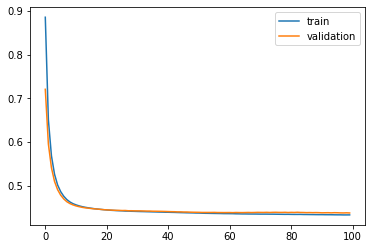

Time to train LSTM:  100.59858798980713


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f91a8114710>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 2s - loss: 0.9178 - val_loss: 0.7573

Epoch 00001: val_loss improved from inf to 0.75726, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6837 - val_loss: 0.6277

Epoch 00002: val_loss improved from 0.75726 to 0.62771, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5865 - val_loss: 0.5595

Epoch 00003: val_loss improved from 0.62771 to 0.55947, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5360 - val_loss: 0.5220

Epoch 00004: val_loss improved from 0.55947 to 0.52199, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5067 - val_loss: 0.4994

Epoch 00005: val_loss improved from 0.52199 to 0.49944, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4883 - val_loss: 0.4850

Epoch 00006: val_loss improved from 0.49944 to 0.48504, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4758 - val_loss: 0.4750

Epoch 00007: val_loss improved from 0.48504 

 - 1s - loss: 0.4361 - val_loss: 0.4459

Epoch 00062: val_loss improved from 0.44606 to 0.44588, saving model to val_weights3.hdf5
Epoch 63/100
 - 1s - loss: 0.4361 - val_loss: 0.4464

Epoch 00063: val_loss did not improve from 0.44588
Epoch 64/100
 - 1s - loss: 0.4359 - val_loss: 0.4462

Epoch 00064: val_loss did not improve from 0.44588
Epoch 65/100
 - 1s - loss: 0.4358 - val_loss: 0.4462

Epoch 00065: val_loss did not improve from 0.44588
Epoch 66/100
 - 1s - loss: 0.4359 - val_loss: 0.4461

Epoch 00066: val_loss did not improve from 0.44588
Epoch 67/100
 - 1s - loss: 0.4359 - val_loss: 0.4462

Epoch 00067: val_loss did not improve from 0.44588
Epoch 68/100
 - 1s - loss: 0.4357 - val_loss: 0.4461

Epoch 00068: val_loss did not improve from 0.44588
Epoch 69/100
 - 1s - loss: 0.4356 - val_loss: 0.4463

Epoch 00069: val_loss did not improve from 0.44588
Epoch 70/100
 - 1s - loss: 0.4356 - val_loss: 0.4463

Epoch 00070: val_loss did not improve from 0.44588
Epoch 71/100
 - 1s - loss: 0.

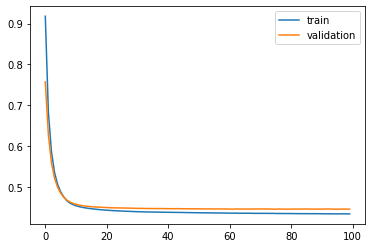

Time to train LSTM:  103.18960857391357


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f921474b518>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 3s - loss: 0.8907 - val_loss: 0.7269

Epoch 00001: val_loss improved from inf to 0.72692, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.6549 - val_loss: 0.5911

Epoch 00002: val_loss improved from 0.72692 to 0.59107, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5657 - val_loss: 0.5340

Epoch 00003: val_loss improved from 0.59107 to 0.53405, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5230 - val_loss: 0.5026

Epoch 00004: val_loss improved from 0.53405 to 0.50259, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.4980 - val_loss: 0.4832

Epoch 00005: val_loss improved from 0.50259 to 0.48317, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4821 - val_loss: 0.4706

Epoch 00006: val_loss improved from 0.48317 to 0.47065, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4719 - val_loss: 0.4623

Epoch 00007: val_loss improved from 0.47065 

 - 1s - loss: 0.4359 - val_loss: 0.4387

Epoch 00064: val_loss did not improve from 0.43830
Epoch 65/100
 - 1s - loss: 0.4358 - val_loss: 0.4388

Epoch 00065: val_loss did not improve from 0.43830
Epoch 66/100
 - 1s - loss: 0.4358 - val_loss: 0.4389

Epoch 00066: val_loss did not improve from 0.43830
Epoch 67/100
 - 1s - loss: 0.4357 - val_loss: 0.4387

Epoch 00067: val_loss did not improve from 0.43830
Epoch 68/100
 - 1s - loss: 0.4356 - val_loss: 0.4390

Epoch 00068: val_loss did not improve from 0.43830
Epoch 69/100
 - 1s - loss: 0.4356 - val_loss: 0.4388

Epoch 00069: val_loss did not improve from 0.43830
Epoch 70/100
 - 1s - loss: 0.4355 - val_loss: 0.4389

Epoch 00070: val_loss did not improve from 0.43830
Epoch 71/100
 - 1s - loss: 0.4355 - val_loss: 0.4390

Epoch 00071: val_loss did not improve from 0.43830
Epoch 72/100
 - 1s - loss: 0.4355 - val_loss: 0.4389

Epoch 00072: val_loss did not improve from 0.43830
Epoch 73/100
 - 1s - loss: 0.4355 - val_loss: 0.4391

Epoch 00073: v

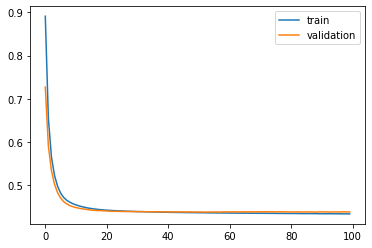

Time to train LSTM:  100.73518061637878
Train on 81000 samples, validate on 9000 samples
Epoch 1/100


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f91680aa3c8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


 - 6s - loss: 0.9111 - val_loss: 0.7849

Epoch 00001: val_loss improved from inf to 0.78487, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7069 - val_loss: 0.6409

Epoch 00002: val_loss improved from 0.78487 to 0.64088, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5973 - val_loss: 0.5666

Epoch 00003: val_loss improved from 0.64088 to 0.56661, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5422 - val_loss: 0.5283

Epoch 00004: val_loss improved from 0.56661 to 0.52828, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5114 - val_loss: 0.5046

Epoch 00005: val_loss improved from 0.52828 to 0.50461, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4921 - val_loss: 0.4889

Epoch 00006: val_loss improved from 0.50461 to 0.48887, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4791 - val_loss: 0.4779

Epoch 00007: val_loss improved from 0.48887 to 0.47793, saving model to val_weights5.hdf5
Epoch 8/100
 - 


Epoch 00063: val_loss did not improve from 0.44427
Epoch 64/100
 - 1s - loss: 0.4352 - val_loss: 0.4442

Epoch 00064: val_loss improved from 0.44427 to 0.44423, saving model to val_weights5.hdf5
Epoch 65/100
 - 1s - loss: 0.4351 - val_loss: 0.4442

Epoch 00065: val_loss improved from 0.44423 to 0.44422, saving model to val_weights5.hdf5
Epoch 66/100
 - 1s - loss: 0.4349 - val_loss: 0.4443

Epoch 00066: val_loss did not improve from 0.44422
Epoch 67/100
 - 1s - loss: 0.4350 - val_loss: 0.4443

Epoch 00067: val_loss did not improve from 0.44422
Epoch 68/100
 - 1s - loss: 0.4349 - val_loss: 0.4442

Epoch 00068: val_loss improved from 0.44422 to 0.44417, saving model to val_weights5.hdf5
Epoch 69/100
 - 1s - loss: 0.4348 - val_loss: 0.4439

Epoch 00069: val_loss improved from 0.44417 to 0.44392, saving model to val_weights5.hdf5
Epoch 70/100
 - 1s - loss: 0.4349 - val_loss: 0.4439

Epoch 00070: val_loss did not improve from 0.44392
Epoch 71/100
 - 1s - loss: 0.4347 - val_loss: 0.4443

Epo

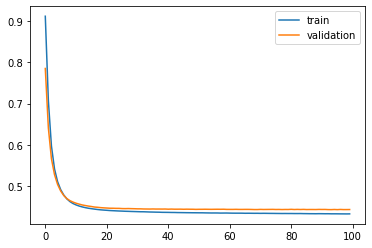

Time to train LSTM:  104.13988590240479
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 1.2995 - val_loss: 0.9501

Epoch 00001: val_loss improved from inf to 0.95013, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.8361 - val_loss: 0.7406

Epoch 00002: val_loss improved from 0.95013 to 0.74062, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.6802 - val_loss: 0.6319

Epoch 00003: val_loss improved from 0.74062 to 0.63187, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5963 - val_loss: 0.5688

Epoch 00004: val_loss improved from 0.63187 to 0.56879, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5471 - val_loss: 0.5303

Epoch 00005: val_loss improved from 0.56879 to 0.53031, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.5167 - val_loss: 0.5054

Epoch 00006: val_loss improved from 0.53031 to 0.50544, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4970 - val_loss: 0.4891

Epoc


Epoch 00060: val_loss did not improve from 0.44149
Epoch 61/100
 - 1s - loss: 0.4388 - val_loss: 0.4414

Epoch 00061: val_loss improved from 0.44149 to 0.44136, saving model to val_weights1.hdf5
Epoch 62/100
 - 1s - loss: 0.4388 - val_loss: 0.4415

Epoch 00062: val_loss did not improve from 0.44136
Epoch 63/100
 - 1s - loss: 0.4386 - val_loss: 0.4414

Epoch 00063: val_loss did not improve from 0.44136
Epoch 64/100
 - 1s - loss: 0.4388 - val_loss: 0.4413

Epoch 00064: val_loss improved from 0.44136 to 0.44129, saving model to val_weights1.hdf5
Epoch 65/100
 - 1s - loss: 0.4384 - val_loss: 0.4410

Epoch 00065: val_loss improved from 0.44129 to 0.44095, saving model to val_weights1.hdf5
Epoch 66/100
 - 1s - loss: 0.4384 - val_loss: 0.4409

Epoch 00066: val_loss improved from 0.44095 to 0.44091, saving model to val_weights1.hdf5
Epoch 67/100
 - 1s - loss: 0.4382 - val_loss: 0.4408

Epoch 00067: val_loss improved from 0.44091 to 0.44081, saving model to val_weights1.hdf5
Epoch 68/100
 - 1s

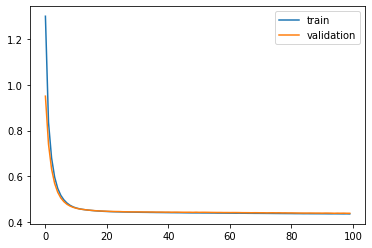

Time to train LSTM:  102.59167242050171


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f90402b0780>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 1.1437 - val_loss: 0.9056

Epoch 00001: val_loss improved from inf to 0.90558, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.8002 - val_loss: 0.7099

Epoch 00002: val_loss improved from 0.90558 to 0.70993, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.6529 - val_loss: 0.6055

Epoch 00003: val_loss improved from 0.70993 to 0.60551, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5724 - val_loss: 0.5448

Epoch 00004: val_loss improved from 0.60551 to 0.54484, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5262 - val_loss: 0.5090

Epoch 00005: val_loss improved from 0.54484 to 0.50896, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4985 - val_loss: 0.4871

Epoch 00006: val_loss improved from 0.50896 to 0.48707, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4814 - val_loss: 0.4734

Epoch 00007: val_loss improved from 0.48707 

 - 1s - loss: 0.4395 - val_loss: 0.4421

Epoch 00065: val_loss did not improve from 0.44165
Epoch 66/100
 - 1s - loss: 0.4392 - val_loss: 0.4421

Epoch 00066: val_loss did not improve from 0.44165
Epoch 67/100
 - 1s - loss: 0.4392 - val_loss: 0.4420

Epoch 00067: val_loss did not improve from 0.44165
Epoch 68/100
 - 1s - loss: 0.4390 - val_loss: 0.4422

Epoch 00068: val_loss did not improve from 0.44165
Epoch 69/100
 - 1s - loss: 0.4389 - val_loss: 0.4424

Epoch 00069: val_loss did not improve from 0.44165
Epoch 70/100
 - 1s - loss: 0.4389 - val_loss: 0.4419

Epoch 00070: val_loss did not improve from 0.44165
Epoch 71/100
 - 1s - loss: 0.4389 - val_loss: 0.4421

Epoch 00071: val_loss did not improve from 0.44165
Epoch 72/100
 - 1s - loss: 0.4388 - val_loss: 0.4424

Epoch 00072: val_loss did not improve from 0.44165
Epoch 73/100
 - 1s - loss: 0.4387 - val_loss: 0.4425

Epoch 00073: val_loss did not improve from 0.44165
Epoch 74/100
 - 1s - loss: 0.4388 - val_loss: 0.4425

Epoch 00074: v

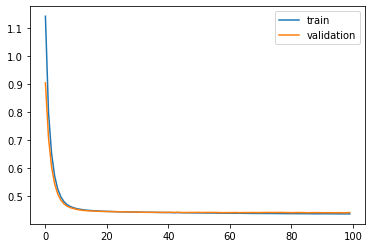

Time to train LSTM:  102.78096604347229
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 4s - loss: 1.0213 - val_loss: 0.8499

Epoch 00001: val_loss improved from inf to 0.84990, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7502 - val_loss: 0.6666

Epoch 00002: val_loss improved from 0.84990 to 0.66661, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.6102 - val_loss: 0.5712

Epoch 00003: val_loss improved from 0.66661 to 0.57120, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5393 - val_loss: 0.5217

Epoch 00004: val_loss improved from 0.57120 to 0.52170, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5010 - val_loss: 0.4933

Epoch 00005: val_loss improved from 0.52170 to 0.49332, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4788 - val_loss: 0.4768

Epoch 00006: val_loss improved from 0.49332 to 0.47681, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4663 - val_loss: 0.4673

Epoc


Epoch 00063: val_loss did not improve from 0.44548
Epoch 64/100
 - 1s - loss: 0.4371 - val_loss: 0.4456

Epoch 00064: val_loss did not improve from 0.44548
Epoch 65/100
 - 1s - loss: 0.4370 - val_loss: 0.4458

Epoch 00065: val_loss did not improve from 0.44548
Epoch 66/100
 - 1s - loss: 0.4370 - val_loss: 0.4455

Epoch 00066: val_loss did not improve from 0.44548
Epoch 67/100
 - 1s - loss: 0.4369 - val_loss: 0.4457

Epoch 00067: val_loss did not improve from 0.44548
Epoch 68/100
 - 1s - loss: 0.4369 - val_loss: 0.4455

Epoch 00068: val_loss improved from 0.44548 to 0.44548, saving model to val_weights3.hdf5
Epoch 69/100
 - 1s - loss: 0.4369 - val_loss: 0.4456

Epoch 00069: val_loss did not improve from 0.44548
Epoch 70/100
 - 1s - loss: 0.4369 - val_loss: 0.4454

Epoch 00070: val_loss improved from 0.44548 to 0.44539, saving model to val_weights3.hdf5
Epoch 71/100
 - 1s - loss: 0.4368 - val_loss: 0.4454

Epoch 00071: val_loss improved from 0.44539 to 0.44536, saving model to val_weigh

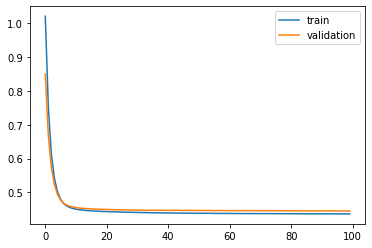

Time to train LSTM:  91.42537713050842
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 1.0869 - val_loss: 0.8608

Epoch 00001: val_loss improved from inf to 0.86081, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7653 - val_loss: 0.6812

Epoch 00002: val_loss improved from 0.86081 to 0.68116, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6334 - val_loss: 0.5862

Epoch 00003: val_loss improved from 0.68116 to 0.58620, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5615 - val_loss: 0.5316

Epoch 00004: val_loss improved from 0.58620 to 0.53157, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5200 - val_loss: 0.4986

Epoch 00005: val_loss improved from 0.53157 to 0.49856, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4944 - val_loss: 0.4780

Epoch 00006: val_loss improved from 0.49856 to 0.47796, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4779 - val_loss: 0.4657

Epoch

 - 1s - loss: 0.4374 - val_loss: 0.4383

Epoch 00062: val_loss did not improve from 0.43810
Epoch 63/100
 - 1s - loss: 0.4372 - val_loss: 0.4381

Epoch 00063: val_loss improved from 0.43810 to 0.43806, saving model to val_weights4.hdf5
Epoch 64/100
 - 1s - loss: 0.4372 - val_loss: 0.4382

Epoch 00064: val_loss did not improve from 0.43806
Epoch 65/100
 - 1s - loss: 0.4370 - val_loss: 0.4381

Epoch 00065: val_loss did not improve from 0.43806
Epoch 66/100
 - 1s - loss: 0.4370 - val_loss: 0.4380

Epoch 00066: val_loss improved from 0.43806 to 0.43799, saving model to val_weights4.hdf5
Epoch 67/100
 - 1s - loss: 0.4369 - val_loss: 0.4380

Epoch 00067: val_loss did not improve from 0.43799
Epoch 68/100
 - 1s - loss: 0.4369 - val_loss: 0.4384

Epoch 00068: val_loss did not improve from 0.43799
Epoch 69/100
 - 1s - loss: 0.4369 - val_loss: 0.4379

Epoch 00069: val_loss improved from 0.43799 to 0.43787, saving model to val_weights4.hdf5
Epoch 70/100
 - 1s - loss: 0.4367 - val_loss: 0.4381

Ep

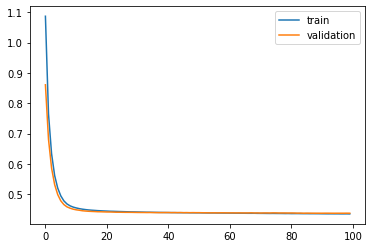

Time to train LSTM:  103.98683667182922


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f903a7f4240>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 1.0716 - val_loss: 0.8652

Epoch 00001: val_loss improved from inf to 0.86524, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7608 - val_loss: 0.6675

Epoch 00002: val_loss improved from 0.86524 to 0.66745, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6143 - val_loss: 0.5720

Epoch 00003: val_loss improved from 0.66745 to 0.57201, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5425 - val_loss: 0.5219

Epoch 00004: val_loss improved from 0.57201 to 0.52194, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5041 - val_loss: 0.4938

Epoch 00005: val_loss improved from 0.52194 to 0.49378, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4820 - val_loss: 0.4776

Epoch 00006: val_loss improved from 0.49378 to 0.47762, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4690 - val_loss: 0.4682

Epoch 00007: val_loss improved from 0.47762 

 - 1s - loss: 0.4374 - val_loss: 0.4465

Epoch 00067: val_loss did not improve from 0.44568
Epoch 68/100
 - 1s - loss: 0.4376 - val_loss: 0.4465

Epoch 00068: val_loss did not improve from 0.44568
Epoch 69/100
 - 1s - loss: 0.4374 - val_loss: 0.4466

Epoch 00069: val_loss did not improve from 0.44568
Epoch 70/100
 - 1s - loss: 0.4374 - val_loss: 0.4464

Epoch 00070: val_loss did not improve from 0.44568
Epoch 71/100
 - 1s - loss: 0.4373 - val_loss: 0.4466

Epoch 00071: val_loss did not improve from 0.44568
Epoch 72/100
 - 1s - loss: 0.4372 - val_loss: 0.4465

Epoch 00072: val_loss did not improve from 0.44568
Epoch 73/100
 - 1s - loss: 0.4373 - val_loss: 0.4463

Epoch 00073: val_loss did not improve from 0.44568
Epoch 74/100
 - 1s - loss: 0.4371 - val_loss: 0.4469

Epoch 00074: val_loss did not improve from 0.44568
Epoch 75/100
 - 1s - loss: 0.4372 - val_loss: 0.4465

Epoch 00075: val_loss did not improve from 0.44568
Epoch 76/100
 - 1s - loss: 0.4372 - val_loss: 0.4467

Epoch 00076: v

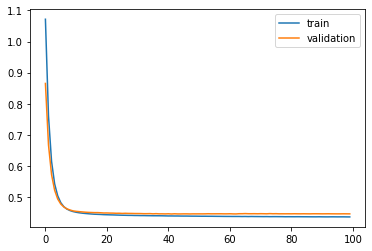

Time to train LSTM:  92.1272702217102
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 0.8677 - val_loss: 0.7415

Epoch 00001: val_loss improved from inf to 0.74153, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6493 - val_loss: 0.5827

Epoch 00002: val_loss improved from 0.74153 to 0.58269, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5526 - val_loss: 0.5272

Epoch 00003: val_loss improved from 0.58269 to 0.52715, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5120 - val_loss: 0.4976

Epoch 00004: val_loss improved from 0.52715 to 0.49762, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.4895 - val_loss: 0.4801

Epoch 00005: val_loss improved from 0.49762 to 0.48013, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4756 - val_loss: 0.4691

Epoch 00006: val_loss improved from 0.48013 to 0.46911, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4666 - val_loss: 0.4622

Epoch 

 - 1s - loss: 0.4360 - val_loss: 0.4394

Epoch 00063: val_loss did not improve from 0.43915
Epoch 64/100
 - 1s - loss: 0.4359 - val_loss: 0.4391

Epoch 00064: val_loss improved from 0.43915 to 0.43907, saving model to val_weights1.hdf5
Epoch 65/100
 - 1s - loss: 0.4358 - val_loss: 0.4390

Epoch 00065: val_loss improved from 0.43907 to 0.43897, saving model to val_weights1.hdf5
Epoch 66/100
 - 1s - loss: 0.4356 - val_loss: 0.4390

Epoch 00066: val_loss improved from 0.43897 to 0.43897, saving model to val_weights1.hdf5
Epoch 67/100
 - 1s - loss: 0.4355 - val_loss: 0.4388

Epoch 00067: val_loss improved from 0.43897 to 0.43881, saving model to val_weights1.hdf5
Epoch 68/100
 - 1s - loss: 0.4354 - val_loss: 0.4385

Epoch 00068: val_loss improved from 0.43881 to 0.43854, saving model to val_weights1.hdf5
Epoch 69/100
 - 1s - loss: 0.4353 - val_loss: 0.4386

Epoch 00069: val_loss did not improve from 0.43854
Epoch 70/100
 - 1s - loss: 0.4352 - val_loss: 0.4384

Epoch 00070: val_loss improve

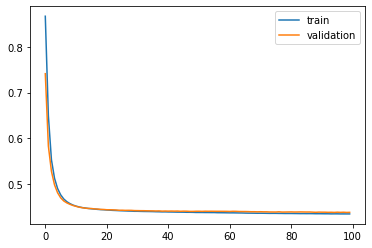

Time to train LSTM:  92.96035027503967
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 5s - loss: 0.8389 - val_loss: 0.7075

Epoch 00001: val_loss improved from inf to 0.70754, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6404 - val_loss: 0.5878

Epoch 00002: val_loss improved from 0.70754 to 0.58785, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5599 - val_loss: 0.5340

Epoch 00003: val_loss improved from 0.58785 to 0.53395, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5187 - val_loss: 0.5026

Epoch 00004: val_loss improved from 0.53395 to 0.50264, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.4935 - val_loss: 0.4832

Epoch 00005: val_loss improved from 0.50264 to 0.48318, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4772 - val_loss: 0.4711

Epoch 00006: val_loss improved from 0.48318 to 0.47108, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4672 - val_loss: 0.4635

Epoch

 - 1s - loss: 0.4349 - val_loss: 0.4384

Epoch 00062: val_loss did not improve from 0.43839
Epoch 63/100
 - 1s - loss: 0.4346 - val_loss: 0.4385

Epoch 00063: val_loss did not improve from 0.43839
Epoch 64/100
 - 1s - loss: 0.4345 - val_loss: 0.4386

Epoch 00064: val_loss did not improve from 0.43839
Epoch 65/100
 - 1s - loss: 0.4343 - val_loss: 0.4385

Epoch 00065: val_loss did not improve from 0.43839
Epoch 66/100
 - 1s - loss: 0.4340 - val_loss: 0.4380

Epoch 00066: val_loss improved from 0.43839 to 0.43803, saving model to val_weights2.hdf5
Epoch 67/100
 - 1s - loss: 0.4339 - val_loss: 0.4379

Epoch 00067: val_loss improved from 0.43803 to 0.43787, saving model to val_weights2.hdf5
Epoch 68/100
 - 1s - loss: 0.4338 - val_loss: 0.4379

Epoch 00068: val_loss improved from 0.43787 to 0.43786, saving model to val_weights2.hdf5
Epoch 69/100
 - 1s - loss: 0.4339 - val_loss: 0.4385

Epoch 00069: val_loss did not improve from 0.43786
Epoch 70/100
 - 1s - loss: 0.4338 - val_loss: 0.4380

Ep

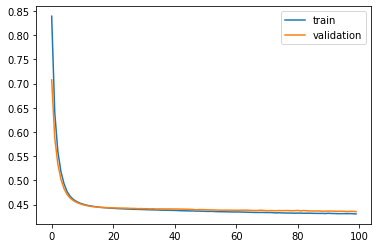

Time to train LSTM:  104.82687401771545


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f8ef0374240>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 6s - loss: 0.9821 - val_loss: 0.7783

Epoch 00001: val_loss improved from inf to 0.77834, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7091 - val_loss: 0.6529

Epoch 00002: val_loss improved from 0.77834 to 0.65291, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.6142 - val_loss: 0.5850

Epoch 00003: val_loss improved from 0.65291 to 0.58502, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5605 - val_loss: 0.5456

Epoch 00004: val_loss improved from 0.58502 to 0.54557, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5279 - val_loss: 0.5206

Epoch 00005: val_loss improved from 0.54557 to 0.52059, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.5067 - val_loss: 0.5039

Epoch 00006: val_loss improved from 0.52059 to 0.50385, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4923 - val_loss: 0.4921

Epoch 00007: val_loss improved from 0.50385 

 - 1s - loss: 0.4365 - val_loss: 0.4449

Epoch 00061: val_loss improved from 0.44492 to 0.44491, saving model to val_weights3.hdf5
Epoch 62/100
 - 1s - loss: 0.4363 - val_loss: 0.4446

Epoch 00062: val_loss improved from 0.44491 to 0.44463, saving model to val_weights3.hdf5
Epoch 63/100
 - 1s - loss: 0.4362 - val_loss: 0.4443

Epoch 00063: val_loss improved from 0.44463 to 0.44433, saving model to val_weights3.hdf5
Epoch 64/100
 - 1s - loss: 0.4361 - val_loss: 0.4443

Epoch 00064: val_loss improved from 0.44433 to 0.44433, saving model to val_weights3.hdf5
Epoch 65/100
 - 1s - loss: 0.4360 - val_loss: 0.4446

Epoch 00065: val_loss did not improve from 0.44433
Epoch 66/100
 - 1s - loss: 0.4359 - val_loss: 0.4443

Epoch 00066: val_loss improved from 0.44433 to 0.44431, saving model to val_weights3.hdf5
Epoch 67/100
 - 1s - loss: 0.4358 - val_loss: 0.4442

Epoch 00067: val_loss improved from 0.44431 to 0.44423, saving model to val_weights3.hdf5
Epoch 68/100
 - 1s - loss: 0.4356 - val_loss

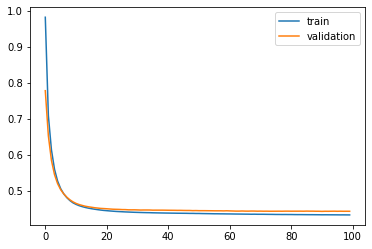

Time to train LSTM:  94.22493720054626
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 1.0111 - val_loss: 0.7981

Epoch 00001: val_loss improved from inf to 0.79809, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7232 - val_loss: 0.6487

Epoch 00002: val_loss improved from 0.79809 to 0.64868, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6117 - val_loss: 0.5725

Epoch 00003: val_loss improved from 0.64868 to 0.57249, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5536 - val_loss: 0.5299

Epoch 00004: val_loss improved from 0.57249 to 0.52987, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5208 - val_loss: 0.5044

Epoch 00005: val_loss improved from 0.52987 to 0.50437, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.5008 - val_loss: 0.4879

Epoch 00006: val_loss improved from 0.50437 to 0.48789, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4875 - val_loss: 0.4765

Epoch

 - 1s - loss: 0.4371 - val_loss: 0.4375

Epoch 00063: val_loss did not improve from 0.43750
Epoch 64/100
 - 1s - loss: 0.4370 - val_loss: 0.4375

Epoch 00064: val_loss did not improve from 0.43750
Epoch 65/100
 - 1s - loss: 0.4370 - val_loss: 0.4376

Epoch 00065: val_loss did not improve from 0.43750
Epoch 66/100
 - 1s - loss: 0.4369 - val_loss: 0.4376

Epoch 00066: val_loss did not improve from 0.43750
Epoch 67/100
 - 1s - loss: 0.4369 - val_loss: 0.4377

Epoch 00067: val_loss did not improve from 0.43750
Epoch 68/100
 - 1s - loss: 0.4369 - val_loss: 0.4376

Epoch 00068: val_loss did not improve from 0.43750
Epoch 69/100
 - 1s - loss: 0.4368 - val_loss: 0.4374

Epoch 00069: val_loss improved from 0.43750 to 0.43744, saving model to val_weights4.hdf5
Epoch 70/100
 - 1s - loss: 0.4367 - val_loss: 0.4376

Epoch 00070: val_loss did not improve from 0.43744
Epoch 71/100
 - 1s - loss: 0.4366 - val_loss: 0.4374

Epoch 00071: val_loss improved from 0.43744 to 0.43740, saving model to val_weig

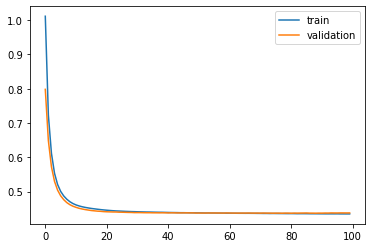

Time to train LSTM:  96.62274289131165
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 0.8949 - val_loss: 0.7372

Epoch 00001: val_loss improved from inf to 0.73721, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6745 - val_loss: 0.6210

Epoch 00002: val_loss improved from 0.73721 to 0.62101, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5879 - val_loss: 0.5613

Epoch 00003: val_loss improved from 0.62101 to 0.56135, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5412 - val_loss: 0.5268

Epoch 00004: val_loss improved from 0.56135 to 0.52677, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5129 - val_loss: 0.5045

Epoch 00005: val_loss improved from 0.52677 to 0.50451, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4943 - val_loss: 0.4896

Epoch 00006: val_loss improved from 0.50451 to 0.48962, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4813 - val_loss: 0.4800

Epoch


Epoch 00060: val_loss did not improve from 0.44223
Epoch 61/100
 - 1s - loss: 0.4349 - val_loss: 0.4426

Epoch 00061: val_loss did not improve from 0.44223
Epoch 62/100
 - 1s - loss: 0.4348 - val_loss: 0.4426

Epoch 00062: val_loss did not improve from 0.44223
Epoch 63/100
 - 1s - loss: 0.4348 - val_loss: 0.4425

Epoch 00063: val_loss did not improve from 0.44223
Epoch 64/100
 - 1s - loss: 0.4346 - val_loss: 0.4423

Epoch 00064: val_loss did not improve from 0.44223
Epoch 65/100
 - 1s - loss: 0.4344 - val_loss: 0.4422

Epoch 00065: val_loss improved from 0.44223 to 0.44216, saving model to val_weights5.hdf5
Epoch 66/100
 - 1s - loss: 0.4342 - val_loss: 0.4425

Epoch 00066: val_loss did not improve from 0.44216
Epoch 67/100
 - 1s - loss: 0.4342 - val_loss: 0.4426

Epoch 00067: val_loss did not improve from 0.44216
Epoch 68/100
 - 1s - loss: 0.4342 - val_loss: 0.4423

Epoch 00068: val_loss did not improve from 0.44216
Epoch 69/100
 - 1s - loss: 0.4341 - val_loss: 0.4424

Epoch 00069: va

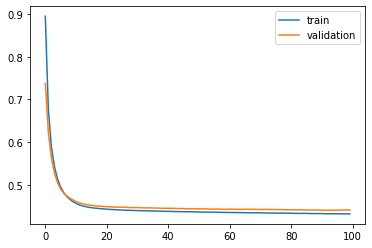

Time to train LSTM:  109.29848670959473


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f8ec20e8470>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 7s - loss: 1.1079 - val_loss: 0.8936

Epoch 00001: val_loss improved from inf to 0.89357, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7716 - val_loss: 0.6679

Epoch 00002: val_loss improved from 0.89357 to 0.66789, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.6168 - val_loss: 0.5708

Epoch 00003: val_loss improved from 0.66789 to 0.57081, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5448 - val_loss: 0.5204

Epoch 00004: val_loss improved from 0.57081 to 0.52042, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5069 - val_loss: 0.4923

Epoch 00005: val_loss improved from 0.52042 to 0.49232, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4856 - val_loss: 0.4766

Epoch 00006: val_loss improved from 0.49232 to 0.47664, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4731 - val_loss: 0.4673

Epoch 00007: val_loss improved from 0.47664 


Epoch 00061: val_loss improved from 0.44179 to 0.44168, saving model to val_weights1.hdf5
Epoch 62/100
 - 1s - loss: 0.4392 - val_loss: 0.4414

Epoch 00062: val_loss improved from 0.44168 to 0.44137, saving model to val_weights1.hdf5
Epoch 63/100
 - 1s - loss: 0.4390 - val_loss: 0.4414

Epoch 00063: val_loss did not improve from 0.44137
Epoch 64/100
 - 1s - loss: 0.4391 - val_loss: 0.4417

Epoch 00064: val_loss did not improve from 0.44137
Epoch 65/100
 - 1s - loss: 0.4391 - val_loss: 0.4411

Epoch 00065: val_loss improved from 0.44137 to 0.44115, saving model to val_weights1.hdf5
Epoch 66/100
 - 1s - loss: 0.4389 - val_loss: 0.4410

Epoch 00066: val_loss improved from 0.44115 to 0.44105, saving model to val_weights1.hdf5
Epoch 67/100
 - 1s - loss: 0.4389 - val_loss: 0.4411

Epoch 00067: val_loss did not improve from 0.44105
Epoch 68/100
 - 1s - loss: 0.4387 - val_loss: 0.4411

Epoch 00068: val_loss did not improve from 0.44105
Epoch 69/100
 - 1s - loss: 0.4386 - val_loss: 0.4412

Epo

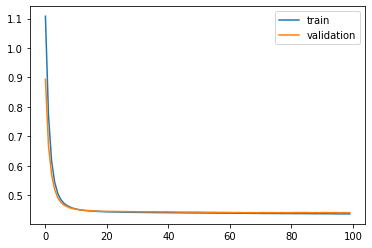

Time to train LSTM:  109.16925072669983
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 8s - loss: 1.0740 - val_loss: 0.8508

Epoch 00001: val_loss improved from inf to 0.85077, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7491 - val_loss: 0.6614

Epoch 00002: val_loss improved from 0.85077 to 0.66140, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.6141 - val_loss: 0.5691

Epoch 00003: val_loss improved from 0.66140 to 0.56915, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5447 - val_loss: 0.5190

Epoch 00004: val_loss improved from 0.56915 to 0.51903, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5068 - val_loss: 0.4915

Epoch 00005: val_loss improved from 0.51903 to 0.49145, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4849 - val_loss: 0.4748

Epoch 00006: val_loss improved from 0.49145 to 0.47478, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4713 - val_loss: 0.4645

Epoc

 - 1s - loss: 0.4379 - val_loss: 0.4399

Epoch 00063: val_loss improved from 0.43995 to 0.43993, saving model to val_weights2.hdf5
Epoch 64/100
 - 1s - loss: 0.4378 - val_loss: 0.4402

Epoch 00064: val_loss did not improve from 0.43993
Epoch 65/100
 - 1s - loss: 0.4377 - val_loss: 0.4403

Epoch 00065: val_loss did not improve from 0.43993
Epoch 66/100
 - 1s - loss: 0.4377 - val_loss: 0.4403

Epoch 00066: val_loss did not improve from 0.43993
Epoch 67/100
 - 1s - loss: 0.4376 - val_loss: 0.4400

Epoch 00067: val_loss did not improve from 0.43993
Epoch 68/100
 - 1s - loss: 0.4376 - val_loss: 0.4397

Epoch 00068: val_loss improved from 0.43993 to 0.43972, saving model to val_weights2.hdf5
Epoch 69/100
 - 1s - loss: 0.4374 - val_loss: 0.4397

Epoch 00069: val_loss improved from 0.43972 to 0.43971, saving model to val_weights2.hdf5
Epoch 70/100
 - 1s - loss: 0.4373 - val_loss: 0.4401

Epoch 00070: val_loss did not improve from 0.43971
Epoch 71/100
 - 1s - loss: 0.4372 - val_loss: 0.4400

Ep

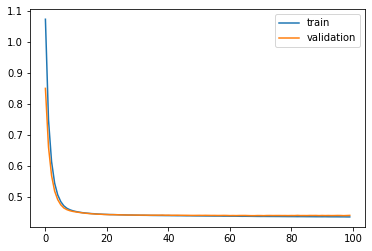

Time to train LSTM:  98.1346492767334
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 9s - loss: 1.1110 - val_loss: 0.8780

Epoch 00001: val_loss improved from inf to 0.87804, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7752 - val_loss: 0.6925

Epoch 00002: val_loss improved from 0.87804 to 0.69250, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.6357 - val_loss: 0.5925

Epoch 00003: val_loss improved from 0.69250 to 0.59253, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5601 - val_loss: 0.5382

Epoch 00004: val_loss improved from 0.59253 to 0.53822, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5179 - val_loss: 0.5069

Epoch 00005: val_loss improved from 0.53822 to 0.50687, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4930 - val_loss: 0.4879

Epoch 00006: val_loss improved from 0.50687 to 0.48788, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4774 - val_loss: 0.4752

Epoch 

 - 1s - loss: 0.4391 - val_loss: 0.4466

Epoch 00064: val_loss did not improve from 0.44596
Epoch 65/100
 - 1s - loss: 0.4391 - val_loss: 0.4462

Epoch 00065: val_loss did not improve from 0.44596
Epoch 66/100
 - 1s - loss: 0.4388 - val_loss: 0.4461

Epoch 00066: val_loss did not improve from 0.44596
Epoch 67/100
 - 1s - loss: 0.4385 - val_loss: 0.4456

Epoch 00067: val_loss improved from 0.44596 to 0.44562, saving model to val_weights3.hdf5
Epoch 68/100
 - 1s - loss: 0.4385 - val_loss: 0.4458

Epoch 00068: val_loss did not improve from 0.44562
Epoch 69/100
 - 1s - loss: 0.4385 - val_loss: 0.4463

Epoch 00069: val_loss did not improve from 0.44562
Epoch 70/100
 - 1s - loss: 0.4386 - val_loss: 0.4465

Epoch 00070: val_loss did not improve from 0.44562
Epoch 71/100
 - 1s - loss: 0.4385 - val_loss: 0.4460

Epoch 00071: val_loss did not improve from 0.44562
Epoch 72/100
 - 1s - loss: 0.4384 - val_loss: 0.4457

Epoch 00072: val_loss did not improve from 0.44562
Epoch 73/100
 - 1s - loss: 0.

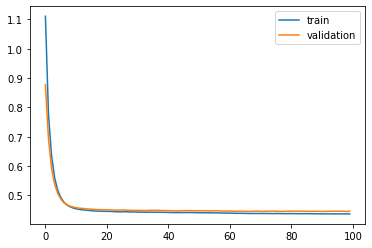

Time to train LSTM:  109.44988369941711
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 9s - loss: 1.0853 - val_loss: 0.8552

Epoch 00001: val_loss improved from inf to 0.85518, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7456 - val_loss: 0.6452

Epoch 00002: val_loss improved from 0.85518 to 0.64524, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6027 - val_loss: 0.5535

Epoch 00003: val_loss improved from 0.64524 to 0.55349, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5348 - val_loss: 0.5056

Epoch 00004: val_loss improved from 0.55349 to 0.50557, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.4986 - val_loss: 0.4802

Epoch 00005: val_loss improved from 0.50557 to 0.48017, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4788 - val_loss: 0.4662

Epoch 00006: val_loss improved from 0.48017 to 0.46625, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4678 - val_loss: 0.4586

Epoc

 - 1s - loss: 0.4377 - val_loss: 0.4384

Epoch 00065: val_loss did not improve from 0.43823
Epoch 66/100
 - 1s - loss: 0.4376 - val_loss: 0.4381

Epoch 00066: val_loss improved from 0.43823 to 0.43810, saving model to val_weights4.hdf5
Epoch 67/100
 - 1s - loss: 0.4375 - val_loss: 0.4383

Epoch 00067: val_loss did not improve from 0.43810
Epoch 68/100
 - 1s - loss: 0.4374 - val_loss: 0.4389

Epoch 00068: val_loss did not improve from 0.43810
Epoch 69/100
 - 1s - loss: 0.4375 - val_loss: 0.4384

Epoch 00069: val_loss did not improve from 0.43810
Epoch 70/100
 - 1s - loss: 0.4373 - val_loss: 0.4382

Epoch 00070: val_loss did not improve from 0.43810
Epoch 71/100
 - 1s - loss: 0.4373 - val_loss: 0.4383

Epoch 00071: val_loss did not improve from 0.43810
Epoch 72/100
 - 1s - loss: 0.4372 - val_loss: 0.4382

Epoch 00072: val_loss did not improve from 0.43810
Epoch 73/100
 - 1s - loss: 0.4371 - val_loss: 0.4382

Epoch 00073: val_loss did not improve from 0.43810
Epoch 74/100
 - 1s - loss: 0.

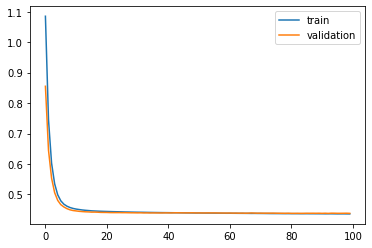

Time to train LSTM:  108.57531023025513
Train on 81000 samples, validate on 9000 samples
Epoch 1/100


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f8ec023d6d8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


 - 10s - loss: 1.0544 - val_loss: 0.8627

Epoch 00001: val_loss improved from inf to 0.86272, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7652 - val_loss: 0.6778

Epoch 00002: val_loss improved from 0.86272 to 0.67783, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6259 - val_loss: 0.5818

Epoch 00003: val_loss improved from 0.67783 to 0.58176, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5526 - val_loss: 0.5296

Epoch 00004: val_loss improved from 0.58176 to 0.52965, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5122 - val_loss: 0.5002

Epoch 00005: val_loss improved from 0.52965 to 0.50020, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4885 - val_loss: 0.4830

Epoch 00006: val_loss improved from 0.50020 to 0.48304, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4745 - val_loss: 0.4724

Epoch 00007: val_loss improved from 0.48304 to 0.47237, saving model to val_weights5.hdf5
Epoch 8/100
 -

 - 1s - loss: 0.4385 - val_loss: 0.4461

Epoch 00067: val_loss did not improve from 0.44594
Epoch 68/100
 - 1s - loss: 0.4385 - val_loss: 0.4460

Epoch 00068: val_loss did not improve from 0.44594
Epoch 69/100
 - 1s - loss: 0.4385 - val_loss: 0.4460

Epoch 00069: val_loss did not improve from 0.44594
Epoch 70/100
 - 1s - loss: 0.4384 - val_loss: 0.4460

Epoch 00070: val_loss did not improve from 0.44594
Epoch 71/100
 - 1s - loss: 0.4383 - val_loss: 0.4458

Epoch 00071: val_loss improved from 0.44594 to 0.44576, saving model to val_weights5.hdf5
Epoch 72/100
 - 1s - loss: 0.4383 - val_loss: 0.4460

Epoch 00072: val_loss did not improve from 0.44576
Epoch 73/100
 - 1s - loss: 0.4384 - val_loss: 0.4460

Epoch 00073: val_loss did not improve from 0.44576
Epoch 74/100
 - 1s - loss: 0.4382 - val_loss: 0.4459

Epoch 00074: val_loss did not improve from 0.44576
Epoch 75/100
 - 1s - loss: 0.4382 - val_loss: 0.4456

Epoch 00075: val_loss improved from 0.44576 to 0.44560, saving model to val_weig

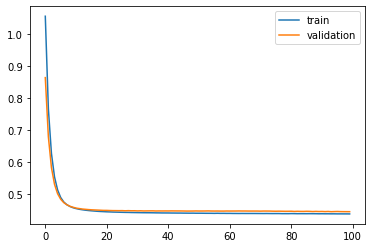

Time to train LSTM:  112.1061680316925
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 10s - loss: 0.9937 - val_loss: 0.8217

Epoch 00001: val_loss improved from inf to 0.82167, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7334 - val_loss: 0.6589

Epoch 00002: val_loss improved from 0.82167 to 0.65889, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.6140 - val_loss: 0.5764

Epoch 00003: val_loss improved from 0.65889 to 0.57643, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5521 - val_loss: 0.5308

Epoch 00004: val_loss improved from 0.57643 to 0.53084, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5164 - val_loss: 0.5033

Epoch 00005: val_loss improved from 0.53084 to 0.50329, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4942 - val_loss: 0.4852

Epoch 00006: val_loss improved from 0.50329 to 0.48516, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4790 - val_loss: 0.4725

Epoc

 - 1s - loss: 0.4376 - val_loss: 0.4417

Epoch 00062: val_loss did not improve from 0.44134
Epoch 63/100
 - 1s - loss: 0.4376 - val_loss: 0.4417

Epoch 00063: val_loss did not improve from 0.44134
Epoch 64/100
 - 1s - loss: 0.4375 - val_loss: 0.4418

Epoch 00064: val_loss did not improve from 0.44134
Epoch 65/100
 - 1s - loss: 0.4374 - val_loss: 0.4417

Epoch 00065: val_loss did not improve from 0.44134
Epoch 66/100
 - 1s - loss: 0.4374 - val_loss: 0.4417

Epoch 00066: val_loss did not improve from 0.44134
Epoch 67/100
 - 1s - loss: 0.4372 - val_loss: 0.4412

Epoch 00067: val_loss improved from 0.44134 to 0.44124, saving model to val_weights1.hdf5
Epoch 68/100
 - 1s - loss: 0.4372 - val_loss: 0.4418

Epoch 00068: val_loss did not improve from 0.44124
Epoch 69/100
 - 1s - loss: 0.4372 - val_loss: 0.4414

Epoch 00069: val_loss did not improve from 0.44124
Epoch 70/100
 - 1s - loss: 0.4370 - val_loss: 0.4416

Epoch 00070: val_loss did not improve from 0.44124
Epoch 71/100
 - 1s - loss: 0.

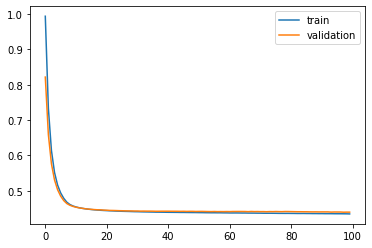

Time to train LSTM:  111.98085355758667
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 10s - loss: 0.9683 - val_loss: 0.8095

Epoch 00001: val_loss improved from inf to 0.80949, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7195 - val_loss: 0.6338

Epoch 00002: val_loss improved from 0.80949 to 0.63383, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5916 - val_loss: 0.5520

Epoch 00003: val_loss improved from 0.63383 to 0.55198, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5324 - val_loss: 0.5113

Epoch 00004: val_loss improved from 0.55198 to 0.51132, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5006 - val_loss: 0.4873

Epoch 00005: val_loss improved from 0.51132 to 0.48731, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4809 - val_loss: 0.4719

Epoch 00006: val_loss improved from 0.48731 to 0.47188, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4685 - val_loss: 0.4630

Epo


Epoch 00062: val_loss did not improve from 0.43831
Epoch 63/100
 - 1s - loss: 0.4365 - val_loss: 0.4386

Epoch 00063: val_loss did not improve from 0.43831
Epoch 64/100
 - 1s - loss: 0.4365 - val_loss: 0.4386

Epoch 00064: val_loss did not improve from 0.43831
Epoch 65/100
 - 1s - loss: 0.4364 - val_loss: 0.4383

Epoch 00065: val_loss improved from 0.43831 to 0.43829, saving model to val_weights2.hdf5
Epoch 66/100
 - 1s - loss: 0.4363 - val_loss: 0.4383

Epoch 00066: val_loss improved from 0.43829 to 0.43827, saving model to val_weights2.hdf5
Epoch 67/100
 - 1s - loss: 0.4363 - val_loss: 0.4382

Epoch 00067: val_loss improved from 0.43827 to 0.43820, saving model to val_weights2.hdf5
Epoch 68/100
 - 1s - loss: 0.4363 - val_loss: 0.4384

Epoch 00068: val_loss did not improve from 0.43820
Epoch 69/100
 - 1s - loss: 0.4361 - val_loss: 0.4385

Epoch 00069: val_loss did not improve from 0.43820
Epoch 70/100
 - 1s - loss: 0.4360 - val_loss: 0.4383

Epoch 00070: val_loss did not improve from

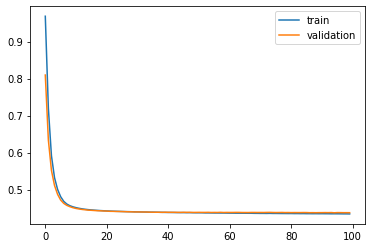

Time to train LSTM:  111.74703741073608
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 12s - loss: 0.9595 - val_loss: 0.7983

Epoch 00001: val_loss improved from inf to 0.79827, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7164 - val_loss: 0.6520

Epoch 00002: val_loss improved from 0.79827 to 0.65203, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.6065 - val_loss: 0.5746

Epoch 00003: val_loss improved from 0.65203 to 0.57462, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5478 - val_loss: 0.5313

Epoch 00004: val_loss improved from 0.57462 to 0.53132, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5135 - val_loss: 0.5052

Epoch 00005: val_loss improved from 0.53132 to 0.50520, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4923 - val_loss: 0.4881

Epoch 00006: val_loss improved from 0.50520 to 0.48813, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4782 - val_loss: 0.4765

Epo


Epoch 00062: val_loss did not improve from 0.44614
Epoch 63/100
 - 1s - loss: 0.4371 - val_loss: 0.4463

Epoch 00063: val_loss did not improve from 0.44614
Epoch 64/100
 - 1s - loss: 0.4369 - val_loss: 0.4463

Epoch 00064: val_loss did not improve from 0.44614
Epoch 65/100
 - 1s - loss: 0.4368 - val_loss: 0.4462

Epoch 00065: val_loss did not improve from 0.44614
Epoch 66/100
 - 1s - loss: 0.4369 - val_loss: 0.4463

Epoch 00066: val_loss did not improve from 0.44614
Epoch 67/100
 - 1s - loss: 0.4367 - val_loss: 0.4464

Epoch 00067: val_loss did not improve from 0.44614
Epoch 68/100
 - 1s - loss: 0.4366 - val_loss: 0.4459

Epoch 00068: val_loss improved from 0.44614 to 0.44588, saving model to val_weights3.hdf5
Epoch 69/100
 - 1s - loss: 0.4366 - val_loss: 0.4461

Epoch 00069: val_loss did not improve from 0.44588
Epoch 70/100
 - 1s - loss: 0.4365 - val_loss: 0.4461

Epoch 00070: val_loss did not improve from 0.44588
Epoch 71/100
 - 1s - loss: 0.4365 - val_loss: 0.4460

Epoch 00071: va

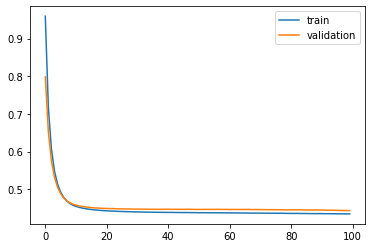

Time to train LSTM:  115.02369141578674
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 12s - loss: 0.9267 - val_loss: 0.7783

Epoch 00001: val_loss improved from inf to 0.77830, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7009 - val_loss: 0.6245

Epoch 00002: val_loss improved from 0.77830 to 0.62447, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5913 - val_loss: 0.5501

Epoch 00003: val_loss improved from 0.62447 to 0.55014, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5351 - val_loss: 0.5085

Epoch 00004: val_loss improved from 0.55014 to 0.50853, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5030 - val_loss: 0.4849

Epoch 00005: val_loss improved from 0.50853 to 0.48491, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4834 - val_loss: 0.4701

Epoch 00006: val_loss improved from 0.48491 to 0.47010, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4709 - val_loss: 0.4610

Epo

 - 1s - loss: 0.4377 - val_loss: 0.4388

Epoch 00063: val_loss did not improve from 0.43859
Epoch 64/100
 - 1s - loss: 0.4377 - val_loss: 0.4388

Epoch 00064: val_loss did not improve from 0.43859
Epoch 65/100
 - 1s - loss: 0.4376 - val_loss: 0.4387

Epoch 00065: val_loss did not improve from 0.43859
Epoch 66/100
 - 1s - loss: 0.4374 - val_loss: 0.4389

Epoch 00066: val_loss did not improve from 0.43859
Epoch 67/100
 - 1s - loss: 0.4373 - val_loss: 0.4389

Epoch 00067: val_loss did not improve from 0.43859
Epoch 68/100
 - 1s - loss: 0.4373 - val_loss: 0.4390

Epoch 00068: val_loss did not improve from 0.43859
Epoch 69/100
 - 1s - loss: 0.4373 - val_loss: 0.4391

Epoch 00069: val_loss did not improve from 0.43859
Epoch 70/100
 - 1s - loss: 0.4370 - val_loss: 0.4392

Epoch 00070: val_loss did not improve from 0.43859
Epoch 71/100
 - 1s - loss: 0.4370 - val_loss: 0.4391

Epoch 00071: val_loss did not improve from 0.43859
Epoch 72/100
 - 1s - loss: 0.4369 - val_loss: 0.4392

Epoch 00072: v

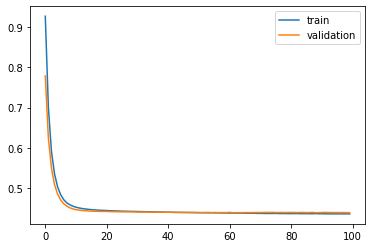

Time to train LSTM:  114.26929354667664
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 12s - loss: 1.0211 - val_loss: 0.8174

Epoch 00001: val_loss improved from inf to 0.81737, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7411 - val_loss: 0.6686

Epoch 00002: val_loss improved from 0.81737 to 0.66856, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6239 - val_loss: 0.5860

Epoch 00003: val_loss improved from 0.66856 to 0.58600, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5603 - val_loss: 0.5410

Epoch 00004: val_loss improved from 0.58600 to 0.54098, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5244 - val_loss: 0.5135

Epoch 00005: val_loss improved from 0.54098 to 0.51354, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.5016 - val_loss: 0.4959

Epoch 00006: val_loss improved from 0.51354 to 0.49588, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4863 - val_loss: 0.4839

Epo


Epoch 00063: val_loss improved from 0.44480 to 0.44448, saving model to val_weights5.hdf5
Epoch 64/100
 - 1s - loss: 0.4372 - val_loss: 0.4446

Epoch 00064: val_loss did not improve from 0.44448
Epoch 65/100
 - 1s - loss: 0.4372 - val_loss: 0.4446

Epoch 00065: val_loss did not improve from 0.44448
Epoch 66/100
 - 1s - loss: 0.4372 - val_loss: 0.4448

Epoch 00066: val_loss did not improve from 0.44448
Epoch 67/100
 - 1s - loss: 0.4371 - val_loss: 0.4446

Epoch 00067: val_loss did not improve from 0.44448
Epoch 68/100
 - 1s - loss: 0.4371 - val_loss: 0.4448

Epoch 00068: val_loss did not improve from 0.44448
Epoch 69/100
 - 1s - loss: 0.4369 - val_loss: 0.4445

Epoch 00069: val_loss did not improve from 0.44448
Epoch 70/100
 - 1s - loss: 0.4368 - val_loss: 0.4446

Epoch 00070: val_loss did not improve from 0.44448
Epoch 71/100
 - 1s - loss: 0.4367 - val_loss: 0.4443

Epoch 00071: val_loss improved from 0.44448 to 0.44434, saving model to val_weights5.hdf5
Epoch 72/100
 - 1s - loss: 0.4

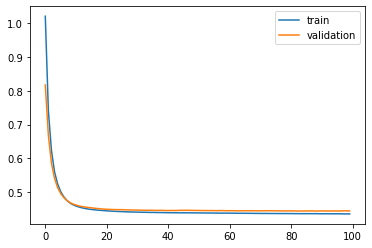

Time to train LSTM:  114.99999833106995


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f8eb1b7c7b8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 12s - loss: 0.9710 - val_loss: 0.8028

Epoch 00001: val_loss improved from inf to 0.80284, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7103 - val_loss: 0.6333

Epoch 00002: val_loss improved from 0.80284 to 0.63327, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5919 - val_loss: 0.5553

Epoch 00003: val_loss improved from 0.63327 to 0.55528, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5338 - val_loss: 0.5132

Epoch 00004: val_loss improved from 0.55528 to 0.51317, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5018 - val_loss: 0.4890

Epoch 00005: val_loss improved from 0.51317 to 0.48903, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4828 - val_loss: 0.4753

Epoch 00006: val_loss improved from 0.48903 to 0.47531, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4717 - val_loss: 0.4669

Epoch 00007: val_loss improved from 0.47531

 - 1s - loss: 0.4394 - val_loss: 0.4419

Epoch 00062: val_loss improved from 0.44198 to 0.44190, saving model to val_weights1.hdf5
Epoch 63/100
 - 1s - loss: 0.4391 - val_loss: 0.4420

Epoch 00063: val_loss did not improve from 0.44190
Epoch 64/100
 - 1s - loss: 0.4391 - val_loss: 0.4420

Epoch 00064: val_loss did not improve from 0.44190
Epoch 65/100
 - 1s - loss: 0.4390 - val_loss: 0.4418

Epoch 00065: val_loss improved from 0.44190 to 0.44183, saving model to val_weights1.hdf5
Epoch 66/100
 - 1s - loss: 0.4390 - val_loss: 0.4418

Epoch 00066: val_loss improved from 0.44183 to 0.44176, saving model to val_weights1.hdf5
Epoch 67/100
 - 1s - loss: 0.4390 - val_loss: 0.4417

Epoch 00067: val_loss improved from 0.44176 to 0.44166, saving model to val_weights1.hdf5
Epoch 68/100
 - 1s - loss: 0.4389 - val_loss: 0.4416

Epoch 00068: val_loss improved from 0.44166 to 0.44163, saving model to val_weights1.hdf5
Epoch 69/100
 - 1s - loss: 0.4389 - val_loss: 0.4416

Epoch 00069: val_loss improve

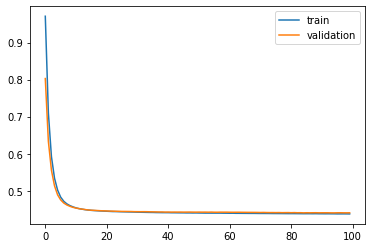

Time to train LSTM:  116.4790985584259
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 0.9615 - val_loss: 0.7863

Epoch 00001: val_loss improved from inf to 0.78631, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7090 - val_loss: 0.6347

Epoch 00002: val_loss improved from 0.78631 to 0.63466, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5961 - val_loss: 0.5569

Epoch 00003: val_loss improved from 0.63466 to 0.55689, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5367 - val_loss: 0.5148

Epoch 00004: val_loss improved from 0.55689 to 0.51480, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5041 - val_loss: 0.4909

Epoch 00005: val_loss improved from 0.51480 to 0.49093, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4851 - val_loss: 0.4763

Epoch 00006: val_loss improved from 0.49093 to 0.47627, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4730 - val_loss: 0.4668

Epoc


Epoch 00064: val_loss improved from 0.44105 to 0.44102, saving model to val_weights2.hdf5
Epoch 65/100
 - 1s - loss: 0.4375 - val_loss: 0.4412

Epoch 00065: val_loss did not improve from 0.44102
Epoch 66/100
 - 1s - loss: 0.4374 - val_loss: 0.4410

Epoch 00066: val_loss improved from 0.44102 to 0.44096, saving model to val_weights2.hdf5
Epoch 67/100
 - 1s - loss: 0.4373 - val_loss: 0.4407

Epoch 00067: val_loss improved from 0.44096 to 0.44072, saving model to val_weights2.hdf5
Epoch 68/100
 - 1s - loss: 0.4372 - val_loss: 0.4409

Epoch 00068: val_loss did not improve from 0.44072
Epoch 69/100
 - 1s - loss: 0.4371 - val_loss: 0.4408

Epoch 00069: val_loss did not improve from 0.44072
Epoch 70/100
 - 1s - loss: 0.4371 - val_loss: 0.4409

Epoch 00070: val_loss did not improve from 0.44072
Epoch 71/100
 - 1s - loss: 0.4370 - val_loss: 0.4410

Epoch 00071: val_loss did not improve from 0.44072
Epoch 72/100
 - 1s - loss: 0.4370 - val_loss: 0.4406

Epoch 00072: val_loss improved from 0.4407

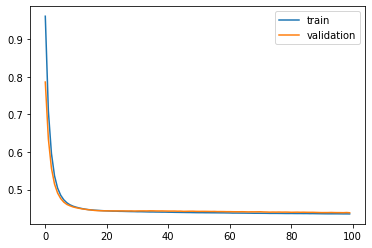

Time to train LSTM:  116.69286918640137
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 1.0446 - val_loss: 0.8346

Epoch 00001: val_loss improved from inf to 0.83461, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7380 - val_loss: 0.6614

Epoch 00002: val_loss improved from 0.83461 to 0.66139, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.6125 - val_loss: 0.5781

Epoch 00003: val_loss improved from 0.66139 to 0.57808, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5499 - val_loss: 0.5330

Epoch 00004: val_loss improved from 0.57808 to 0.53296, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5149 - val_loss: 0.5063

Epoch 00005: val_loss improved from 0.53296 to 0.50630, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4935 - val_loss: 0.4898

Epoch 00006: val_loss improved from 0.50630 to 0.48978, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4795 - val_loss: 0.4786

Epo

 - 1s - loss: 0.4370 - val_loss: 0.4462

Epoch 00063: val_loss did not improve from 0.44589
Epoch 64/100
 - 1s - loss: 0.4368 - val_loss: 0.4462

Epoch 00064: val_loss did not improve from 0.44589
Epoch 65/100
 - 1s - loss: 0.4367 - val_loss: 0.4461

Epoch 00065: val_loss did not improve from 0.44589
Epoch 66/100
 - 1s - loss: 0.4367 - val_loss: 0.4462

Epoch 00066: val_loss did not improve from 0.44589
Epoch 67/100
 - 1s - loss: 0.4366 - val_loss: 0.4460

Epoch 00067: val_loss did not improve from 0.44589
Epoch 68/100
 - 1s - loss: 0.4366 - val_loss: 0.4461

Epoch 00068: val_loss did not improve from 0.44589
Epoch 69/100
 - 1s - loss: 0.4366 - val_loss: 0.4464

Epoch 00069: val_loss did not improve from 0.44589
Epoch 70/100
 - 1s - loss: 0.4365 - val_loss: 0.4465

Epoch 00070: val_loss did not improve from 0.44589
Epoch 71/100
 - 1s - loss: 0.4365 - val_loss: 0.4466

Epoch 00071: val_loss did not improve from 0.44589
Epoch 72/100
 - 1s - loss: 0.4365 - val_loss: 0.4462

Epoch 00072: v

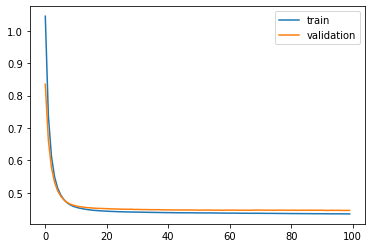

Time to train LSTM:  115.30217123031616
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 0.9555 - val_loss: 0.7926

Epoch 00001: val_loss improved from inf to 0.79265, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7109 - val_loss: 0.6356

Epoch 00002: val_loss improved from 0.79265 to 0.63562, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5966 - val_loss: 0.5543

Epoch 00003: val_loss improved from 0.63562 to 0.55434, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5365 - val_loss: 0.5105

Epoch 00004: val_loss improved from 0.55434 to 0.51051, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5034 - val_loss: 0.4852

Epoch 00005: val_loss improved from 0.51051 to 0.48524, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4837 - val_loss: 0.4700

Epoch 00006: val_loss improved from 0.48524 to 0.46996, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4712 - val_loss: 0.4606

Epo

 - 1s - loss: 0.4387 - val_loss: 0.4411

Epoch 00068: val_loss did not improve from 0.44044
Epoch 69/100
 - 1s - loss: 0.4387 - val_loss: 0.4409

Epoch 00069: val_loss did not improve from 0.44044
Epoch 70/100
 - 1s - loss: 0.4386 - val_loss: 0.4409

Epoch 00070: val_loss did not improve from 0.44044
Epoch 71/100
 - 1s - loss: 0.4385 - val_loss: 0.4405

Epoch 00071: val_loss did not improve from 0.44044
Epoch 72/100
 - 1s - loss: 0.4385 - val_loss: 0.4406

Epoch 00072: val_loss did not improve from 0.44044
Epoch 73/100
 - 1s - loss: 0.4384 - val_loss: 0.4410

Epoch 00073: val_loss did not improve from 0.44044
Epoch 74/100
 - 1s - loss: 0.4384 - val_loss: 0.4407

Epoch 00074: val_loss did not improve from 0.44044
Epoch 75/100
 - 1s - loss: 0.4383 - val_loss: 0.4406

Epoch 00075: val_loss did not improve from 0.44044
Epoch 76/100
 - 1s - loss: 0.4383 - val_loss: 0.4406

Epoch 00076: val_loss did not improve from 0.44044
Epoch 77/100
 - 1s - loss: 0.4382 - val_loss: 0.4403

Epoch 00077: v

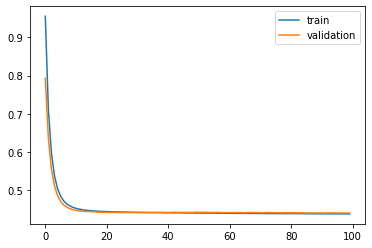

Time to train LSTM:  115.63116669654846
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 13s - loss: 1.0049 - val_loss: 0.8342

Epoch 00001: val_loss improved from inf to 0.83421, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7264 - val_loss: 0.6379

Epoch 00002: val_loss improved from 0.83421 to 0.63793, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5899 - val_loss: 0.5569

Epoch 00003: val_loss improved from 0.63793 to 0.55685, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5322 - val_loss: 0.5165

Epoch 00004: val_loss improved from 0.55685 to 0.51652, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5019 - val_loss: 0.4936

Epoch 00005: val_loss improved from 0.51652 to 0.49363, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4840 - val_loss: 0.4798

Epoch 00006: val_loss improved from 0.49363 to 0.47980, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4726 - val_loss: 0.4716

Epo

 - 1s - loss: 0.4363 - val_loss: 0.4445

Epoch 00063: val_loss did not improve from 0.44402
Epoch 64/100
 - 1s - loss: 0.4362 - val_loss: 0.4445

Epoch 00064: val_loss did not improve from 0.44402
Epoch 65/100
 - 1s - loss: 0.4363 - val_loss: 0.4445

Epoch 00065: val_loss did not improve from 0.44402
Epoch 66/100
 - 1s - loss: 0.4362 - val_loss: 0.4443

Epoch 00066: val_loss did not improve from 0.44402
Epoch 67/100
 - 1s - loss: 0.4362 - val_loss: 0.4443

Epoch 00067: val_loss did not improve from 0.44402
Epoch 68/100
 - 1s - loss: 0.4363 - val_loss: 0.4441

Epoch 00068: val_loss did not improve from 0.44402
Epoch 69/100
 - 1s - loss: 0.4361 - val_loss: 0.4445

Epoch 00069: val_loss did not improve from 0.44402
Epoch 70/100
 - 1s - loss: 0.4363 - val_loss: 0.4441

Epoch 00070: val_loss did not improve from 0.44402
Epoch 71/100
 - 1s - loss: 0.4361 - val_loss: 0.4444

Epoch 00071: val_loss did not improve from 0.44402
Epoch 72/100
 - 1s - loss: 0.4361 - val_loss: 0.4438

Epoch 00072: v

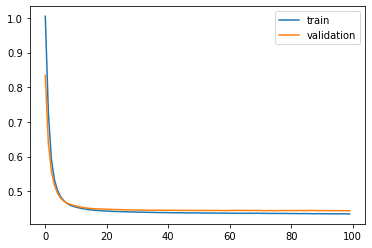

Time to train LSTM:  116.4107551574707
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 1.0388 - val_loss: 0.8496

Epoch 00001: val_loss improved from inf to 0.84964, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7444 - val_loss: 0.6556

Epoch 00002: val_loss improved from 0.84964 to 0.65557, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.6044 - val_loss: 0.5625

Epoch 00003: val_loss improved from 0.65557 to 0.56250, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5363 - val_loss: 0.5136

Epoch 00004: val_loss improved from 0.56250 to 0.51356, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5003 - val_loss: 0.4857

Epoch 00005: val_loss improved from 0.51356 to 0.48572, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4800 - val_loss: 0.4717

Epoch 00006: val_loss improved from 0.48572 to 0.47173, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4692 - val_loss: 0.4645

Epoc


Epoch 00065: val_loss did not improve from 0.44011
Epoch 66/100
 - 1s - loss: 0.4395 - val_loss: 0.4412

Epoch 00066: val_loss did not improve from 0.44011
Epoch 67/100
 - 1s - loss: 0.4395 - val_loss: 0.4402

Epoch 00067: val_loss did not improve from 0.44011
Epoch 68/100
 - 1s - loss: 0.4393 - val_loss: 0.4402

Epoch 00068: val_loss did not improve from 0.44011
Epoch 69/100
 - 1s - loss: 0.4394 - val_loss: 0.4404

Epoch 00069: val_loss did not improve from 0.44011
Epoch 70/100
 - 1s - loss: 0.4390 - val_loss: 0.4398

Epoch 00070: val_loss improved from 0.44011 to 0.43979, saving model to val_weights1.hdf5
Epoch 71/100
 - 1s - loss: 0.4389 - val_loss: 0.4398

Epoch 00071: val_loss improved from 0.43979 to 0.43975, saving model to val_weights1.hdf5
Epoch 72/100
 - 1s - loss: 0.4390 - val_loss: 0.4401

Epoch 00072: val_loss did not improve from 0.43975
Epoch 73/100
 - 1s - loss: 0.4388 - val_loss: 0.4390

Epoch 00073: val_loss improved from 0.43975 to 0.43896, saving model to val_weigh

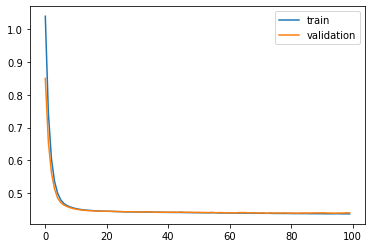

Time to train LSTM:  105.78580093383789
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 14s - loss: 1.1303 - val_loss: 0.8647

Epoch 00001: val_loss improved from inf to 0.86466, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7819 - val_loss: 0.7001

Epoch 00002: val_loss improved from 0.86466 to 0.70013, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.6548 - val_loss: 0.6067

Epoch 00003: val_loss improved from 0.70013 to 0.60668, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5798 - val_loss: 0.5505

Epoch 00004: val_loss improved from 0.60668 to 0.55048, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5353 - val_loss: 0.5166

Epoch 00005: val_loss improved from 0.55048 to 0.51660, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.5080 - val_loss: 0.4955

Epoch 00006: val_loss improved from 0.51660 to 0.49545, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4902 - val_loss: 0.4807

Epo

 - 1s - loss: 0.4386 - val_loss: 0.4407

Epoch 00062: val_loss improved from 0.44075 to 0.44075, saving model to val_weights2.hdf5
Epoch 63/100
 - 1s - loss: 0.4387 - val_loss: 0.4407

Epoch 00063: val_loss improved from 0.44075 to 0.44075, saving model to val_weights2.hdf5
Epoch 64/100
 - 1s - loss: 0.4385 - val_loss: 0.4405

Epoch 00064: val_loss improved from 0.44075 to 0.44047, saving model to val_weights2.hdf5
Epoch 65/100
 - 1s - loss: 0.4385 - val_loss: 0.4405

Epoch 00065: val_loss improved from 0.44047 to 0.44046, saving model to val_weights2.hdf5
Epoch 66/100
 - 1s - loss: 0.4384 - val_loss: 0.4405

Epoch 00066: val_loss did not improve from 0.44046
Epoch 67/100
 - 1s - loss: 0.4383 - val_loss: 0.4401

Epoch 00067: val_loss improved from 0.44046 to 0.44013, saving model to val_weights2.hdf5
Epoch 68/100
 - 1s - loss: 0.4382 - val_loss: 0.4401

Epoch 00068: val_loss did not improve from 0.44013
Epoch 69/100
 - 1s - loss: 0.4383 - val_loss: 0.4399

Epoch 00069: val_loss improve

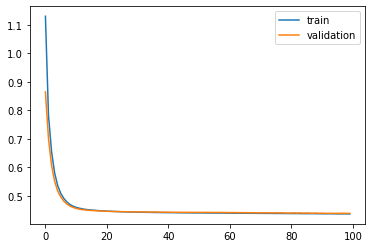

Time to train LSTM:  108.44486141204834


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f8ea1f685f8>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 15s - loss: 0.9930 - val_loss: 0.8170

Epoch 00001: val_loss improved from inf to 0.81698, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7107 - val_loss: 0.6344

Epoch 00002: val_loss improved from 0.81698 to 0.63439, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5867 - val_loss: 0.5548

Epoch 00003: val_loss improved from 0.63439 to 0.55483, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5268 - val_loss: 0.5119

Epoch 00004: val_loss improved from 0.55483 to 0.51185, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.4940 - val_loss: 0.4870

Epoch 00005: val_loss improved from 0.51185 to 0.48695, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4750 - val_loss: 0.4725

Epoch 00006: val_loss improved from 0.48695 to 0.47251, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4641 - val_loss: 0.4648

Epoch 00007: val_loss improved from 0.47251

 - 1s - loss: 0.4372 - val_loss: 0.4464

Epoch 00064: val_loss did not improve from 0.44585
Epoch 65/100
 - 1s - loss: 0.4371 - val_loss: 0.4463

Epoch 00065: val_loss did not improve from 0.44585
Epoch 66/100
 - 1s - loss: 0.4371 - val_loss: 0.4464

Epoch 00066: val_loss did not improve from 0.44585
Epoch 67/100
 - 1s - loss: 0.4369 - val_loss: 0.4459

Epoch 00067: val_loss did not improve from 0.44585
Epoch 68/100
 - 1s - loss: 0.4369 - val_loss: 0.4460

Epoch 00068: val_loss did not improve from 0.44585
Epoch 69/100
 - 1s - loss: 0.4368 - val_loss: 0.4457

Epoch 00069: val_loss improved from 0.44585 to 0.44568, saving model to val_weights3.hdf5
Epoch 70/100
 - 1s - loss: 0.4368 - val_loss: 0.4461

Epoch 00070: val_loss did not improve from 0.44568
Epoch 71/100
 - 1s - loss: 0.4367 - val_loss: 0.4461

Epoch 00071: val_loss did not improve from 0.44568
Epoch 72/100
 - 1s - loss: 0.4366 - val_loss: 0.4460

Epoch 00072: val_loss did not improve from 0.44568
Epoch 73/100
 - 1s - loss: 0.

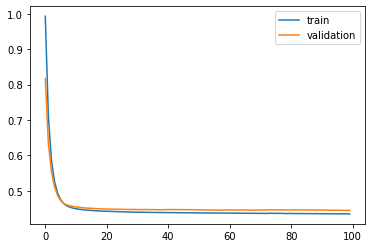

Time to train LSTM:  108.76360893249512
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 15s - loss: 1.0107 - val_loss: 0.8157

Epoch 00001: val_loss improved from inf to 0.81574, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7226 - val_loss: 0.6317

Epoch 00002: val_loss improved from 0.81574 to 0.63173, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5937 - val_loss: 0.5482

Epoch 00003: val_loss improved from 0.63173 to 0.54820, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5330 - val_loss: 0.5055

Epoch 00004: val_loss improved from 0.54820 to 0.50553, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5004 - val_loss: 0.4815

Epoch 00005: val_loss improved from 0.50553 to 0.48145, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4812 - val_loss: 0.4675

Epoch 00006: val_loss improved from 0.48145 to 0.46748, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4693 - val_loss: 0.4586

Epo

 - 1s - loss: 0.4379 - val_loss: 0.4401

Epoch 00069: val_loss did not improve from 0.43990
Epoch 70/100
 - 1s - loss: 0.4379 - val_loss: 0.4399

Epoch 00070: val_loss did not improve from 0.43990
Epoch 71/100
 - 1s - loss: 0.4377 - val_loss: 0.4403

Epoch 00071: val_loss did not improve from 0.43990
Epoch 72/100
 - 1s - loss: 0.4378 - val_loss: 0.4398

Epoch 00072: val_loss improved from 0.43990 to 0.43976, saving model to val_weights4.hdf5
Epoch 73/100
 - 1s - loss: 0.4377 - val_loss: 0.4396

Epoch 00073: val_loss improved from 0.43976 to 0.43962, saving model to val_weights4.hdf5
Epoch 74/100
 - 1s - loss: 0.4376 - val_loss: 0.4401

Epoch 00074: val_loss did not improve from 0.43962
Epoch 75/100
 - 1s - loss: 0.4376 - val_loss: 0.4397

Epoch 00075: val_loss did not improve from 0.43962
Epoch 76/100
 - 1s - loss: 0.4376 - val_loss: 0.4393

Epoch 00076: val_loss improved from 0.43962 to 0.43933, saving model to val_weights4.hdf5
Epoch 77/100
 - 1s - loss: 0.4374 - val_loss: 0.4396

Ep

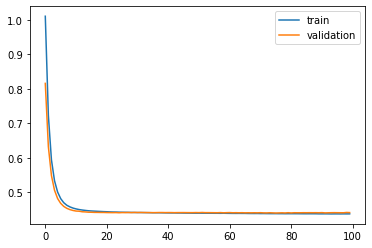

Time to train LSTM:  108.21527433395386
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 16s - loss: 1.0444 - val_loss: 0.8492

Epoch 00001: val_loss improved from inf to 0.84916, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7467 - val_loss: 0.6560

Epoch 00002: val_loss improved from 0.84916 to 0.65602, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6067 - val_loss: 0.5673

Epoch 00003: val_loss improved from 0.65602 to 0.56728, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5419 - val_loss: 0.5236

Epoch 00004: val_loss improved from 0.56728 to 0.52357, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5085 - val_loss: 0.4995

Epoch 00005: val_loss improved from 0.52357 to 0.49947, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4896 - val_loss: 0.4853

Epoch 00006: val_loss improved from 0.49947 to 0.48531, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4776 - val_loss: 0.4759

Epo


Epoch 00064: val_loss did not improve from 0.44491
Epoch 65/100
 - 1s - loss: 0.4374 - val_loss: 0.4450

Epoch 00065: val_loss did not improve from 0.44491
Epoch 66/100
 - 1s - loss: 0.4373 - val_loss: 0.4449

Epoch 00066: val_loss did not improve from 0.44491
Epoch 67/100
 - 1s - loss: 0.4371 - val_loss: 0.4445

Epoch 00067: val_loss improved from 0.44491 to 0.44454, saving model to val_weights5.hdf5
Epoch 68/100
 - 1s - loss: 0.4372 - val_loss: 0.4450

Epoch 00068: val_loss did not improve from 0.44454
Epoch 69/100
 - 1s - loss: 0.4371 - val_loss: 0.4448

Epoch 00069: val_loss did not improve from 0.44454
Epoch 70/100
 - 1s - loss: 0.4372 - val_loss: 0.4447

Epoch 00070: val_loss did not improve from 0.44454
Epoch 71/100
 - 1s - loss: 0.4369 - val_loss: 0.4445

Epoch 00071: val_loss improved from 0.44454 to 0.44447, saving model to val_weights5.hdf5
Epoch 72/100
 - 1s - loss: 0.4370 - val_loss: 0.4445

Epoch 00072: val_loss did not improve from 0.44447
Epoch 73/100
 - 1s - loss: 0.4

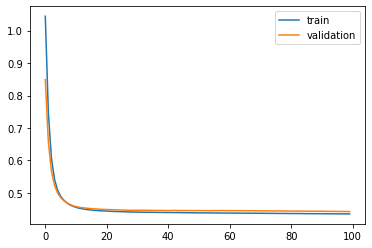

Time to train LSTM:  120.88721537590027
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 15s - loss: 0.9513 - val_loss: 0.7867

Epoch 00001: val_loss improved from inf to 0.78671, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6953 - val_loss: 0.6181

Epoch 00002: val_loss improved from 0.78671 to 0.61811, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5793 - val_loss: 0.5448

Epoch 00003: val_loss improved from 0.61811 to 0.54476, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5256 - val_loss: 0.5070

Epoch 00004: val_loss improved from 0.54476 to 0.50699, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.4968 - val_loss: 0.4855

Epoch 00005: val_loss improved from 0.50699 to 0.48546, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4795 - val_loss: 0.4722

Epoch 00006: val_loss improved from 0.48546 to 0.47223, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4681 - val_loss: 0.4638

Epo


Epoch 00060: val_loss did not improve from 0.43955
Epoch 61/100
 - 1s - loss: 0.4369 - val_loss: 0.4396

Epoch 00061: val_loss did not improve from 0.43955
Epoch 62/100
 - 1s - loss: 0.4369 - val_loss: 0.4394

Epoch 00062: val_loss improved from 0.43955 to 0.43938, saving model to val_weights1.hdf5
Epoch 63/100
 - 1s - loss: 0.4369 - val_loss: 0.4398

Epoch 00063: val_loss did not improve from 0.43938
Epoch 64/100
 - 1s - loss: 0.4367 - val_loss: 0.4394

Epoch 00064: val_loss did not improve from 0.43938
Epoch 65/100
 - 1s - loss: 0.4366 - val_loss: 0.4396

Epoch 00065: val_loss did not improve from 0.43938
Epoch 66/100
 - 1s - loss: 0.4366 - val_loss: 0.4392

Epoch 00066: val_loss improved from 0.43938 to 0.43920, saving model to val_weights1.hdf5
Epoch 67/100
 - 1s - loss: 0.4364 - val_loss: 0.4394

Epoch 00067: val_loss did not improve from 0.43920
Epoch 68/100
 - 1s - loss: 0.4366 - val_loss: 0.4392

Epoch 00068: val_loss did not improve from 0.43920
Epoch 69/100
 - 1s - loss: 0.4

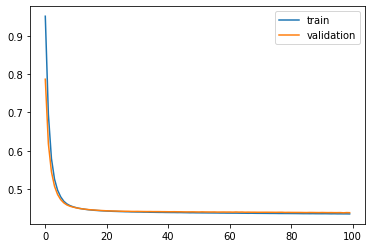

Time to train LSTM:  120.19785261154175
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 15s - loss: 0.8524 - val_loss: 0.7226

Epoch 00001: val_loss improved from inf to 0.72260, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6585 - val_loss: 0.5989

Epoch 00002: val_loss improved from 0.72260 to 0.59891, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5680 - val_loss: 0.5351

Epoch 00003: val_loss improved from 0.59891 to 0.53513, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5196 - val_loss: 0.5003

Epoch 00004: val_loss improved from 0.53513 to 0.50034, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.4927 - val_loss: 0.4805

Epoch 00005: val_loss improved from 0.50034 to 0.48047, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4767 - val_loss: 0.4682

Epoch 00006: val_loss improved from 0.48047 to 0.46816, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4660 - val_loss: 0.4604

Epo

 - 1s - loss: 0.4358 - val_loss: 0.4401

Epoch 00063: val_loss did not improve from 0.44006
Epoch 64/100
 - 1s - loss: 0.4356 - val_loss: 0.4398

Epoch 00064: val_loss improved from 0.44006 to 0.43980, saving model to val_weights2.hdf5
Epoch 65/100
 - 1s - loss: 0.4354 - val_loss: 0.4398

Epoch 00065: val_loss did not improve from 0.43980
Epoch 66/100
 - 1s - loss: 0.4356 - val_loss: 0.4399

Epoch 00066: val_loss did not improve from 0.43980
Epoch 67/100
 - 1s - loss: 0.4355 - val_loss: 0.4397

Epoch 00067: val_loss improved from 0.43980 to 0.43971, saving model to val_weights2.hdf5
Epoch 68/100
 - 1s - loss: 0.4355 - val_loss: 0.4398

Epoch 00068: val_loss did not improve from 0.43971
Epoch 69/100
 - 1s - loss: 0.4354 - val_loss: 0.4395

Epoch 00069: val_loss improved from 0.43971 to 0.43951, saving model to val_weights2.hdf5
Epoch 70/100
 - 1s - loss: 0.4353 - val_loss: 0.4394

Epoch 00070: val_loss improved from 0.43951 to 0.43936, saving model to val_weights2.hdf5
Epoch 71/100
 - 1

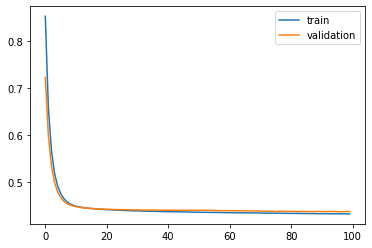

Time to train LSTM:  119.6483383178711
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 17s - loss: 0.9951 - val_loss: 0.8304

Epoch 00001: val_loss improved from inf to 0.83040, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7431 - val_loss: 0.6718

Epoch 00002: val_loss improved from 0.83040 to 0.67183, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.6231 - val_loss: 0.5888

Epoch 00003: val_loss improved from 0.67183 to 0.58878, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5591 - val_loss: 0.5416

Epoch 00004: val_loss improved from 0.58878 to 0.54157, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5212 - val_loss: 0.5119

Epoch 00005: val_loss improved from 0.54157 to 0.51194, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4972 - val_loss: 0.4927

Epoch 00006: val_loss improved from 0.51194 to 0.49271, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4809 - val_loss: 0.4789

Epoc

 - 1s - loss: 0.4369 - val_loss: 0.4460

Epoch 00063: val_loss did not improve from 0.44560
Epoch 64/100
 - 1s - loss: 0.4369 - val_loss: 0.4460

Epoch 00064: val_loss did not improve from 0.44560
Epoch 65/100
 - 1s - loss: 0.4368 - val_loss: 0.4459

Epoch 00065: val_loss did not improve from 0.44560
Epoch 66/100
 - 1s - loss: 0.4367 - val_loss: 0.4459

Epoch 00066: val_loss did not improve from 0.44560
Epoch 67/100
 - 1s - loss: 0.4367 - val_loss: 0.4458

Epoch 00067: val_loss did not improve from 0.44560
Epoch 68/100
 - 1s - loss: 0.4365 - val_loss: 0.4458

Epoch 00068: val_loss did not improve from 0.44560
Epoch 69/100
 - 1s - loss: 0.4365 - val_loss: 0.4459

Epoch 00069: val_loss did not improve from 0.44560
Epoch 70/100
 - 1s - loss: 0.4366 - val_loss: 0.4460

Epoch 00070: val_loss did not improve from 0.44560
Epoch 71/100
 - 1s - loss: 0.4364 - val_loss: 0.4458

Epoch 00071: val_loss did not improve from 0.44560
Epoch 72/100
 - 1s - loss: 0.4363 - val_loss: 0.4459

Epoch 00072: v

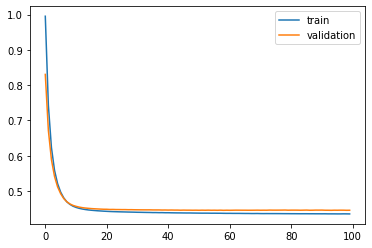

Time to train LSTM:  122.82058906555176
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 17s - loss: 0.9569 - val_loss: 0.7819

Epoch 00001: val_loss improved from inf to 0.78193, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7085 - val_loss: 0.6392

Epoch 00002: val_loss improved from 0.78193 to 0.63922, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6042 - val_loss: 0.5658

Epoch 00003: val_loss improved from 0.63922 to 0.56576, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5468 - val_loss: 0.5223

Epoch 00004: val_loss improved from 0.56576 to 0.52227, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5130 - val_loss: 0.4957

Epoch 00005: val_loss improved from 0.52227 to 0.49569, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4921 - val_loss: 0.4787

Epoch 00006: val_loss improved from 0.49569 to 0.47866, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4782 - val_loss: 0.4669

Epo

 - 1s - loss: 0.4375 - val_loss: 0.4385

Epoch 00065: val_loss improved from 0.43864 to 0.43852, saving model to val_weights4.hdf5
Epoch 66/100
 - 1s - loss: 0.4374 - val_loss: 0.4385

Epoch 00066: val_loss improved from 0.43852 to 0.43847, saving model to val_weights4.hdf5
Epoch 67/100
 - 1s - loss: 0.4374 - val_loss: 0.4388

Epoch 00067: val_loss did not improve from 0.43847
Epoch 68/100
 - 1s - loss: 0.4372 - val_loss: 0.4384

Epoch 00068: val_loss improved from 0.43847 to 0.43839, saving model to val_weights4.hdf5
Epoch 69/100
 - 1s - loss: 0.4373 - val_loss: 0.4380

Epoch 00069: val_loss improved from 0.43839 to 0.43802, saving model to val_weights4.hdf5
Epoch 70/100
 - 1s - loss: 0.4370 - val_loss: 0.4380

Epoch 00070: val_loss improved from 0.43802 to 0.43795, saving model to val_weights4.hdf5
Epoch 71/100
 - 1s - loss: 0.4370 - val_loss: 0.4380

Epoch 00071: val_loss did not improve from 0.43795
Epoch 72/100
 - 1s - loss: 0.4369 - val_loss: 0.4382

Epoch 00072: val_loss did not

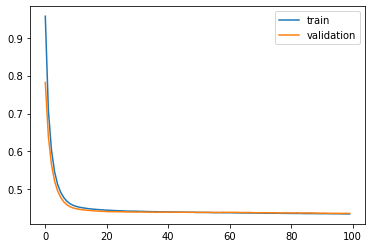

Time to train LSTM:  123.31725764274597
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 0.9316 - val_loss: 0.7845

Epoch 00001: val_loss improved from inf to 0.78446, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7028 - val_loss: 0.6333

Epoch 00002: val_loss improved from 0.78446 to 0.63333, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5903 - val_loss: 0.5587

Epoch 00003: val_loss improved from 0.63333 to 0.55871, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5329 - val_loss: 0.5175

Epoch 00004: val_loss improved from 0.55871 to 0.51749, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5010 - val_loss: 0.4931

Epoch 00005: val_loss improved from 0.51749 to 0.49310, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4814 - val_loss: 0.4767

Epoch 00006: val_loss improved from 0.49310 to 0.47670, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4683 - val_loss: 0.4667

Epo

 - 1s - loss: 0.4364 - val_loss: 0.4437

Epoch 00062: val_loss did not improve from 0.44327
Epoch 63/100
 - 1s - loss: 0.4364 - val_loss: 0.4434

Epoch 00063: val_loss did not improve from 0.44327
Epoch 64/100
 - 1s - loss: 0.4363 - val_loss: 0.4438

Epoch 00064: val_loss did not improve from 0.44327
Epoch 65/100
 - 1s - loss: 0.4363 - val_loss: 0.4437

Epoch 00065: val_loss did not improve from 0.44327
Epoch 66/100
 - 1s - loss: 0.4362 - val_loss: 0.4435

Epoch 00066: val_loss did not improve from 0.44327
Epoch 67/100
 - 1s - loss: 0.4361 - val_loss: 0.4436

Epoch 00067: val_loss did not improve from 0.44327
Epoch 68/100
 - 1s - loss: 0.4361 - val_loss: 0.4435

Epoch 00068: val_loss did not improve from 0.44327
Epoch 69/100
 - 1s - loss: 0.4359 - val_loss: 0.4437

Epoch 00069: val_loss did not improve from 0.44327
Epoch 70/100
 - 1s - loss: 0.4360 - val_loss: 0.4438

Epoch 00070: val_loss did not improve from 0.44327
Epoch 71/100
 - 1s - loss: 0.4359 - val_loss: 0.4435

Epoch 00071: v

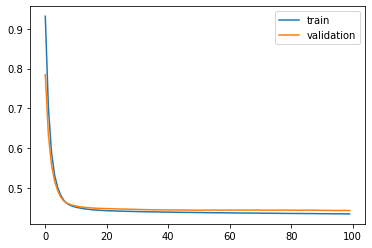

Time to train LSTM:  115.0631251335144


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f8e99b6e4e0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 0.9693 - val_loss: 0.7875

Epoch 00001: val_loss improved from inf to 0.78754, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7044 - val_loss: 0.6292

Epoch 00002: val_loss improved from 0.78754 to 0.62918, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5911 - val_loss: 0.5578

Epoch 00003: val_loss improved from 0.62918 to 0.55782, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5368 - val_loss: 0.5183

Epoch 00004: val_loss improved from 0.55782 to 0.51834, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5069 - val_loss: 0.4956

Epoch 00005: val_loss improved from 0.51834 to 0.49564, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4893 - val_loss: 0.4814

Epoch 00006: val_loss improved from 0.49564 to 0.48140, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4779 - val_loss: 0.4718

Epoch 00007: val_loss improved from 0.48140

 - 1s - loss: 0.4369 - val_loss: 0.4402

Epoch 00063: val_loss did not improve from 0.43971
Epoch 64/100
 - 1s - loss: 0.4369 - val_loss: 0.4397

Epoch 00064: val_loss improved from 0.43971 to 0.43969, saving model to val_weights1.hdf5
Epoch 65/100
 - 1s - loss: 0.4367 - val_loss: 0.4398

Epoch 00065: val_loss did not improve from 0.43969
Epoch 66/100
 - 1s - loss: 0.4367 - val_loss: 0.4395

Epoch 00066: val_loss improved from 0.43969 to 0.43945, saving model to val_weights1.hdf5
Epoch 67/100
 - 1s - loss: 0.4365 - val_loss: 0.4396

Epoch 00067: val_loss did not improve from 0.43945
Epoch 68/100
 - 1s - loss: 0.4365 - val_loss: 0.4396

Epoch 00068: val_loss did not improve from 0.43945
Epoch 69/100
 - 1s - loss: 0.4365 - val_loss: 0.4396

Epoch 00069: val_loss did not improve from 0.43945
Epoch 70/100
 - 1s - loss: 0.4364 - val_loss: 0.4393

Epoch 00070: val_loss improved from 0.43945 to 0.43930, saving model to val_weights1.hdf5
Epoch 71/100
 - 1s - loss: 0.4363 - val_loss: 0.4392

Ep

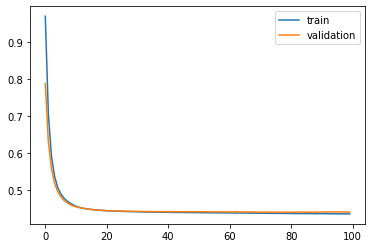

Time to train LSTM:  126.70122408866882
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 19s - loss: 0.9700 - val_loss: 0.8171

Epoch 00001: val_loss improved from inf to 0.81708, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7253 - val_loss: 0.6430

Epoch 00002: val_loss improved from 0.81708 to 0.64297, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5993 - val_loss: 0.5643

Epoch 00003: val_loss improved from 0.64297 to 0.56432, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5440 - val_loss: 0.5241

Epoch 00004: val_loss improved from 0.56432 to 0.52409, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5125 - val_loss: 0.4995

Epoch 00005: val_loss improved from 0.52409 to 0.49953, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4924 - val_loss: 0.4836

Epoch 00006: val_loss improved from 0.49953 to 0.48363, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4791 - val_loss: 0.4729

Epo


Epoch 00060: val_loss did not improve from 0.43966
Epoch 61/100
 - 1s - loss: 0.4377 - val_loss: 0.4396

Epoch 00061: val_loss improved from 0.43966 to 0.43962, saving model to val_weights2.hdf5
Epoch 62/100
 - 1s - loss: 0.4378 - val_loss: 0.4396

Epoch 00062: val_loss did not improve from 0.43962
Epoch 63/100
 - 1s - loss: 0.4378 - val_loss: 0.4398

Epoch 00063: val_loss did not improve from 0.43962
Epoch 64/100
 - 1s - loss: 0.4376 - val_loss: 0.4399

Epoch 00064: val_loss did not improve from 0.43962
Epoch 65/100
 - 1s - loss: 0.4375 - val_loss: 0.4399

Epoch 00065: val_loss did not improve from 0.43962
Epoch 66/100
 - 1s - loss: 0.4374 - val_loss: 0.4396

Epoch 00066: val_loss improved from 0.43962 to 0.43959, saving model to val_weights2.hdf5
Epoch 67/100
 - 1s - loss: 0.4375 - val_loss: 0.4399

Epoch 00067: val_loss did not improve from 0.43959
Epoch 68/100
 - 1s - loss: 0.4373 - val_loss: 0.4397

Epoch 00068: val_loss did not improve from 0.43959
Epoch 69/100
 - 1s - loss: 0.4

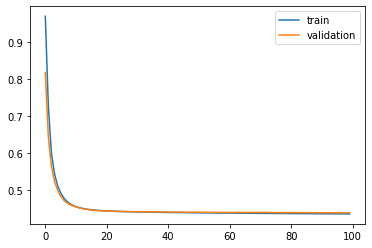

Time to train LSTM:  127.30239868164062
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 20s - loss: 0.8757 - val_loss: 0.7477

Epoch 00001: val_loss improved from inf to 0.74774, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6700 - val_loss: 0.6197

Epoch 00002: val_loss improved from 0.74774 to 0.61968, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5756 - val_loss: 0.5538

Epoch 00003: val_loss improved from 0.61968 to 0.55381, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5277 - val_loss: 0.5179

Epoch 00004: val_loss improved from 0.55381 to 0.51792, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5004 - val_loss: 0.4967

Epoch 00005: val_loss improved from 0.51792 to 0.49665, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4837 - val_loss: 0.4834

Epoch 00006: val_loss improved from 0.49665 to 0.48340, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4725 - val_loss: 0.4741

Epo

 - 1s - loss: 0.4332 - val_loss: 0.4425

Epoch 00063: val_loss improved from 0.44262 to 0.44247, saving model to val_weights3.hdf5
Epoch 64/100
 - 1s - loss: 0.4333 - val_loss: 0.4424

Epoch 00064: val_loss improved from 0.44247 to 0.44240, saving model to val_weights3.hdf5
Epoch 65/100
 - 1s - loss: 0.4331 - val_loss: 0.4425

Epoch 00065: val_loss did not improve from 0.44240
Epoch 66/100
 - 1s - loss: 0.4330 - val_loss: 0.4424

Epoch 00066: val_loss did not improve from 0.44240
Epoch 67/100
 - 1s - loss: 0.4328 - val_loss: 0.4427

Epoch 00067: val_loss did not improve from 0.44240
Epoch 68/100
 - 1s - loss: 0.4328 - val_loss: 0.4424

Epoch 00068: val_loss improved from 0.44240 to 0.44238, saving model to val_weights3.hdf5
Epoch 69/100
 - 1s - loss: 0.4326 - val_loss: 0.4428

Epoch 00069: val_loss did not improve from 0.44238
Epoch 70/100
 - 1s - loss: 0.4329 - val_loss: 0.4423

Epoch 00070: val_loss improved from 0.44238 to 0.44229, saving model to val_weights3.hdf5
Epoch 71/100
 - 1

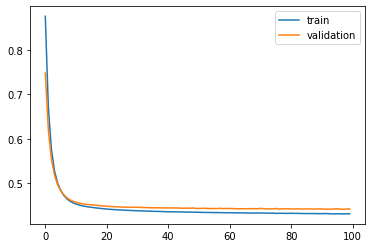

Time to train LSTM:  130.2430877685547
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 19s - loss: 0.9045 - val_loss: 0.7438

Epoch 00001: val_loss improved from inf to 0.74376, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.6794 - val_loss: 0.6229

Epoch 00002: val_loss improved from 0.74376 to 0.62293, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5911 - val_loss: 0.5591

Epoch 00003: val_loss improved from 0.62293 to 0.55911, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5423 - val_loss: 0.5219

Epoch 00004: val_loss improved from 0.55911 to 0.52188, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5128 - val_loss: 0.4980

Epoch 00005: val_loss improved from 0.52188 to 0.49804, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4937 - val_loss: 0.4821

Epoch 00006: val_loss improved from 0.49804 to 0.48205, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4804 - val_loss: 0.4710

Epoc


Epoch 00066: val_loss did not improve from 0.43887
Epoch 67/100
 - 1s - loss: 0.4378 - val_loss: 0.4390

Epoch 00067: val_loss did not improve from 0.43887
Epoch 68/100
 - 1s - loss: 0.4377 - val_loss: 0.4392

Epoch 00068: val_loss did not improve from 0.43887
Epoch 69/100
 - 1s - loss: 0.4378 - val_loss: 0.4390

Epoch 00069: val_loss did not improve from 0.43887
Epoch 70/100
 - 1s - loss: 0.4376 - val_loss: 0.4391

Epoch 00070: val_loss did not improve from 0.43887
Epoch 71/100
 - 1s - loss: 0.4377 - val_loss: 0.4393

Epoch 00071: val_loss did not improve from 0.43887
Epoch 72/100
 - 1s - loss: 0.4376 - val_loss: 0.4389

Epoch 00072: val_loss did not improve from 0.43887
Epoch 73/100
 - 1s - loss: 0.4377 - val_loss: 0.4392

Epoch 00073: val_loss did not improve from 0.43887
Epoch 74/100
 - 1s - loss: 0.4374 - val_loss: 0.4392

Epoch 00074: val_loss did not improve from 0.43887
Epoch 75/100
 - 1s - loss: 0.4375 - val_loss: 0.4390

Epoch 00075: val_loss did not improve from 0.43887
Epo

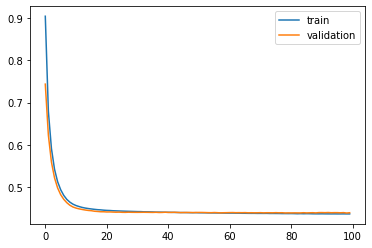

Time to train LSTM:  128.6237633228302
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 18s - loss: 0.9900 - val_loss: 0.8042

Epoch 00001: val_loss improved from inf to 0.80417, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7164 - val_loss: 0.6434

Epoch 00002: val_loss improved from 0.80417 to 0.64344, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6019 - val_loss: 0.5727

Epoch 00003: val_loss improved from 0.64344 to 0.57265, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5492 - val_loss: 0.5347

Epoch 00004: val_loss improved from 0.57265 to 0.53472, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5185 - val_loss: 0.5108

Epoch 00005: val_loss improved from 0.53472 to 0.51081, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4987 - val_loss: 0.4949

Epoch 00006: val_loss improved from 0.51081 to 0.49489, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4850 - val_loss: 0.4835

Epoc

 - 1s - loss: 0.4365 - val_loss: 0.4436

Epoch 00063: val_loss did not improve from 0.44354
Epoch 64/100
 - 1s - loss: 0.4364 - val_loss: 0.4438

Epoch 00064: val_loss did not improve from 0.44354
Epoch 65/100
 - 1s - loss: 0.4364 - val_loss: 0.4435

Epoch 00065: val_loss improved from 0.44354 to 0.44353, saving model to val_weights5.hdf5
Epoch 66/100
 - 1s - loss: 0.4363 - val_loss: 0.4439

Epoch 00066: val_loss did not improve from 0.44353
Epoch 67/100
 - 1s - loss: 0.4364 - val_loss: 0.4439

Epoch 00067: val_loss did not improve from 0.44353
Epoch 68/100
 - 1s - loss: 0.4361 - val_loss: 0.4438

Epoch 00068: val_loss did not improve from 0.44353
Epoch 69/100
 - 1s - loss: 0.4361 - val_loss: 0.4439

Epoch 00069: val_loss did not improve from 0.44353
Epoch 70/100
 - 1s - loss: 0.4359 - val_loss: 0.4436

Epoch 00070: val_loss did not improve from 0.44353
Epoch 71/100
 - 1s - loss: 0.4359 - val_loss: 0.4438

Epoch 00071: val_loss did not improve from 0.44353
Epoch 72/100
 - 1s - loss: 0.

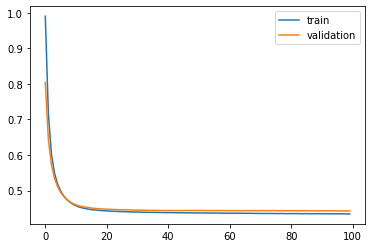

Time to train LSTM:  125.46565365791321
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 19s - loss: 0.8424 - val_loss: 0.7084

Epoch 00001: val_loss improved from inf to 0.70838, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6485 - val_loss: 0.5973

Epoch 00002: val_loss improved from 0.70838 to 0.59726, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5690 - val_loss: 0.5437

Epoch 00003: val_loss improved from 0.59726 to 0.54365, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5272 - val_loss: 0.5122

Epoch 00004: val_loss improved from 0.54365 to 0.51225, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5022 - val_loss: 0.4924

Epoch 00005: val_loss improved from 0.51225 to 0.49235, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4857 - val_loss: 0.4784

Epoch 00006: val_loss improved from 0.49235 to 0.47841, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4738 - val_loss: 0.4690

Epo

 - 1s - loss: 0.4357 - val_loss: 0.4402

Epoch 00063: val_loss improved from 0.44064 to 0.44020, saving model to val_weights1.hdf5
Epoch 64/100
 - 1s - loss: 0.4356 - val_loss: 0.4402

Epoch 00064: val_loss did not improve from 0.44020
Epoch 65/100
 - 1s - loss: 0.4356 - val_loss: 0.4402

Epoch 00065: val_loss improved from 0.44020 to 0.44016, saving model to val_weights1.hdf5
Epoch 66/100
 - 1s - loss: 0.4355 - val_loss: 0.4397

Epoch 00066: val_loss improved from 0.44016 to 0.43967, saving model to val_weights1.hdf5
Epoch 67/100
 - 1s - loss: 0.4353 - val_loss: 0.4395

Epoch 00067: val_loss improved from 0.43967 to 0.43948, saving model to val_weights1.hdf5
Epoch 68/100
 - 1s - loss: 0.4353 - val_loss: 0.4394

Epoch 00068: val_loss improved from 0.43948 to 0.43938, saving model to val_weights1.hdf5
Epoch 69/100
 - 1s - loss: 0.4351 - val_loss: 0.4392

Epoch 00069: val_loss improved from 0.43938 to 0.43918, saving model to val_weights1.hdf5
Epoch 70/100
 - 1s - loss: 0.4350 - val_loss

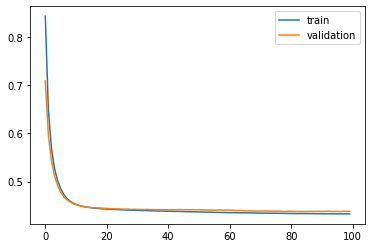

Time to train LSTM:  127.27697110176086
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 21s - loss: 0.8686 - val_loss: 0.7195

Epoch 00001: val_loss improved from inf to 0.71947, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6568 - val_loss: 0.5985

Epoch 00002: val_loss improved from 0.71947 to 0.59854, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5715 - val_loss: 0.5410

Epoch 00003: val_loss improved from 0.59854 to 0.54100, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5276 - val_loss: 0.5097

Epoch 00004: val_loss improved from 0.54100 to 0.50968, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5022 - val_loss: 0.4908

Epoch 00005: val_loss improved from 0.50968 to 0.49075, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4862 - val_loss: 0.4783

Epoch 00006: val_loss improved from 0.49075 to 0.47829, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4754 - val_loss: 0.4696

Epo

 - 1s - loss: 0.4376 - val_loss: 0.4406

Epoch 00063: val_loss did not improve from 0.44014
Epoch 64/100
 - 1s - loss: 0.4375 - val_loss: 0.4405

Epoch 00064: val_loss did not improve from 0.44014
Epoch 65/100
 - 1s - loss: 0.4374 - val_loss: 0.4403

Epoch 00065: val_loss did not improve from 0.44014
Epoch 66/100
 - 1s - loss: 0.4374 - val_loss: 0.4407

Epoch 00066: val_loss did not improve from 0.44014
Epoch 67/100
 - 1s - loss: 0.4375 - val_loss: 0.4403

Epoch 00067: val_loss did not improve from 0.44014
Epoch 68/100
 - 1s - loss: 0.4373 - val_loss: 0.4402

Epoch 00068: val_loss did not improve from 0.44014
Epoch 69/100
 - 1s - loss: 0.4373 - val_loss: 0.4406

Epoch 00069: val_loss did not improve from 0.44014
Epoch 70/100
 - 1s - loss: 0.4373 - val_loss: 0.4403

Epoch 00070: val_loss did not improve from 0.44014
Epoch 71/100
 - 1s - loss: 0.4372 - val_loss: 0.4406

Epoch 00071: val_loss did not improve from 0.44014
Epoch 72/100
 - 1s - loss: 0.4371 - val_loss: 0.4405

Epoch 00072: v

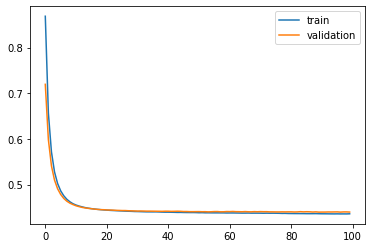

Time to train LSTM:  129.72067666053772
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 21s - loss: 0.8609 - val_loss: 0.7124

Epoch 00001: val_loss improved from inf to 0.71238, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6482 - val_loss: 0.6008

Epoch 00002: val_loss improved from 0.71238 to 0.60080, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5692 - val_loss: 0.5471

Epoch 00003: val_loss improved from 0.60080 to 0.54709, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5276 - val_loss: 0.5163

Epoch 00004: val_loss improved from 0.54709 to 0.51634, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5031 - val_loss: 0.4974

Epoch 00005: val_loss improved from 0.51634 to 0.49741, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4872 - val_loss: 0.4844

Epoch 00006: val_loss improved from 0.49741 to 0.48440, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4756 - val_loss: 0.4746

Epo

 - 1s - loss: 0.4363 - val_loss: 0.4481

Epoch 00066: val_loss did not improve from 0.44746
Epoch 67/100
 - 1s - loss: 0.4364 - val_loss: 0.4478

Epoch 00067: val_loss did not improve from 0.44746
Epoch 68/100
 - 1s - loss: 0.4362 - val_loss: 0.4478

Epoch 00068: val_loss did not improve from 0.44746
Epoch 69/100
 - 1s - loss: 0.4362 - val_loss: 0.4478

Epoch 00069: val_loss did not improve from 0.44746
Epoch 70/100
 - 1s - loss: 0.4362 - val_loss: 0.4479

Epoch 00070: val_loss did not improve from 0.44746
Epoch 71/100
 - 1s - loss: 0.4360 - val_loss: 0.4476

Epoch 00071: val_loss did not improve from 0.44746
Epoch 72/100
 - 1s - loss: 0.4360 - val_loss: 0.4477

Epoch 00072: val_loss did not improve from 0.44746
Epoch 73/100
 - 1s - loss: 0.4360 - val_loss: 0.4473

Epoch 00073: val_loss improved from 0.44746 to 0.44728, saving model to val_weights3.hdf5
Epoch 74/100
 - 1s - loss: 0.4359 - val_loss: 0.4475

Epoch 00074: val_loss did not improve from 0.44728
Epoch 75/100
 - 1s - loss: 0.

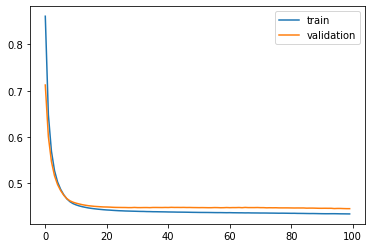

Time to train LSTM:  128.61557817459106
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 0.9638 - val_loss: 0.7962

Epoch 00001: val_loss improved from inf to 0.79617, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7110 - val_loss: 0.6318

Epoch 00002: val_loss improved from 0.79617 to 0.63182, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5950 - val_loss: 0.5606

Epoch 00003: val_loss improved from 0.63182 to 0.56060, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5450 - val_loss: 0.5240

Epoch 00004: val_loss improved from 0.56060 to 0.52402, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5162 - val_loss: 0.5011

Epoch 00005: val_loss improved from 0.52402 to 0.50106, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4974 - val_loss: 0.4856

Epoch 00006: val_loss improved from 0.50106 to 0.48561, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4842 - val_loss: 0.4737

Epo

 - 1s - loss: 0.4355 - val_loss: 0.4378

Epoch 00065: val_loss did not improve from 0.43770
Epoch 66/100
 - 1s - loss: 0.4354 - val_loss: 0.4378

Epoch 00066: val_loss did not improve from 0.43770
Epoch 67/100
 - 1s - loss: 0.4354 - val_loss: 0.4380

Epoch 00067: val_loss did not improve from 0.43770
Epoch 68/100
 - 1s - loss: 0.4352 - val_loss: 0.4377

Epoch 00068: val_loss improved from 0.43770 to 0.43765, saving model to val_weights4.hdf5
Epoch 69/100
 - 1s - loss: 0.4351 - val_loss: 0.4377

Epoch 00069: val_loss did not improve from 0.43765
Epoch 70/100
 - 1s - loss: 0.4350 - val_loss: 0.4378

Epoch 00070: val_loss did not improve from 0.43765
Epoch 71/100
 - 1s - loss: 0.4350 - val_loss: 0.4376

Epoch 00071: val_loss improved from 0.43765 to 0.43758, saving model to val_weights4.hdf5
Epoch 72/100
 - 1s - loss: 0.4349 - val_loss: 0.4376

Epoch 00072: val_loss did not improve from 0.43758
Epoch 73/100
 - 1s - loss: 0.4348 - val_loss: 0.4376

Epoch 00073: val_loss did not improve fro

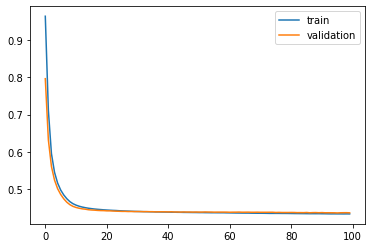

Time to train LSTM:  118.40002775192261
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 21s - loss: 0.8985 - val_loss: 0.7477

Epoch 00001: val_loss improved from inf to 0.74769, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6678 - val_loss: 0.6049

Epoch 00002: val_loss improved from 0.74769 to 0.60492, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5703 - val_loss: 0.5465

Epoch 00003: val_loss improved from 0.60492 to 0.54646, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5257 - val_loss: 0.5148

Epoch 00004: val_loss improved from 0.54646 to 0.51479, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5008 - val_loss: 0.4957

Epoch 00005: val_loss improved from 0.51479 to 0.49567, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4850 - val_loss: 0.4827

Epoch 00006: val_loss improved from 0.49567 to 0.48273, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4737 - val_loss: 0.4731

Epo

 - 1s - loss: 0.4365 - val_loss: 0.4454

Epoch 00064: val_loss did not improve from 0.44496
Epoch 65/100
 - 1s - loss: 0.4363 - val_loss: 0.4453

Epoch 00065: val_loss did not improve from 0.44496
Epoch 66/100
 - 1s - loss: 0.4363 - val_loss: 0.4454

Epoch 00066: val_loss did not improve from 0.44496
Epoch 67/100
 - 1s - loss: 0.4361 - val_loss: 0.4452

Epoch 00067: val_loss did not improve from 0.44496
Epoch 68/100
 - 1s - loss: 0.4361 - val_loss: 0.4451

Epoch 00068: val_loss did not improve from 0.44496
Epoch 69/100
 - 1s - loss: 0.4360 - val_loss: 0.4451

Epoch 00069: val_loss did not improve from 0.44496
Epoch 70/100
 - 1s - loss: 0.4358 - val_loss: 0.4450

Epoch 00070: val_loss did not improve from 0.44496
Epoch 71/100
 - 1s - loss: 0.4357 - val_loss: 0.4452

Epoch 00071: val_loss did not improve from 0.44496
Epoch 72/100
 - 1s - loss: 0.4358 - val_loss: 0.4448

Epoch 00072: val_loss improved from 0.44496 to 0.44477, saving model to val_weights5.hdf5
Epoch 73/100
 - 1s - loss: 0.

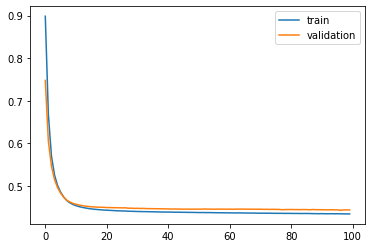

Time to train LSTM:  117.09271311759949


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f8e90d07978>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 23s - loss: 0.8885 - val_loss: 0.7159

Epoch 00001: val_loss improved from inf to 0.71594, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6593 - val_loss: 0.6082

Epoch 00002: val_loss improved from 0.71594 to 0.60822, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5821 - val_loss: 0.5562

Epoch 00003: val_loss improved from 0.60822 to 0.55619, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5388 - val_loss: 0.5227

Epoch 00004: val_loss improved from 0.55619 to 0.52273, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5111 - val_loss: 0.5007

Epoch 00005: val_loss improved from 0.52273 to 0.50069, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4927 - val_loss: 0.4856

Epoch 00006: val_loss improved from 0.50069 to 0.48559, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4802 - val_loss: 0.4754

Epoch 00007: val_loss improved from 0.48559

 - 1s - loss: 0.4360 - val_loss: 0.4386

Epoch 00063: val_loss did not improve from 0.43839
Epoch 64/100
 - 1s - loss: 0.4359 - val_loss: 0.4384

Epoch 00064: val_loss did not improve from 0.43839
Epoch 65/100
 - 1s - loss: 0.4358 - val_loss: 0.4382

Epoch 00065: val_loss improved from 0.43839 to 0.43825, saving model to val_weights1.hdf5
Epoch 66/100
 - 1s - loss: 0.4357 - val_loss: 0.4389

Epoch 00066: val_loss did not improve from 0.43825
Epoch 67/100
 - 1s - loss: 0.4357 - val_loss: 0.4383

Epoch 00067: val_loss did not improve from 0.43825
Epoch 68/100
 - 1s - loss: 0.4357 - val_loss: 0.4386

Epoch 00068: val_loss did not improve from 0.43825
Epoch 69/100
 - 1s - loss: 0.4357 - val_loss: 0.4386

Epoch 00069: val_loss did not improve from 0.43825
Epoch 70/100
 - 1s - loss: 0.4356 - val_loss: 0.4384

Epoch 00070: val_loss did not improve from 0.43825
Epoch 71/100
 - 1s - loss: 0.4357 - val_loss: 0.4386

Epoch 00071: val_loss did not improve from 0.43825
Epoch 72/100
 - 1s - loss: 0.

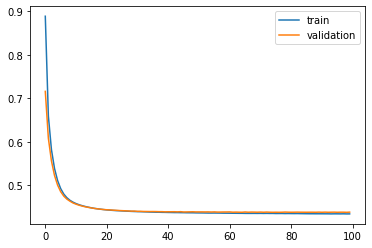

Time to train LSTM:  134.16278076171875
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 25s - loss: 0.8632 - val_loss: 0.7119

Epoch 00001: val_loss improved from inf to 0.71194, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6510 - val_loss: 0.5959

Epoch 00002: val_loss improved from 0.71194 to 0.59589, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5671 - val_loss: 0.5405

Epoch 00003: val_loss improved from 0.59589 to 0.54054, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5249 - val_loss: 0.5096

Epoch 00004: val_loss improved from 0.54054 to 0.50960, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5004 - val_loss: 0.4910

Epoch 00005: val_loss improved from 0.50960 to 0.49105, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4852 - val_loss: 0.4786

Epoch 00006: val_loss improved from 0.49105 to 0.47858, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4748 - val_loss: 0.4700

Epo

 - 1s - loss: 0.4349 - val_loss: 0.4387

Epoch 00062: val_loss did not improve from 0.43835
Epoch 63/100
 - 1s - loss: 0.4348 - val_loss: 0.4382

Epoch 00063: val_loss improved from 0.43835 to 0.43823, saving model to val_weights2.hdf5
Epoch 64/100
 - 1s - loss: 0.4347 - val_loss: 0.4384

Epoch 00064: val_loss did not improve from 0.43823
Epoch 65/100
 - 1s - loss: 0.4346 - val_loss: 0.4383

Epoch 00065: val_loss did not improve from 0.43823
Epoch 66/100
 - 1s - loss: 0.4345 - val_loss: 0.4383

Epoch 00066: val_loss did not improve from 0.43823
Epoch 67/100
 - 1s - loss: 0.4345 - val_loss: 0.4384

Epoch 00067: val_loss did not improve from 0.43823
Epoch 68/100
 - 1s - loss: 0.4345 - val_loss: 0.4382

Epoch 00068: val_loss did not improve from 0.43823
Epoch 69/100
 - 1s - loss: 0.4344 - val_loss: 0.4382

Epoch 00069: val_loss improved from 0.43823 to 0.43818, saving model to val_weights2.hdf5
Epoch 70/100
 - 1s - loss: 0.4343 - val_loss: 0.4382

Epoch 00070: val_loss improved from 0.438

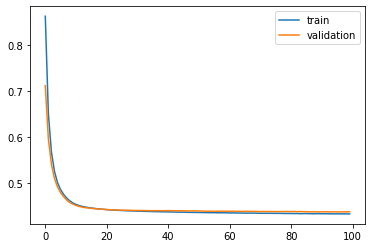

Time to train LSTM:  133.44732213020325
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 22s - loss: 0.8131 - val_loss: 0.6883

Epoch 00001: val_loss improved from inf to 0.68827, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6351 - val_loss: 0.5945

Epoch 00002: val_loss improved from 0.68827 to 0.59446, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5666 - val_loss: 0.5467

Epoch 00003: val_loss improved from 0.59446 to 0.54668, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5288 - val_loss: 0.5185

Epoch 00004: val_loss improved from 0.54668 to 0.51854, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5058 - val_loss: 0.5012

Epoch 00005: val_loss improved from 0.51854 to 0.50121, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4906 - val_loss: 0.4892

Epoch 00006: val_loss improved from 0.50121 to 0.48915, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4797 - val_loss: 0.4799

Epo

 - 1s - loss: 0.4351 - val_loss: 0.4467

Epoch 00063: val_loss did not improve from 0.44623
Epoch 64/100
 - 1s - loss: 0.4351 - val_loss: 0.4467

Epoch 00064: val_loss did not improve from 0.44623
Epoch 65/100
 - 1s - loss: 0.4351 - val_loss: 0.4471

Epoch 00065: val_loss did not improve from 0.44623
Epoch 66/100
 - 1s - loss: 0.4350 - val_loss: 0.4469

Epoch 00066: val_loss did not improve from 0.44623
Epoch 67/100
 - 1s - loss: 0.4349 - val_loss: 0.4470

Epoch 00067: val_loss did not improve from 0.44623
Epoch 68/100
 - 1s - loss: 0.4348 - val_loss: 0.4470

Epoch 00068: val_loss did not improve from 0.44623
Epoch 69/100
 - 1s - loss: 0.4346 - val_loss: 0.4472

Epoch 00069: val_loss did not improve from 0.44623
Epoch 70/100
 - 1s - loss: 0.4345 - val_loss: 0.4467

Epoch 00070: val_loss did not improve from 0.44623
Epoch 71/100
 - 1s - loss: 0.4345 - val_loss: 0.4471

Epoch 00071: val_loss did not improve from 0.44623
Epoch 72/100
 - 1s - loss: 0.4346 - val_loss: 0.4471

Epoch 00072: v

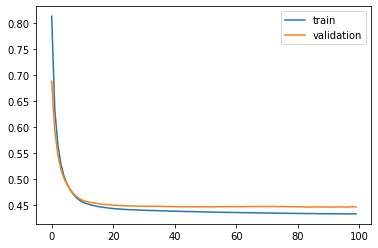

Time to train LSTM:  121.000732421875
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 23s - loss: 0.9344 - val_loss: 0.7440

Epoch 00001: val_loss improved from inf to 0.74405, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.6742 - val_loss: 0.6065

Epoch 00002: val_loss improved from 0.74405 to 0.60654, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5804 - val_loss: 0.5468

Epoch 00003: val_loss improved from 0.60654 to 0.54681, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5349 - val_loss: 0.5128

Epoch 00004: val_loss improved from 0.54681 to 0.51276, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5078 - val_loss: 0.4917

Epoch 00005: val_loss improved from 0.51276 to 0.49166, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4903 - val_loss: 0.4774

Epoch 00006: val_loss improved from 0.49166 to 0.47741, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4778 - val_loss: 0.4677

Epoch

 - 1s - loss: 0.4354 - val_loss: 0.4373

Epoch 00064: val_loss did not improve from 0.43705
Epoch 65/100
 - 1s - loss: 0.4352 - val_loss: 0.4372

Epoch 00065: val_loss did not improve from 0.43705
Epoch 66/100
 - 1s - loss: 0.4352 - val_loss: 0.4370

Epoch 00066: val_loss improved from 0.43705 to 0.43696, saving model to val_weights4.hdf5
Epoch 67/100
 - 1s - loss: 0.4352 - val_loss: 0.4369

Epoch 00067: val_loss improved from 0.43696 to 0.43693, saving model to val_weights4.hdf5
Epoch 68/100
 - 1s - loss: 0.4351 - val_loss: 0.4372

Epoch 00068: val_loss did not improve from 0.43693
Epoch 69/100
 - 1s - loss: 0.4350 - val_loss: 0.4368

Epoch 00069: val_loss improved from 0.43693 to 0.43682, saving model to val_weights4.hdf5
Epoch 70/100
 - 1s - loss: 0.4348 - val_loss: 0.4364

Epoch 00070: val_loss improved from 0.43682 to 0.43639, saving model to val_weights4.hdf5
Epoch 71/100
 - 1s - loss: 0.4348 - val_loss: 0.4370

Epoch 00071: val_loss did not improve from 0.43639
Epoch 72/100
 - 1

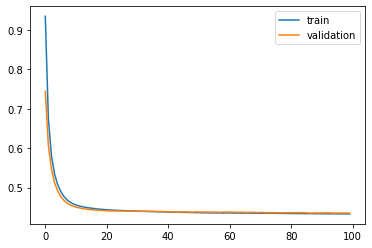

Time to train LSTM:  121.70618605613708
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 23s - loss: 0.7721 - val_loss: 0.6613

Epoch 00001: val_loss improved from inf to 0.66134, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6135 - val_loss: 0.5699

Epoch 00002: val_loss improved from 0.66134 to 0.56990, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5464 - val_loss: 0.5265

Epoch 00003: val_loss improved from 0.56990 to 0.52648, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5112 - val_loss: 0.5011

Epoch 00004: val_loss improved from 0.52648 to 0.50106, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.4907 - val_loss: 0.4858

Epoch 00005: val_loss improved from 0.50106 to 0.48575, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4779 - val_loss: 0.4759

Epoch 00006: val_loss improved from 0.48575 to 0.47589, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4691 - val_loss: 0.4691

Epo


Epoch 00064: val_loss improved from 0.44169 to 0.44164, saving model to val_weights5.hdf5
Epoch 65/100
 - 1s - loss: 0.4334 - val_loss: 0.4417

Epoch 00065: val_loss did not improve from 0.44164
Epoch 66/100
 - 1s - loss: 0.4332 - val_loss: 0.4414

Epoch 00066: val_loss improved from 0.44164 to 0.44139, saving model to val_weights5.hdf5
Epoch 67/100
 - 1s - loss: 0.4333 - val_loss: 0.4416

Epoch 00067: val_loss did not improve from 0.44139
Epoch 68/100
 - 1s - loss: 0.4331 - val_loss: 0.4416

Epoch 00068: val_loss did not improve from 0.44139
Epoch 69/100
 - 1s - loss: 0.4329 - val_loss: 0.4414

Epoch 00069: val_loss did not improve from 0.44139
Epoch 70/100
 - 1s - loss: 0.4327 - val_loss: 0.4414

Epoch 00070: val_loss did not improve from 0.44139
Epoch 71/100
 - 1s - loss: 0.4327 - val_loss: 0.4411

Epoch 00071: val_loss improved from 0.44139 to 0.44107, saving model to val_weights5.hdf5
Epoch 72/100
 - 1s - loss: 0.4325 - val_loss: 0.4414

Epoch 00072: val_loss did not improve from

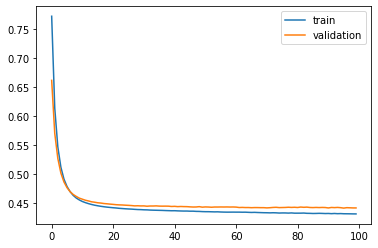

Time to train LSTM:  133.15070748329163
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 25s - loss: 1.1625 - val_loss: 0.8753

Epoch 00001: val_loss improved from inf to 0.87534, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7702 - val_loss: 0.6846

Epoch 00002: val_loss improved from 0.87534 to 0.68464, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.6343 - val_loss: 0.5933

Epoch 00003: val_loss improved from 0.68464 to 0.59327, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5669 - val_loss: 0.5436

Epoch 00004: val_loss improved from 0.59327 to 0.54362, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5285 - val_loss: 0.5137

Epoch 00005: val_loss improved from 0.54362 to 0.51366, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.5047 - val_loss: 0.4946

Epoch 00006: val_loss improved from 0.51366 to 0.49457, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4890 - val_loss: 0.4814

Epo


Epoch 00059: val_loss improved from 0.44201 to 0.44190, saving model to val_weights1.hdf5
Epoch 60/100
 - 1s - loss: 0.4398 - val_loss: 0.4417

Epoch 00060: val_loss improved from 0.44190 to 0.44174, saving model to val_weights1.hdf5
Epoch 61/100
 - 1s - loss: 0.4397 - val_loss: 0.4419

Epoch 00061: val_loss did not improve from 0.44174
Epoch 62/100
 - 1s - loss: 0.4397 - val_loss: 0.4417

Epoch 00062: val_loss did not improve from 0.44174
Epoch 63/100
 - 1s - loss: 0.4395 - val_loss: 0.4416

Epoch 00063: val_loss improved from 0.44174 to 0.44156, saving model to val_weights1.hdf5
Epoch 64/100
 - 1s - loss: 0.4394 - val_loss: 0.4416

Epoch 00064: val_loss did not improve from 0.44156
Epoch 65/100
 - 1s - loss: 0.4394 - val_loss: 0.4415

Epoch 00065: val_loss improved from 0.44156 to 0.44153, saving model to val_weights1.hdf5
Epoch 66/100
 - 1s - loss: 0.4394 - val_loss: 0.4415

Epoch 00066: val_loss improved from 0.44153 to 0.44152, saving model to val_weights1.hdf5
Epoch 67/100
 - 1s

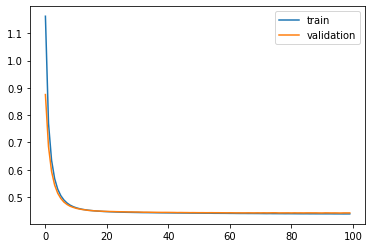

Time to train LSTM:  137.4831976890564
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 24s - loss: 0.9907 - val_loss: 0.8133

Epoch 00001: val_loss improved from inf to 0.81333, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7194 - val_loss: 0.6400

Epoch 00002: val_loss improved from 0.81333 to 0.63996, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5982 - val_loss: 0.5589

Epoch 00003: val_loss improved from 0.63996 to 0.55893, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5374 - val_loss: 0.5153

Epoch 00004: val_loss improved from 0.55893 to 0.51528, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5038 - val_loss: 0.4906

Epoch 00005: val_loss improved from 0.51528 to 0.49062, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4843 - val_loss: 0.4753

Epoch 00006: val_loss improved from 0.49062 to 0.47533, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4721 - val_loss: 0.4658

Epoc

 - 1s - loss: 0.4382 - val_loss: 0.4411

Epoch 00063: val_loss improved from 0.44132 to 0.44115, saving model to val_weights2.hdf5
Epoch 64/100
 - 1s - loss: 0.4381 - val_loss: 0.4414

Epoch 00064: val_loss did not improve from 0.44115
Epoch 65/100
 - 1s - loss: 0.4380 - val_loss: 0.4412

Epoch 00065: val_loss did not improve from 0.44115
Epoch 66/100
 - 1s - loss: 0.4380 - val_loss: 0.4412

Epoch 00066: val_loss did not improve from 0.44115
Epoch 67/100
 - 1s - loss: 0.4379 - val_loss: 0.4413

Epoch 00067: val_loss did not improve from 0.44115
Epoch 68/100
 - 1s - loss: 0.4378 - val_loss: 0.4412

Epoch 00068: val_loss did not improve from 0.44115
Epoch 69/100
 - 1s - loss: 0.4377 - val_loss: 0.4413

Epoch 00069: val_loss did not improve from 0.44115
Epoch 70/100
 - 1s - loss: 0.4377 - val_loss: 0.4412

Epoch 00070: val_loss did not improve from 0.44115
Epoch 71/100
 - 1s - loss: 0.4376 - val_loss: 0.4410

Epoch 00071: val_loss improved from 0.44115 to 0.44104, saving model to val_weig

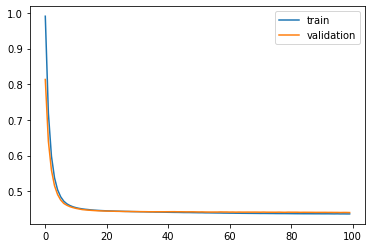

Time to train LSTM:  135.67875146865845
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 26s - loss: 0.9889 - val_loss: 0.8157

Epoch 00001: val_loss improved from inf to 0.81573, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7102 - val_loss: 0.6306

Epoch 00002: val_loss improved from 0.81573 to 0.63056, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5847 - val_loss: 0.5531

Epoch 00003: val_loss improved from 0.63056 to 0.55306, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5267 - val_loss: 0.5119

Epoch 00004: val_loss improved from 0.55306 to 0.51192, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.4952 - val_loss: 0.4888

Epoch 00005: val_loss improved from 0.51192 to 0.48875, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4770 - val_loss: 0.4750

Epoch 00006: val_loss improved from 0.48875 to 0.47505, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4661 - val_loss: 0.4671

Epo

 - 1s - loss: 0.4372 - val_loss: 0.4466

Epoch 00064: val_loss improved from 0.44667 to 0.44657, saving model to val_weights3.hdf5
Epoch 65/100
 - 1s - loss: 0.4371 - val_loss: 0.4463

Epoch 00065: val_loss improved from 0.44657 to 0.44627, saving model to val_weights3.hdf5
Epoch 66/100
 - 1s - loss: 0.4370 - val_loss: 0.4463

Epoch 00066: val_loss did not improve from 0.44627
Epoch 67/100
 - 1s - loss: 0.4369 - val_loss: 0.4463

Epoch 00067: val_loss did not improve from 0.44627
Epoch 68/100
 - 1s - loss: 0.4370 - val_loss: 0.4464

Epoch 00068: val_loss did not improve from 0.44627
Epoch 69/100
 - 1s - loss: 0.4369 - val_loss: 0.4464

Epoch 00069: val_loss did not improve from 0.44627
Epoch 70/100
 - 1s - loss: 0.4369 - val_loss: 0.4462

Epoch 00070: val_loss improved from 0.44627 to 0.44622, saving model to val_weights3.hdf5
Epoch 71/100
 - 1s - loss: 0.4368 - val_loss: 0.4462

Epoch 00071: val_loss improved from 0.44622 to 0.44620, saving model to val_weights3.hdf5
Epoch 72/100
 - 1

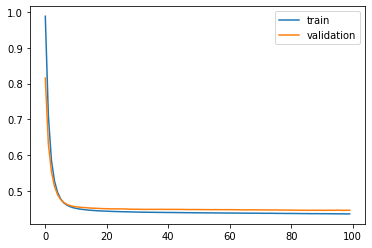

Time to train LSTM:  136.72315859794617
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 24s - loss: 0.9369 - val_loss: 0.7750

Epoch 00001: val_loss improved from inf to 0.77505, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.6984 - val_loss: 0.6191

Epoch 00002: val_loss improved from 0.77505 to 0.61915, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5848 - val_loss: 0.5429

Epoch 00003: val_loss improved from 0.61915 to 0.54290, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5279 - val_loss: 0.5028

Epoch 00004: val_loss improved from 0.54290 to 0.50275, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.4960 - val_loss: 0.4787

Epoch 00005: val_loss improved from 0.50275 to 0.47871, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4765 - val_loss: 0.4652

Epoch 00006: val_loss improved from 0.47871 to 0.46515, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4663 - val_loss: 0.4579

Epo

 - 1s - loss: 0.4376 - val_loss: 0.4394

Epoch 00065: val_loss improved from 0.43946 to 0.43943, saving model to val_weights4.hdf5
Epoch 66/100
 - 1s - loss: 0.4376 - val_loss: 0.4395

Epoch 00066: val_loss did not improve from 0.43943
Epoch 67/100
 - 1s - loss: 0.4375 - val_loss: 0.4393

Epoch 00067: val_loss improved from 0.43943 to 0.43930, saving model to val_weights4.hdf5
Epoch 68/100
 - 1s - loss: 0.4375 - val_loss: 0.4396

Epoch 00068: val_loss did not improve from 0.43930
Epoch 69/100
 - 1s - loss: 0.4374 - val_loss: 0.4394

Epoch 00069: val_loss did not improve from 0.43930
Epoch 70/100
 - 1s - loss: 0.4373 - val_loss: 0.4393

Epoch 00070: val_loss improved from 0.43930 to 0.43929, saving model to val_weights4.hdf5
Epoch 71/100
 - 1s - loss: 0.4372 - val_loss: 0.4393

Epoch 00071: val_loss improved from 0.43929 to 0.43928, saving model to val_weights4.hdf5
Epoch 72/100
 - 1s - loss: 0.4372 - val_loss: 0.4388

Epoch 00072: val_loss improved from 0.43928 to 0.43884, saving model

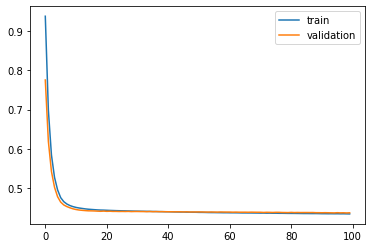

Time to train LSTM:  124.4718406200409
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 25s - loss: 1.0268 - val_loss: 0.8319

Epoch 00001: val_loss improved from inf to 0.83190, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7412 - val_loss: 0.6631

Epoch 00002: val_loss improved from 0.83190 to 0.66307, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6145 - val_loss: 0.5734

Epoch 00003: val_loss improved from 0.66307 to 0.57337, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5464 - val_loss: 0.5247

Epoch 00004: val_loss improved from 0.57337 to 0.52470, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5082 - val_loss: 0.4965

Epoch 00005: val_loss improved from 0.52470 to 0.49654, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4860 - val_loss: 0.4805

Epoch 00006: val_loss improved from 0.49654 to 0.48048, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4727 - val_loss: 0.4710

Epoc


Epoch 00062: val_loss improved from 0.44610 to 0.44599, saving model to val_weights5.hdf5
Epoch 63/100
 - 1s - loss: 0.4393 - val_loss: 0.4458

Epoch 00063: val_loss improved from 0.44599 to 0.44580, saving model to val_weights5.hdf5
Epoch 64/100
 - 1s - loss: 0.4392 - val_loss: 0.4456

Epoch 00064: val_loss improved from 0.44580 to 0.44556, saving model to val_weights5.hdf5
Epoch 65/100
 - 1s - loss: 0.4394 - val_loss: 0.4459

Epoch 00065: val_loss did not improve from 0.44556
Epoch 66/100
 - 1s - loss: 0.4392 - val_loss: 0.4461

Epoch 00066: val_loss did not improve from 0.44556
Epoch 67/100
 - 1s - loss: 0.4393 - val_loss: 0.4454

Epoch 00067: val_loss improved from 0.44556 to 0.44543, saving model to val_weights5.hdf5
Epoch 68/100
 - 1s - loss: 0.4390 - val_loss: 0.4455

Epoch 00068: val_loss did not improve from 0.44543
Epoch 69/100
 - 1s - loss: 0.4388 - val_loss: 0.4456

Epoch 00069: val_loss did not improve from 0.44543
Epoch 70/100
 - 1s - loss: 0.4388 - val_loss: 0.4456

Epo

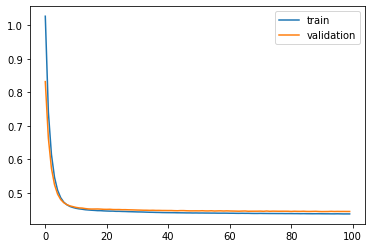

Time to train LSTM:  137.11731719970703
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 26s - loss: 0.9261 - val_loss: 0.7620

Epoch 00001: val_loss improved from inf to 0.76198, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6835 - val_loss: 0.6193

Epoch 00002: val_loss improved from 0.76198 to 0.61931, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5836 - val_loss: 0.5511

Epoch 00003: val_loss improved from 0.61931 to 0.55114, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5321 - val_loss: 0.5130

Epoch 00004: val_loss improved from 0.55114 to 0.51303, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5020 - val_loss: 0.4898

Epoch 00005: val_loss improved from 0.51303 to 0.48981, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4836 - val_loss: 0.4753

Epoch 00006: val_loss improved from 0.48981 to 0.47534, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4716 - val_loss: 0.4664

Epo

 - 1s - loss: 0.4356 - val_loss: 0.4403

Epoch 00066: val_loss did not improve from 0.43988
Epoch 67/100
 - 1s - loss: 0.4354 - val_loss: 0.4404

Epoch 00067: val_loss did not improve from 0.43988
Epoch 68/100
 - 1s - loss: 0.4355 - val_loss: 0.4405

Epoch 00068: val_loss did not improve from 0.43988
Epoch 69/100
 - 1s - loss: 0.4354 - val_loss: 0.4402

Epoch 00069: val_loss did not improve from 0.43988
Epoch 70/100
 - 1s - loss: 0.4354 - val_loss: 0.4399

Epoch 00070: val_loss improved from 0.43988 to 0.43987, saving model to val_weights1.hdf5
Epoch 71/100
 - 1s - loss: 0.4354 - val_loss: 0.4403

Epoch 00071: val_loss did not improve from 0.43987
Epoch 72/100
 - 1s - loss: 0.4353 - val_loss: 0.4402

Epoch 00072: val_loss did not improve from 0.43987
Epoch 73/100
 - 1s - loss: 0.4353 - val_loss: 0.4404

Epoch 00073: val_loss did not improve from 0.43987
Epoch 74/100
 - 1s - loss: 0.4354 - val_loss: 0.4402

Epoch 00074: val_loss did not improve from 0.43987
Epoch 75/100
 - 1s - loss: 0.

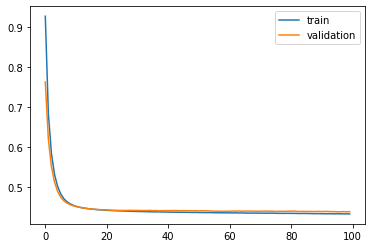

Time to train LSTM:  135.49888229370117
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 29s - loss: 0.9714 - val_loss: 0.8132

Epoch 00001: val_loss improved from inf to 0.81318, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7141 - val_loss: 0.6370

Epoch 00002: val_loss improved from 0.81318 to 0.63703, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5961 - val_loss: 0.5604

Epoch 00003: val_loss improved from 0.63703 to 0.56036, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5394 - val_loss: 0.5193

Epoch 00004: val_loss improved from 0.56036 to 0.51931, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5074 - val_loss: 0.4953

Epoch 00005: val_loss improved from 0.51931 to 0.49533, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4878 - val_loss: 0.4797

Epoch 00006: val_loss improved from 0.49533 to 0.47973, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4748 - val_loss: 0.4689

Epo

 - 1s - loss: 0.4376 - val_loss: 0.4403

Epoch 00062: val_loss did not improve from 0.43997
Epoch 63/100
 - 1s - loss: 0.4375 - val_loss: 0.4402

Epoch 00063: val_loss did not improve from 0.43997
Epoch 64/100
 - 1s - loss: 0.4373 - val_loss: 0.4400

Epoch 00064: val_loss did not improve from 0.43997
Epoch 65/100
 - 1s - loss: 0.4372 - val_loss: 0.4397

Epoch 00065: val_loss improved from 0.43997 to 0.43972, saving model to val_weights2.hdf5
Epoch 66/100
 - 1s - loss: 0.4372 - val_loss: 0.4398

Epoch 00066: val_loss did not improve from 0.43972
Epoch 67/100
 - 1s - loss: 0.4372 - val_loss: 0.4398

Epoch 00067: val_loss did not improve from 0.43972
Epoch 68/100
 - 1s - loss: 0.4372 - val_loss: 0.4400

Epoch 00068: val_loss did not improve from 0.43972
Epoch 69/100
 - 1s - loss: 0.4371 - val_loss: 0.4397

Epoch 00069: val_loss did not improve from 0.43972
Epoch 70/100
 - 1s - loss: 0.4371 - val_loss: 0.4400

Epoch 00070: val_loss did not improve from 0.43972
Epoch 71/100
 - 1s - loss: 0.

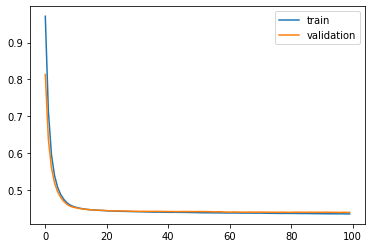

Time to train LSTM:  127.6281898021698


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f8e5ab2da90>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 0.9285 - val_loss: 0.7704

Epoch 00001: val_loss improved from inf to 0.77041, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6875 - val_loss: 0.6217

Epoch 00002: val_loss improved from 0.77041 to 0.62166, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5830 - val_loss: 0.5538

Epoch 00003: val_loss improved from 0.62166 to 0.55381, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5305 - val_loss: 0.5152

Epoch 00004: val_loss improved from 0.55381 to 0.51517, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.4999 - val_loss: 0.4921

Epoch 00005: val_loss improved from 0.51517 to 0.49212, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4806 - val_loss: 0.4769

Epoch 00006: val_loss improved from 0.49212 to 0.47694, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4683 - val_loss: 0.4685

Epoch 00007: val_loss improved from 0.47694

 - 1s - loss: 0.4349 - val_loss: 0.4447

Epoch 00062: val_loss did not improve from 0.44448
Epoch 63/100
 - 1s - loss: 0.4345 - val_loss: 0.4445

Epoch 00063: val_loss improved from 0.44448 to 0.44448, saving model to val_weights3.hdf5
Epoch 64/100
 - 1s - loss: 0.4344 - val_loss: 0.4444

Epoch 00064: val_loss improved from 0.44448 to 0.44435, saving model to val_weights3.hdf5
Epoch 65/100
 - 1s - loss: 0.4344 - val_loss: 0.4442

Epoch 00065: val_loss improved from 0.44435 to 0.44419, saving model to val_weights3.hdf5
Epoch 66/100
 - 1s - loss: 0.4342 - val_loss: 0.4439

Epoch 00066: val_loss improved from 0.44419 to 0.44385, saving model to val_weights3.hdf5
Epoch 67/100
 - 1s - loss: 0.4342 - val_loss: 0.4441

Epoch 00067: val_loss did not improve from 0.44385
Epoch 68/100
 - 1s - loss: 0.4341 - val_loss: 0.4438

Epoch 00068: val_loss improved from 0.44385 to 0.44381, saving model to val_weights3.hdf5
Epoch 69/100
 - 1s - loss: 0.4339 - val_loss: 0.4439

Epoch 00069: val_loss did not

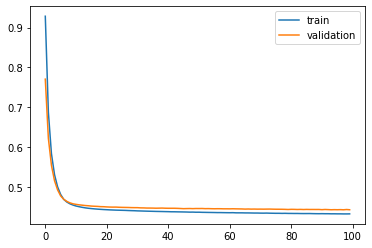

Time to train LSTM:  132.8590657711029
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 28s - loss: 0.9805 - val_loss: 0.7793

Epoch 00001: val_loss improved from inf to 0.77933, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.6971 - val_loss: 0.6272

Epoch 00002: val_loss improved from 0.77933 to 0.62718, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5939 - val_loss: 0.5578

Epoch 00003: val_loss improved from 0.62718 to 0.55784, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5416 - val_loss: 0.5181

Epoch 00004: val_loss improved from 0.55784 to 0.51812, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5106 - val_loss: 0.4940

Epoch 00005: val_loss improved from 0.51812 to 0.49398, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4910 - val_loss: 0.4778

Epoch 00006: val_loss improved from 0.49398 to 0.47785, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4776 - val_loss: 0.4677

Epoc


Epoch 00061: val_loss improved from 0.43721 to 0.43721, saving model to val_weights4.hdf5
Epoch 62/100
 - 1s - loss: 0.4372 - val_loss: 0.4371

Epoch 00062: val_loss improved from 0.43721 to 0.43714, saving model to val_weights4.hdf5
Epoch 63/100
 - 1s - loss: 0.4371 - val_loss: 0.4371

Epoch 00063: val_loss improved from 0.43714 to 0.43705, saving model to val_weights4.hdf5
Epoch 64/100
 - 1s - loss: 0.4370 - val_loss: 0.4370

Epoch 00064: val_loss improved from 0.43705 to 0.43696, saving model to val_weights4.hdf5
Epoch 65/100
 - 1s - loss: 0.4369 - val_loss: 0.4371

Epoch 00065: val_loss did not improve from 0.43696
Epoch 66/100
 - 1s - loss: 0.4368 - val_loss: 0.4369

Epoch 00066: val_loss improved from 0.43696 to 0.43691, saving model to val_weights4.hdf5
Epoch 67/100
 - 1s - loss: 0.4368 - val_loss: 0.4371

Epoch 00067: val_loss did not improve from 0.43691
Epoch 68/100
 - 1s - loss: 0.4367 - val_loss: 0.4369

Epoch 00068: val_loss improved from 0.43691 to 0.43688, saving model 

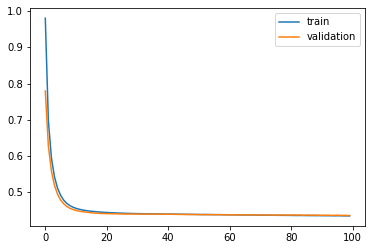

Time to train LSTM:  128.69549417495728
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 43s - loss: 0.9081 - val_loss: 0.7584

Epoch 00001: val_loss improved from inf to 0.75836, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6897 - val_loss: 0.6277

Epoch 00002: val_loss improved from 0.75836 to 0.62768, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5914 - val_loss: 0.5605

Epoch 00003: val_loss improved from 0.62768 to 0.56045, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5380 - val_loss: 0.5217

Epoch 00004: val_loss improved from 0.56045 to 0.52171, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5065 - val_loss: 0.4973

Epoch 00005: val_loss improved from 0.52171 to 0.49733, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4864 - val_loss: 0.4820

Epoch 00006: val_loss improved from 0.49733 to 0.48202, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4733 - val_loss: 0.4720

Epo


Epoch 00062: val_loss did not improve from 0.44147
Epoch 63/100
 - 1s - loss: 0.4335 - val_loss: 0.4416

Epoch 00063: val_loss did not improve from 0.44147
Epoch 64/100
 - 1s - loss: 0.4334 - val_loss: 0.4419

Epoch 00064: val_loss did not improve from 0.44147
Epoch 65/100
 - 1s - loss: 0.4333 - val_loss: 0.4413

Epoch 00065: val_loss improved from 0.44147 to 0.44129, saving model to val_weights5.hdf5
Epoch 66/100
 - 1s - loss: 0.4334 - val_loss: 0.4417

Epoch 00066: val_loss did not improve from 0.44129
Epoch 67/100
 - 1s - loss: 0.4332 - val_loss: 0.4420

Epoch 00067: val_loss did not improve from 0.44129
Epoch 68/100
 - 1s - loss: 0.4330 - val_loss: 0.4416

Epoch 00068: val_loss did not improve from 0.44129
Epoch 69/100
 - 1s - loss: 0.4329 - val_loss: 0.4413

Epoch 00069: val_loss improved from 0.44129 to 0.44126, saving model to val_weights5.hdf5
Epoch 70/100
 - 1s - loss: 0.4329 - val_loss: 0.4413

Epoch 00070: val_loss did not improve from 0.44126
Epoch 71/100
 - 1s - loss: 0.4

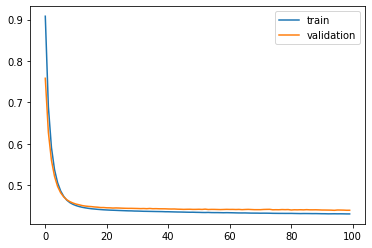

Time to train LSTM:  142.29258680343628
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 30s - loss: 0.9398 - val_loss: 0.7708

Epoch 00001: val_loss improved from inf to 0.77079, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7008 - val_loss: 0.6438

Epoch 00002: val_loss improved from 0.77079 to 0.64385, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.6081 - val_loss: 0.5799

Epoch 00003: val_loss improved from 0.64385 to 0.57987, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5582 - val_loss: 0.5407

Epoch 00004: val_loss improved from 0.57987 to 0.54071, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5267 - val_loss: 0.5150

Epoch 00005: val_loss improved from 0.54071 to 0.51500, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.5055 - val_loss: 0.4971

Epoch 00006: val_loss improved from 0.51500 to 0.49708, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4905 - val_loss: 0.4841

Epo


Epoch 00062: val_loss did not improve from 0.44038
Epoch 63/100
 - 1s - loss: 0.4362 - val_loss: 0.4411

Epoch 00063: val_loss did not improve from 0.44038
Epoch 64/100
 - 1s - loss: 0.4365 - val_loss: 0.4406

Epoch 00064: val_loss did not improve from 0.44038
Epoch 65/100
 - 1s - loss: 0.4363 - val_loss: 0.4411

Epoch 00065: val_loss did not improve from 0.44038
Epoch 66/100
 - 1s - loss: 0.4362 - val_loss: 0.4409

Epoch 00066: val_loss did not improve from 0.44038
Epoch 67/100
 - 1s - loss: 0.4360 - val_loss: 0.4409

Epoch 00067: val_loss did not improve from 0.44038
Epoch 68/100
 - 1s - loss: 0.4358 - val_loss: 0.4405

Epoch 00068: val_loss did not improve from 0.44038
Epoch 69/100
 - 1s - loss: 0.4358 - val_loss: 0.4405

Epoch 00069: val_loss did not improve from 0.44038
Epoch 70/100
 - 1s - loss: 0.4360 - val_loss: 0.4402

Epoch 00070: val_loss improved from 0.44038 to 0.44016, saving model to val_weights1.hdf5
Epoch 71/100
 - 1s - loss: 0.4358 - val_loss: 0.4405

Epoch 00071: va

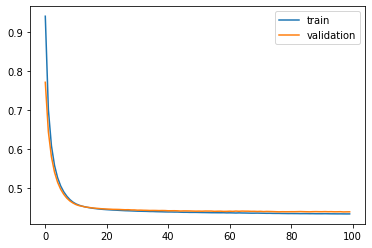

Time to train LSTM:  132.33192443847656
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 30s - loss: 1.0436 - val_loss: 0.7960

Epoch 00001: val_loss improved from inf to 0.79603, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7297 - val_loss: 0.6770

Epoch 00002: val_loss improved from 0.79603 to 0.67704, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.6397 - val_loss: 0.6083

Epoch 00003: val_loss improved from 0.67704 to 0.60833, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5852 - val_loss: 0.5653

Epoch 00004: val_loss improved from 0.60833 to 0.56528, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5491 - val_loss: 0.5360

Epoch 00005: val_loss improved from 0.56528 to 0.53595, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.5247 - val_loss: 0.5156

Epoch 00006: val_loss improved from 0.53595 to 0.51561, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.5076 - val_loss: 0.5009

Epo


Epoch 00060: val_loss did not improve from 0.43934
Epoch 61/100
 - 1s - loss: 0.4367 - val_loss: 0.4395

Epoch 00061: val_loss did not improve from 0.43934
Epoch 62/100
 - 1s - loss: 0.4365 - val_loss: 0.4394

Epoch 00062: val_loss did not improve from 0.43934
Epoch 63/100
 - 1s - loss: 0.4363 - val_loss: 0.4393

Epoch 00063: val_loss did not improve from 0.43934
Epoch 64/100
 - 1s - loss: 0.4364 - val_loss: 0.4392

Epoch 00064: val_loss improved from 0.43934 to 0.43922, saving model to val_weights2.hdf5
Epoch 65/100
 - 1s - loss: 0.4361 - val_loss: 0.4393

Epoch 00065: val_loss did not improve from 0.43922
Epoch 66/100
 - 1s - loss: 0.4361 - val_loss: 0.4391

Epoch 00066: val_loss improved from 0.43922 to 0.43911, saving model to val_weights2.hdf5
Epoch 67/100
 - 1s - loss: 0.4359 - val_loss: 0.4393

Epoch 00067: val_loss did not improve from 0.43911
Epoch 68/100
 - 1s - loss: 0.4359 - val_loss: 0.4392

Epoch 00068: val_loss did not improve from 0.43911
Epoch 69/100
 - 1s - loss: 0.4

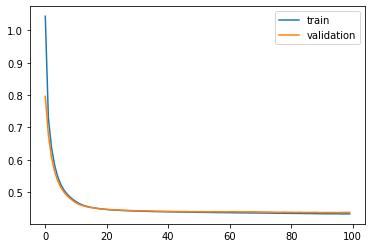

Time to train LSTM:  132.2235233783722
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 29s - loss: 0.8288 - val_loss: 0.7033

Epoch 00001: val_loss improved from inf to 0.70332, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6435 - val_loss: 0.5943

Epoch 00002: val_loss improved from 0.70332 to 0.59426, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5654 - val_loss: 0.5433

Epoch 00003: val_loss improved from 0.59426 to 0.54334, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5237 - val_loss: 0.5123

Epoch 00004: val_loss improved from 0.54334 to 0.51232, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.4981 - val_loss: 0.4926

Epoch 00005: val_loss improved from 0.51232 to 0.49255, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4812 - val_loss: 0.4787

Epoch 00006: val_loss improved from 0.49255 to 0.47868, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4692 - val_loss: 0.4689

Epoc

 - 1s - loss: 0.4346 - val_loss: 0.4443

Epoch 00061: val_loss did not improve from 0.44419
Epoch 62/100
 - 1s - loss: 0.4346 - val_loss: 0.4440

Epoch 00062: val_loss improved from 0.44419 to 0.44404, saving model to val_weights3.hdf5
Epoch 63/100
 - 1s - loss: 0.4345 - val_loss: 0.4440

Epoch 00063: val_loss improved from 0.44404 to 0.44399, saving model to val_weights3.hdf5
Epoch 64/100
 - 1s - loss: 0.4345 - val_loss: 0.4440

Epoch 00064: val_loss did not improve from 0.44399
Epoch 65/100
 - 1s - loss: 0.4343 - val_loss: 0.4440

Epoch 00065: val_loss did not improve from 0.44399
Epoch 66/100
 - 1s - loss: 0.4342 - val_loss: 0.4437

Epoch 00066: val_loss improved from 0.44399 to 0.44374, saving model to val_weights3.hdf5
Epoch 67/100
 - 1s - loss: 0.4342 - val_loss: 0.4439

Epoch 00067: val_loss did not improve from 0.44374
Epoch 68/100
 - 1s - loss: 0.4340 - val_loss: 0.4437

Epoch 00068: val_loss improved from 0.44374 to 0.44370, saving model to val_weights3.hdf5
Epoch 69/100
 - 1

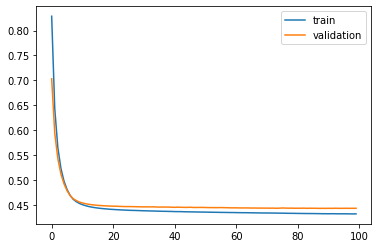

Time to train LSTM:  130.9490988254547
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 29s - loss: 0.8150 - val_loss: 0.6885

Epoch 00001: val_loss improved from inf to 0.68847, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.6392 - val_loss: 0.5918

Epoch 00002: val_loss improved from 0.68847 to 0.59178, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5676 - val_loss: 0.5406

Epoch 00003: val_loss improved from 0.59178 to 0.54058, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5275 - val_loss: 0.5091

Epoch 00004: val_loss improved from 0.54058 to 0.50915, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5026 - val_loss: 0.4885

Epoch 00005: val_loss improved from 0.50915 to 0.48849, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4860 - val_loss: 0.4745

Epoch 00006: val_loss improved from 0.48849 to 0.47448, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4739 - val_loss: 0.4643

Epoc

 - 1s - loss: 0.4364 - val_loss: 0.4400

Epoch 00067: val_loss did not improve from 0.43923
Epoch 68/100
 - 1s - loss: 0.4365 - val_loss: 0.4394

Epoch 00068: val_loss did not improve from 0.43923
Epoch 69/100
 - 1s - loss: 0.4363 - val_loss: 0.4397

Epoch 00069: val_loss did not improve from 0.43923
Epoch 70/100
 - 1s - loss: 0.4363 - val_loss: 0.4399

Epoch 00070: val_loss did not improve from 0.43923
Epoch 71/100
 - 1s - loss: 0.4363 - val_loss: 0.4404

Epoch 00071: val_loss did not improve from 0.43923
Epoch 72/100
 - 1s - loss: 0.4363 - val_loss: 0.4396

Epoch 00072: val_loss did not improve from 0.43923
Epoch 73/100
 - 1s - loss: 0.4360 - val_loss: 0.4400

Epoch 00073: val_loss did not improve from 0.43923
Epoch 74/100
 - 1s - loss: 0.4361 - val_loss: 0.4399

Epoch 00074: val_loss did not improve from 0.43923
Epoch 75/100
 - 1s - loss: 0.4361 - val_loss: 0.4393

Epoch 00075: val_loss did not improve from 0.43923
Epoch 76/100
 - 1s - loss: 0.4359 - val_loss: 0.4393

Epoch 00076: v

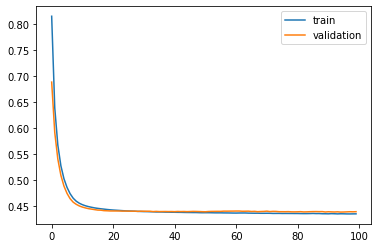

Time to train LSTM:  132.86999368667603
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 32s - loss: 0.8755 - val_loss: 0.7302

Epoch 00001: val_loss improved from inf to 0.73016, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6648 - val_loss: 0.6120

Epoch 00002: val_loss improved from 0.73016 to 0.61202, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5791 - val_loss: 0.5536

Epoch 00003: val_loss improved from 0.61202 to 0.55356, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5330 - val_loss: 0.5199

Epoch 00004: val_loss improved from 0.55356 to 0.51991, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5052 - val_loss: 0.4986

Epoch 00005: val_loss improved from 0.51991 to 0.49859, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4869 - val_loss: 0.4836

Epoch 00006: val_loss improved from 0.49859 to 0.48357, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4746 - val_loss: 0.4736

Epo

 - 1s - loss: 0.4341 - val_loss: 0.4409

Epoch 00062: val_loss improved from 0.44100 to 0.44094, saving model to val_weights5.hdf5
Epoch 63/100
 - 1s - loss: 0.4338 - val_loss: 0.4406

Epoch 00063: val_loss improved from 0.44094 to 0.44063, saving model to val_weights5.hdf5
Epoch 64/100
 - 1s - loss: 0.4338 - val_loss: 0.4408

Epoch 00064: val_loss did not improve from 0.44063
Epoch 65/100
 - 1s - loss: 0.4338 - val_loss: 0.4406

Epoch 00065: val_loss improved from 0.44063 to 0.44056, saving model to val_weights5.hdf5
Epoch 66/100
 - 1s - loss: 0.4334 - val_loss: 0.4403

Epoch 00066: val_loss improved from 0.44056 to 0.44034, saving model to val_weights5.hdf5
Epoch 67/100
 - 1s - loss: 0.4334 - val_loss: 0.4404

Epoch 00067: val_loss did not improve from 0.44034
Epoch 68/100
 - 1s - loss: 0.4333 - val_loss: 0.4401

Epoch 00068: val_loss improved from 0.44034 to 0.44011, saving model to val_weights5.hdf5
Epoch 69/100
 - 1s - loss: 0.4333 - val_loss: 0.4399

Epoch 00069: val_loss improve

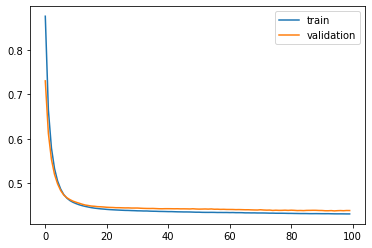

Time to train LSTM:  145.77371501922607
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 33s - loss: 1.0232 - val_loss: 0.8296

Epoch 00001: val_loss improved from inf to 0.82965, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7229 - val_loss: 0.6355

Epoch 00002: val_loss improved from 0.82965 to 0.63546, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5908 - val_loss: 0.5500

Epoch 00003: val_loss improved from 0.63546 to 0.54997, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5293 - val_loss: 0.5075

Epoch 00004: val_loss improved from 0.54997 to 0.50746, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.4973 - val_loss: 0.4845

Epoch 00005: val_loss improved from 0.50746 to 0.48449, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4792 - val_loss: 0.4708

Epoch 00006: val_loss improved from 0.48449 to 0.47083, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4679 - val_loss: 0.4624

Epo

 - 1s - loss: 0.4384 - val_loss: 0.4409

Epoch 00060: val_loss did not improve from 0.44085
Epoch 61/100
 - 1s - loss: 0.4384 - val_loss: 0.4405

Epoch 00061: val_loss improved from 0.44085 to 0.44049, saving model to val_weights1.hdf5
Epoch 62/100
 - 1s - loss: 0.4384 - val_loss: 0.4410

Epoch 00062: val_loss did not improve from 0.44049
Epoch 63/100
 - 1s - loss: 0.4383 - val_loss: 0.4406

Epoch 00063: val_loss did not improve from 0.44049
Epoch 64/100
 - 1s - loss: 0.4384 - val_loss: 0.4406

Epoch 00064: val_loss did not improve from 0.44049
Epoch 65/100
 - 1s - loss: 0.4382 - val_loss: 0.4404

Epoch 00065: val_loss improved from 0.44049 to 0.44042, saving model to val_weights1.hdf5
Epoch 66/100
 - 1s - loss: 0.4381 - val_loss: 0.4407

Epoch 00066: val_loss did not improve from 0.44042
Epoch 67/100
 - 1s - loss: 0.4381 - val_loss: 0.4405

Epoch 00067: val_loss did not improve from 0.44042
Epoch 68/100
 - 1s - loss: 0.4382 - val_loss: 0.4405

Epoch 00068: val_loss did not improve fro

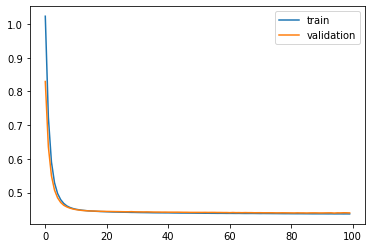

Time to train LSTM:  134.2614462375641
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 31s - loss: 1.1287 - val_loss: 0.8738

Epoch 00001: val_loss improved from inf to 0.87377, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7812 - val_loss: 0.6890

Epoch 00002: val_loss improved from 0.87377 to 0.68904, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.6423 - val_loss: 0.5945

Epoch 00003: val_loss improved from 0.68904 to 0.59446, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5684 - val_loss: 0.5407

Epoch 00004: val_loss improved from 0.59446 to 0.54070, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5258 - val_loss: 0.5094

Epoch 00005: val_loss improved from 0.54070 to 0.50944, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.5009 - val_loss: 0.4907

Epoch 00006: val_loss improved from 0.50944 to 0.49071, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4854 - val_loss: 0.4781

Epoc

 - 1s - loss: 0.4374 - val_loss: 0.4394

Epoch 00062: val_loss did not improve from 0.43934
Epoch 63/100
 - 1s - loss: 0.4375 - val_loss: 0.4395

Epoch 00063: val_loss did not improve from 0.43934
Epoch 64/100
 - 1s - loss: 0.4375 - val_loss: 0.4392

Epoch 00064: val_loss improved from 0.43934 to 0.43917, saving model to val_weights2.hdf5
Epoch 65/100
 - 1s - loss: 0.4374 - val_loss: 0.4391

Epoch 00065: val_loss improved from 0.43917 to 0.43908, saving model to val_weights2.hdf5
Epoch 66/100
 - 1s - loss: 0.4374 - val_loss: 0.4391

Epoch 00066: val_loss did not improve from 0.43908
Epoch 67/100
 - 1s - loss: 0.4373 - val_loss: 0.4389

Epoch 00067: val_loss improved from 0.43908 to 0.43892, saving model to val_weights2.hdf5
Epoch 68/100
 - 1s - loss: 0.4372 - val_loss: 0.4394

Epoch 00068: val_loss did not improve from 0.43892
Epoch 69/100
 - 1s - loss: 0.4372 - val_loss: 0.4391

Epoch 00069: val_loss did not improve from 0.43892
Epoch 70/100
 - 1s - loss: 0.4371 - val_loss: 0.4395

Ep

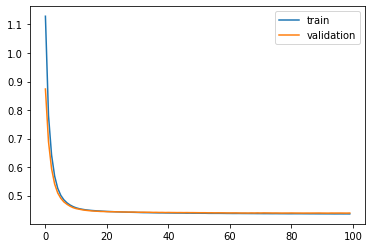

Time to train LSTM:  131.5188558101654
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 32s - loss: 1.0638 - val_loss: 0.8592

Epoch 00001: val_loss improved from inf to 0.85916, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7444 - val_loss: 0.6600

Epoch 00002: val_loss improved from 0.85916 to 0.65997, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.6080 - val_loss: 0.5717

Epoch 00003: val_loss improved from 0.65997 to 0.57173, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5401 - val_loss: 0.5217

Epoch 00004: val_loss improved from 0.57173 to 0.52173, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5022 - val_loss: 0.4933

Epoch 00005: val_loss improved from 0.52173 to 0.49325, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4806 - val_loss: 0.4765

Epoch 00006: val_loss improved from 0.49325 to 0.47649, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4679 - val_loss: 0.4676

Epoc

 - 1s - loss: 0.4366 - val_loss: 0.4459

Epoch 00063: val_loss did not improve from 0.44584
Epoch 64/100
 - 1s - loss: 0.4365 - val_loss: 0.4462

Epoch 00064: val_loss did not improve from 0.44584
Epoch 65/100
 - 1s - loss: 0.4364 - val_loss: 0.4459

Epoch 00065: val_loss did not improve from 0.44584
Epoch 66/100
 - 1s - loss: 0.4363 - val_loss: 0.4459

Epoch 00066: val_loss did not improve from 0.44584
Epoch 67/100
 - 1s - loss: 0.4361 - val_loss: 0.4462

Epoch 00067: val_loss did not improve from 0.44584
Epoch 68/100
 - 1s - loss: 0.4361 - val_loss: 0.4458

Epoch 00068: val_loss improved from 0.44584 to 0.44577, saving model to val_weights3.hdf5
Epoch 69/100
 - 1s - loss: 0.4360 - val_loss: 0.4459

Epoch 00069: val_loss did not improve from 0.44577
Epoch 70/100
 - 1s - loss: 0.4359 - val_loss: 0.4455

Epoch 00070: val_loss improved from 0.44577 to 0.44553, saving model to val_weights3.hdf5
Epoch 71/100
 - 1s - loss: 0.4357 - val_loss: 0.4457

Epoch 00071: val_loss did not improve fro

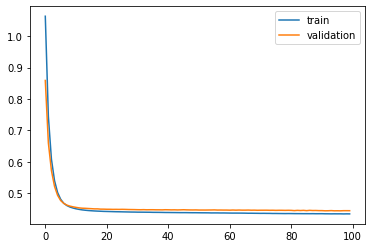

Time to train LSTM:  134.91753339767456
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 32s - loss: 1.0964 - val_loss: 0.8707

Epoch 00001: val_loss improved from inf to 0.87074, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7575 - val_loss: 0.6578

Epoch 00002: val_loss improved from 0.87074 to 0.65777, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6101 - val_loss: 0.5607

Epoch 00003: val_loss improved from 0.65777 to 0.56067, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5404 - val_loss: 0.5118

Epoch 00004: val_loss improved from 0.56067 to 0.51183, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5034 - val_loss: 0.4847

Epoch 00005: val_loss improved from 0.51183 to 0.48468, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4828 - val_loss: 0.4690

Epoch 00006: val_loss improved from 0.48468 to 0.46896, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4705 - val_loss: 0.4597

Epo

 - 1s - loss: 0.4388 - val_loss: 0.4387

Epoch 00065: val_loss did not improve from 0.43851
Epoch 66/100
 - 1s - loss: 0.4388 - val_loss: 0.4388

Epoch 00066: val_loss did not improve from 0.43851
Epoch 67/100
 - 1s - loss: 0.4389 - val_loss: 0.4386

Epoch 00067: val_loss did not improve from 0.43851
Epoch 68/100
 - 1s - loss: 0.4387 - val_loss: 0.4390

Epoch 00068: val_loss did not improve from 0.43851
Epoch 69/100
 - 1s - loss: 0.4385 - val_loss: 0.4389

Epoch 00069: val_loss did not improve from 0.43851
Epoch 70/100
 - 1s - loss: 0.4385 - val_loss: 0.4386

Epoch 00070: val_loss did not improve from 0.43851
Epoch 71/100
 - 1s - loss: 0.4384 - val_loss: 0.4383

Epoch 00071: val_loss improved from 0.43851 to 0.43832, saving model to val_weights4.hdf5
Epoch 72/100
 - 1s - loss: 0.4384 - val_loss: 0.4384

Epoch 00072: val_loss did not improve from 0.43832
Epoch 73/100
 - 1s - loss: 0.4383 - val_loss: 0.4386

Epoch 00073: val_loss did not improve from 0.43832
Epoch 74/100
 - 1s - loss: 0.

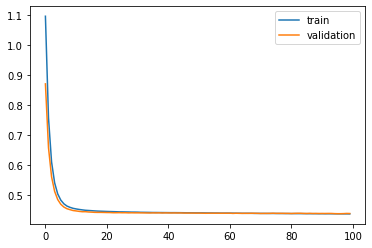

Time to train LSTM:  135.85129642486572
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 34s - loss: 1.0228 - val_loss: 0.8200

Epoch 00001: val_loss improved from inf to 0.81995, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7316 - val_loss: 0.6599

Epoch 00002: val_loss improved from 0.81995 to 0.65993, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6146 - val_loss: 0.5773

Epoch 00003: val_loss improved from 0.65993 to 0.57725, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5497 - val_loss: 0.5292

Epoch 00004: val_loss improved from 0.57725 to 0.52925, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5120 - val_loss: 0.5010

Epoch 00005: val_loss improved from 0.52925 to 0.50097, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4894 - val_loss: 0.4840

Epoch 00006: val_loss improved from 0.50097 to 0.48399, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4758 - val_loss: 0.4736

Epo


Epoch 00067: val_loss improved from 0.44615 to 0.44605, saving model to val_weights5.hdf5
Epoch 68/100
 - 1s - loss: 0.4372 - val_loss: 0.4462

Epoch 00068: val_loss did not improve from 0.44605
Epoch 69/100
 - 1s - loss: 0.4371 - val_loss: 0.4462

Epoch 00069: val_loss did not improve from 0.44605
Epoch 70/100
 - 1s - loss: 0.4371 - val_loss: 0.4465

Epoch 00070: val_loss did not improve from 0.44605
Epoch 71/100
 - 1s - loss: 0.4370 - val_loss: 0.4461

Epoch 00071: val_loss did not improve from 0.44605
Epoch 72/100
 - 1s - loss: 0.4370 - val_loss: 0.4465

Epoch 00072: val_loss did not improve from 0.44605
Epoch 73/100
 - 1s - loss: 0.4368 - val_loss: 0.4459

Epoch 00073: val_loss improved from 0.44605 to 0.44586, saving model to val_weights5.hdf5
Epoch 74/100
 - 1s - loss: 0.4370 - val_loss: 0.4465

Epoch 00074: val_loss did not improve from 0.44586
Epoch 75/100
 - 1s - loss: 0.4368 - val_loss: 0.4463

Epoch 00075: val_loss did not improve from 0.44586
Epoch 76/100
 - 1s - loss: 0.4

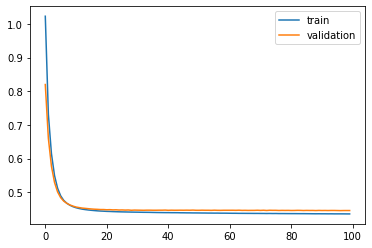

Time to train LSTM:  138.70097732543945
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 35s - loss: 0.9081 - val_loss: 0.7302

Epoch 00001: val_loss improved from inf to 0.73020, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6594 - val_loss: 0.6034

Epoch 00002: val_loss improved from 0.73020 to 0.60337, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5731 - val_loss: 0.5449

Epoch 00003: val_loss improved from 0.60337 to 0.54492, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5282 - val_loss: 0.5117

Epoch 00004: val_loss improved from 0.54492 to 0.51165, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5018 - val_loss: 0.4910

Epoch 00005: val_loss improved from 0.51165 to 0.49103, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4851 - val_loss: 0.4775

Epoch 00006: val_loss improved from 0.49103 to 0.47749, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4737 - val_loss: 0.4686

Epo

 - 1s - loss: 0.4359 - val_loss: 0.4382

Epoch 00061: val_loss improved from 0.43827 to 0.43823, saving model to val_weights1.hdf5
Epoch 62/100
 - 1s - loss: 0.4358 - val_loss: 0.4384

Epoch 00062: val_loss did not improve from 0.43823
Epoch 63/100
 - 1s - loss: 0.4357 - val_loss: 0.4379

Epoch 00063: val_loss improved from 0.43823 to 0.43791, saving model to val_weights1.hdf5
Epoch 64/100
 - 1s - loss: 0.4357 - val_loss: 0.4384

Epoch 00064: val_loss did not improve from 0.43791
Epoch 65/100
 - 1s - loss: 0.4357 - val_loss: 0.4382

Epoch 00065: val_loss did not improve from 0.43791
Epoch 66/100
 - 1s - loss: 0.4356 - val_loss: 0.4385

Epoch 00066: val_loss did not improve from 0.43791
Epoch 67/100
 - 1s - loss: 0.4355 - val_loss: 0.4385

Epoch 00067: val_loss did not improve from 0.43791
Epoch 68/100
 - 1s - loss: 0.4355 - val_loss: 0.4384

Epoch 00068: val_loss did not improve from 0.43791
Epoch 69/100
 - 1s - loss: 0.4353 - val_loss: 0.4381

Epoch 00069: val_loss did not improve fro

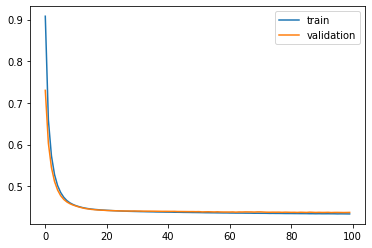

Time to train LSTM:  137.51379466056824
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 33s - loss: 0.8580 - val_loss: 0.7256

Epoch 00001: val_loss improved from inf to 0.72562, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6602 - val_loss: 0.5979

Epoch 00002: val_loss improved from 0.72562 to 0.59795, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5701 - val_loss: 0.5382

Epoch 00003: val_loss improved from 0.59795 to 0.53820, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5239 - val_loss: 0.5057

Epoch 00004: val_loss improved from 0.53820 to 0.50566, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.4978 - val_loss: 0.4866

Epoch 00005: val_loss improved from 0.50566 to 0.48655, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4820 - val_loss: 0.4744

Epoch 00006: val_loss improved from 0.48655 to 0.47439, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4716 - val_loss: 0.4657

Epo

 - 1s - loss: 0.4359 - val_loss: 0.4389

Epoch 00061: val_loss improved from 0.43903 to 0.43895, saving model to val_weights2.hdf5
Epoch 62/100
 - 1s - loss: 0.4358 - val_loss: 0.4389

Epoch 00062: val_loss improved from 0.43895 to 0.43893, saving model to val_weights2.hdf5
Epoch 63/100
 - 1s - loss: 0.4358 - val_loss: 0.4390

Epoch 00063: val_loss did not improve from 0.43893
Epoch 64/100
 - 1s - loss: 0.4356 - val_loss: 0.4387

Epoch 00064: val_loss improved from 0.43893 to 0.43875, saving model to val_weights2.hdf5
Epoch 65/100
 - 1s - loss: 0.4354 - val_loss: 0.4388

Epoch 00065: val_loss did not improve from 0.43875
Epoch 66/100
 - 1s - loss: 0.4353 - val_loss: 0.4390

Epoch 00066: val_loss did not improve from 0.43875
Epoch 67/100
 - 1s - loss: 0.4352 - val_loss: 0.4388

Epoch 00067: val_loss did not improve from 0.43875
Epoch 68/100
 - 1s - loss: 0.4352 - val_loss: 0.4389

Epoch 00068: val_loss did not improve from 0.43875
Epoch 69/100
 - 1s - loss: 0.4352 - val_loss: 0.4392

Ep

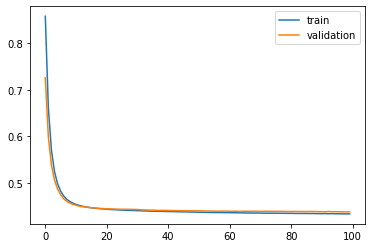

Time to train LSTM:  140.13613152503967
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 38s - loss: 0.8581 - val_loss: 0.7222

Epoch 00001: val_loss improved from inf to 0.72224, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6458 - val_loss: 0.5912

Epoch 00002: val_loss improved from 0.72224 to 0.59116, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5570 - val_loss: 0.5365

Epoch 00003: val_loss improved from 0.59116 to 0.53646, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5153 - val_loss: 0.5060

Epoch 00004: val_loss improved from 0.53646 to 0.50601, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.4914 - val_loss: 0.4872

Epoch 00005: val_loss improved from 0.50601 to 0.48720, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4763 - val_loss: 0.4748

Epoch 00006: val_loss improved from 0.48720 to 0.47483, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4667 - val_loss: 0.4672

Epo

 - 1s - loss: 0.4353 - val_loss: 0.4458

Epoch 00066: val_loss did not improve from 0.44530
Epoch 67/100
 - 1s - loss: 0.4352 - val_loss: 0.4457

Epoch 00067: val_loss did not improve from 0.44530
Epoch 68/100
 - 1s - loss: 0.4348 - val_loss: 0.4454

Epoch 00068: val_loss did not improve from 0.44530
Epoch 69/100
 - 1s - loss: 0.4348 - val_loss: 0.4454

Epoch 00069: val_loss did not improve from 0.44530
Epoch 70/100
 - 1s - loss: 0.4345 - val_loss: 0.4450

Epoch 00070: val_loss improved from 0.44530 to 0.44504, saving model to val_weights3.hdf5
Epoch 71/100
 - 1s - loss: 0.4345 - val_loss: 0.4445

Epoch 00071: val_loss improved from 0.44504 to 0.44449, saving model to val_weights3.hdf5
Epoch 72/100
 - 1s - loss: 0.4343 - val_loss: 0.4444

Epoch 00072: val_loss improved from 0.44449 to 0.44437, saving model to val_weights3.hdf5
Epoch 73/100
 - 1s - loss: 0.4343 - val_loss: 0.4447

Epoch 00073: val_loss did not improve from 0.44437
Epoch 74/100
 - 1s - loss: 0.4340 - val_loss: 0.4439

Ep

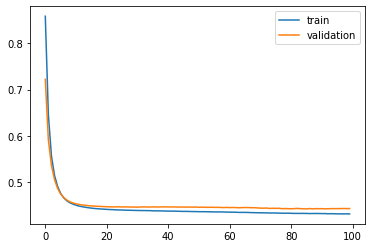

Time to train LSTM:  140.64501476287842


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f8bc8fba160>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 32s - loss: 0.8907 - val_loss: 0.7312

Epoch 00001: val_loss improved from inf to 0.73120, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.6608 - val_loss: 0.5978

Epoch 00002: val_loss improved from 0.73120 to 0.59781, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5710 - val_loss: 0.5380

Epoch 00003: val_loss improved from 0.59781 to 0.53798, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5255 - val_loss: 0.5042

Epoch 00004: val_loss improved from 0.53798 to 0.50419, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.4990 - val_loss: 0.4831

Epoch 00005: val_loss improved from 0.50419 to 0.48306, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4818 - val_loss: 0.4691

Epoch 00006: val_loss improved from 0.48306 to 0.46908, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4708 - val_loss: 0.4602

Epoch 00007: val_loss improved from 0.46908

 - 1s - loss: 0.4363 - val_loss: 0.4397

Epoch 00066: val_loss did not improve from 0.43901
Epoch 67/100
 - 1s - loss: 0.4363 - val_loss: 0.4400

Epoch 00067: val_loss did not improve from 0.43901
Epoch 68/100
 - 1s - loss: 0.4361 - val_loss: 0.4397

Epoch 00068: val_loss did not improve from 0.43901
Epoch 69/100
 - 1s - loss: 0.4361 - val_loss: 0.4398

Epoch 00069: val_loss did not improve from 0.43901
Epoch 70/100
 - 1s - loss: 0.4360 - val_loss: 0.4399

Epoch 00070: val_loss did not improve from 0.43901
Epoch 71/100
 - 1s - loss: 0.4360 - val_loss: 0.4400

Epoch 00071: val_loss did not improve from 0.43901
Epoch 72/100
 - 1s - loss: 0.4359 - val_loss: 0.4398

Epoch 00072: val_loss did not improve from 0.43901
Epoch 73/100
 - 1s - loss: 0.4358 - val_loss: 0.4397

Epoch 00073: val_loss did not improve from 0.43901
Epoch 74/100
 - 1s - loss: 0.4358 - val_loss: 0.4399

Epoch 00074: val_loss did not improve from 0.43901
Epoch 75/100
 - 1s - loss: 0.4357 - val_loss: 0.4398

Epoch 00075: v

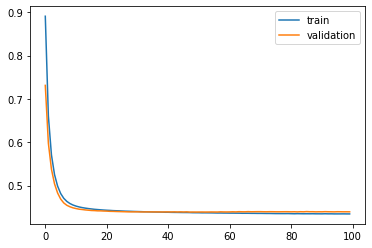

Time to train LSTM:  135.84559559822083
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 32s - loss: 0.8925 - val_loss: 0.7436

Epoch 00001: val_loss improved from inf to 0.74363, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6741 - val_loss: 0.6159

Epoch 00002: val_loss improved from 0.74363 to 0.61590, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5831 - val_loss: 0.5546

Epoch 00003: val_loss improved from 0.61590 to 0.55463, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5345 - val_loss: 0.5199

Epoch 00004: val_loss improved from 0.55463 to 0.51991, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5063 - val_loss: 0.4984

Epoch 00005: val_loss improved from 0.51991 to 0.49837, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4884 - val_loss: 0.4838

Epoch 00006: val_loss improved from 0.49837 to 0.48376, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4758 - val_loss: 0.4731

Epo

 - 1s - loss: 0.4354 - val_loss: 0.4435

Epoch 00062: val_loss did not improve from 0.44345
Epoch 63/100
 - 1s - loss: 0.4354 - val_loss: 0.4436

Epoch 00063: val_loss did not improve from 0.44345
Epoch 64/100
 - 1s - loss: 0.4353 - val_loss: 0.4436

Epoch 00064: val_loss did not improve from 0.44345
Epoch 65/100
 - 1s - loss: 0.4353 - val_loss: 0.4433

Epoch 00065: val_loss improved from 0.44345 to 0.44335, saving model to val_weights5.hdf5
Epoch 66/100
 - 1s - loss: 0.4352 - val_loss: 0.4436

Epoch 00066: val_loss did not improve from 0.44335
Epoch 67/100
 - 1s - loss: 0.4351 - val_loss: 0.4436

Epoch 00067: val_loss did not improve from 0.44335
Epoch 68/100
 - 1s - loss: 0.4350 - val_loss: 0.4435

Epoch 00068: val_loss did not improve from 0.44335
Epoch 69/100
 - 1s - loss: 0.4350 - val_loss: 0.4433

Epoch 00069: val_loss improved from 0.44335 to 0.44332, saving model to val_weights5.hdf5
Epoch 70/100
 - 1s - loss: 0.4348 - val_loss: 0.4436

Epoch 00070: val_loss did not improve fro

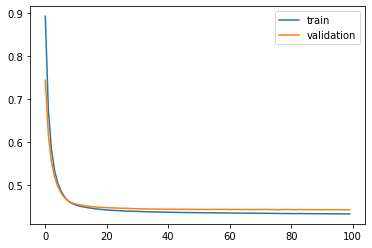

Time to train LSTM:  134.95123076438904
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 37s - loss: 0.9098 - val_loss: 0.7472

Epoch 00001: val_loss improved from inf to 0.74720, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6784 - val_loss: 0.6175

Epoch 00002: val_loss improved from 0.74720 to 0.61751, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5836 - val_loss: 0.5526

Epoch 00003: val_loss improved from 0.61751 to 0.55255, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5340 - val_loss: 0.5165

Epoch 00004: val_loss improved from 0.55255 to 0.51648, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5059 - val_loss: 0.4948

Epoch 00005: val_loss improved from 0.51648 to 0.49482, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4885 - val_loss: 0.4806

Epoch 00006: val_loss improved from 0.49482 to 0.48059, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4766 - val_loss: 0.4709

Epo

 - 1s - loss: 0.4374 - val_loss: 0.4414

Epoch 00063: val_loss did not improve from 0.44089
Epoch 64/100
 - 1s - loss: 0.4375 - val_loss: 0.4415

Epoch 00064: val_loss did not improve from 0.44089
Epoch 65/100
 - 1s - loss: 0.4375 - val_loss: 0.4413

Epoch 00065: val_loss did not improve from 0.44089
Epoch 66/100
 - 1s - loss: 0.4374 - val_loss: 0.4414

Epoch 00066: val_loss did not improve from 0.44089
Epoch 67/100
 - 1s - loss: 0.4372 - val_loss: 0.4412

Epoch 00067: val_loss did not improve from 0.44089
Epoch 68/100
 - 1s - loss: 0.4372 - val_loss: 0.4416

Epoch 00068: val_loss did not improve from 0.44089
Epoch 69/100
 - 1s - loss: 0.4371 - val_loss: 0.4414

Epoch 00069: val_loss did not improve from 0.44089
Epoch 70/100
 - 1s - loss: 0.4370 - val_loss: 0.4417

Epoch 00070: val_loss did not improve from 0.44089
Epoch 71/100
 - 1s - loss: 0.4372 - val_loss: 0.4418

Epoch 00071: val_loss did not improve from 0.44089
Epoch 72/100
 - 1s - loss: 0.4371 - val_loss: 0.4416

Epoch 00072: v

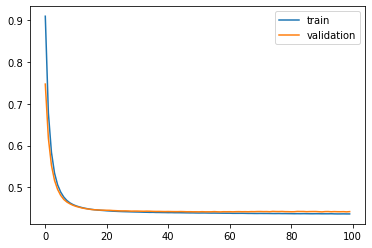

Time to train LSTM:  139.94349026679993
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 36s - loss: 0.9351 - val_loss: 0.7626

Epoch 00001: val_loss improved from inf to 0.76256, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6967 - val_loss: 0.6336

Epoch 00002: val_loss improved from 0.76256 to 0.63365, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.6001 - val_loss: 0.5663

Epoch 00003: val_loss improved from 0.63365 to 0.56633, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5455 - val_loss: 0.5251

Epoch 00004: val_loss improved from 0.56633 to 0.52512, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5126 - val_loss: 0.4995

Epoch 00005: val_loss improved from 0.52512 to 0.49951, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4921 - val_loss: 0.4829

Epoch 00006: val_loss improved from 0.49951 to 0.48286, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4786 - val_loss: 0.4716

Epo

 - 1s - loss: 0.4365 - val_loss: 0.4393

Epoch 00062: val_loss improved from 0.43945 to 0.43935, saving model to val_weights2.hdf5
Epoch 63/100
 - 1s - loss: 0.4365 - val_loss: 0.4395

Epoch 00063: val_loss did not improve from 0.43935
Epoch 64/100
 - 1s - loss: 0.4364 - val_loss: 0.4393

Epoch 00064: val_loss improved from 0.43935 to 0.43932, saving model to val_weights2.hdf5
Epoch 65/100
 - 1s - loss: 0.4363 - val_loss: 0.4394

Epoch 00065: val_loss did not improve from 0.43932
Epoch 66/100
 - 1s - loss: 0.4363 - val_loss: 0.4392

Epoch 00066: val_loss improved from 0.43932 to 0.43917, saving model to val_weights2.hdf5
Epoch 67/100
 - 1s - loss: 0.4360 - val_loss: 0.4393

Epoch 00067: val_loss did not improve from 0.43917
Epoch 68/100
 - 1s - loss: 0.4361 - val_loss: 0.4391

Epoch 00068: val_loss improved from 0.43917 to 0.43910, saving model to val_weights2.hdf5
Epoch 69/100
 - 1s - loss: 0.4359 - val_loss: 0.4391

Epoch 00069: val_loss improved from 0.43910 to 0.43909, saving model

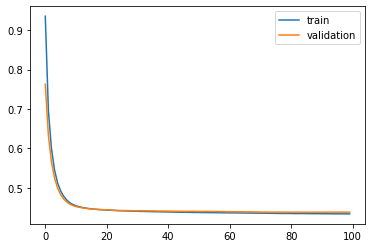

Time to train LSTM:  140.58351349830627
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 33s - loss: 1.0053 - val_loss: 0.7965

Epoch 00001: val_loss improved from inf to 0.79654, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7068 - val_loss: 0.6394

Epoch 00002: val_loss improved from 0.79654 to 0.63944, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5954 - val_loss: 0.5680

Epoch 00003: val_loss improved from 0.63944 to 0.56800, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5417 - val_loss: 0.5286

Epoch 00004: val_loss improved from 0.56800 to 0.52857, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5114 - val_loss: 0.5052

Epoch 00005: val_loss improved from 0.52857 to 0.50523, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4925 - val_loss: 0.4901

Epoch 00006: val_loss improved from 0.50523 to 0.49010, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4798 - val_loss: 0.4794

Epo

 - 1s - loss: 0.4369 - val_loss: 0.4473

Epoch 00066: val_loss did not improve from 0.44715
Epoch 67/100
 - 1s - loss: 0.4370 - val_loss: 0.4475

Epoch 00067: val_loss did not improve from 0.44715
Epoch 68/100
 - 1s - loss: 0.4370 - val_loss: 0.4472

Epoch 00068: val_loss did not improve from 0.44715
Epoch 69/100
 - 1s - loss: 0.4369 - val_loss: 0.4475

Epoch 00069: val_loss did not improve from 0.44715
Epoch 70/100
 - 1s - loss: 0.4367 - val_loss: 0.4474

Epoch 00070: val_loss did not improve from 0.44715
Epoch 71/100
 - 1s - loss: 0.4367 - val_loss: 0.4473

Epoch 00071: val_loss did not improve from 0.44715
Epoch 72/100
 - 1s - loss: 0.4367 - val_loss: 0.4473

Epoch 00072: val_loss did not improve from 0.44715
Epoch 73/100
 - 1s - loss: 0.4365 - val_loss: 0.4475

Epoch 00073: val_loss did not improve from 0.44715
Epoch 74/100
 - 1s - loss: 0.4365 - val_loss: 0.4475

Epoch 00074: val_loss did not improve from 0.44715
Epoch 75/100
 - 1s - loss: 0.4365 - val_loss: 0.4472

Epoch 00075: v

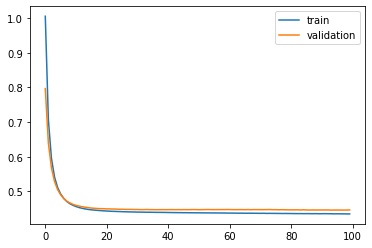

Time to train LSTM:  137.76720333099365
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 36s - loss: 1.0628 - val_loss: 0.8152

Epoch 00001: val_loss improved from inf to 0.81522, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7384 - val_loss: 0.6639

Epoch 00002: val_loss improved from 0.81522 to 0.66388, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6276 - val_loss: 0.5874

Epoch 00003: val_loss improved from 0.66388 to 0.58738, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5670 - val_loss: 0.5416

Epoch 00004: val_loss improved from 0.58738 to 0.54159, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5299 - val_loss: 0.5124

Epoch 00005: val_loss improved from 0.54159 to 0.51238, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.5064 - val_loss: 0.4931

Epoch 00006: val_loss improved from 0.51238 to 0.49310, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4907 - val_loss: 0.4798

Epo


Epoch 00063: val_loss did not improve from 0.43727
Epoch 64/100
 - 1s - loss: 0.4385 - val_loss: 0.4378

Epoch 00064: val_loss did not improve from 0.43727
Epoch 65/100
 - 1s - loss: 0.4386 - val_loss: 0.4379

Epoch 00065: val_loss did not improve from 0.43727
Epoch 66/100
 - 1s - loss: 0.4387 - val_loss: 0.4376

Epoch 00066: val_loss did not improve from 0.43727
Epoch 67/100
 - 1s - loss: 0.4385 - val_loss: 0.4372

Epoch 00067: val_loss improved from 0.43727 to 0.43720, saving model to val_weights4.hdf5
Epoch 68/100
 - 1s - loss: 0.4383 - val_loss: 0.4378

Epoch 00068: val_loss did not improve from 0.43720
Epoch 69/100
 - 1s - loss: 0.4382 - val_loss: 0.4378

Epoch 00069: val_loss did not improve from 0.43720
Epoch 70/100
 - 1s - loss: 0.4381 - val_loss: 0.4372

Epoch 00070: val_loss did not improve from 0.43720
Epoch 71/100
 - 1s - loss: 0.4379 - val_loss: 0.4375

Epoch 00071: val_loss did not improve from 0.43720
Epoch 72/100
 - 1s - loss: 0.4379 - val_loss: 0.4373

Epoch 00072: va

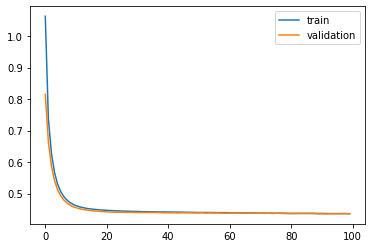

Time to train LSTM:  143.1467158794403
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 35s - loss: 0.9332 - val_loss: 0.7726

Epoch 00001: val_loss improved from inf to 0.77258, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6944 - val_loss: 0.6301

Epoch 00002: val_loss improved from 0.77258 to 0.63014, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5892 - val_loss: 0.5605

Epoch 00003: val_loss improved from 0.63014 to 0.56048, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5355 - val_loss: 0.5215

Epoch 00004: val_loss improved from 0.56048 to 0.52152, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5049 - val_loss: 0.4982

Epoch 00005: val_loss improved from 0.52152 to 0.49824, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4865 - val_loss: 0.4837

Epoch 00006: val_loss improved from 0.49824 to 0.48366, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4747 - val_loss: 0.4740

Epoc


Epoch 00062: val_loss did not improve from 0.44387
Epoch 63/100
 - 1s - loss: 0.4360 - val_loss: 0.4436

Epoch 00063: val_loss improved from 0.44387 to 0.44358, saving model to val_weights5.hdf5
Epoch 64/100
 - 1s - loss: 0.4360 - val_loss: 0.4436

Epoch 00064: val_loss did not improve from 0.44358
Epoch 65/100
 - 1s - loss: 0.4360 - val_loss: 0.4435

Epoch 00065: val_loss improved from 0.44358 to 0.44348, saving model to val_weights5.hdf5
Epoch 66/100
 - 1s - loss: 0.4358 - val_loss: 0.4437

Epoch 00066: val_loss did not improve from 0.44348
Epoch 67/100
 - 1s - loss: 0.4358 - val_loss: 0.4434

Epoch 00067: val_loss improved from 0.44348 to 0.44345, saving model to val_weights5.hdf5
Epoch 68/100
 - 1s - loss: 0.4357 - val_loss: 0.4435

Epoch 00068: val_loss did not improve from 0.44345
Epoch 69/100
 - 1s - loss: 0.4356 - val_loss: 0.4434

Epoch 00069: val_loss improved from 0.44345 to 0.44340, saving model to val_weights5.hdf5
Epoch 70/100
 - 1s - loss: 0.4356 - val_loss: 0.4434

Epo

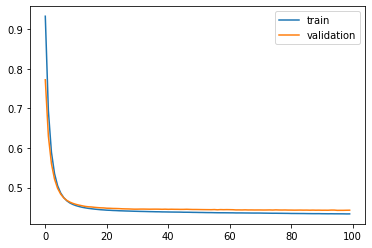

Time to train LSTM:  139.44228291511536
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 34s - loss: 0.9225 - val_loss: 0.7584

Epoch 00001: val_loss improved from inf to 0.75836, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6844 - val_loss: 0.6218

Epoch 00002: val_loss improved from 0.75836 to 0.62185, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5874 - val_loss: 0.5555

Epoch 00003: val_loss improved from 0.62185 to 0.55555, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5370 - val_loss: 0.5188

Epoch 00004: val_loss improved from 0.55555 to 0.51878, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5076 - val_loss: 0.4960

Epoch 00005: val_loss improved from 0.51878 to 0.49604, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4892 - val_loss: 0.4814

Epoch 00006: val_loss improved from 0.49604 to 0.48139, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4766 - val_loss: 0.4713

Epo

 - 1s - loss: 0.4362 - val_loss: 0.4405

Epoch 00065: val_loss did not improve from 0.43981
Epoch 66/100
 - 1s - loss: 0.4360 - val_loss: 0.4406

Epoch 00066: val_loss did not improve from 0.43981
Epoch 67/100
 - 1s - loss: 0.4360 - val_loss: 0.4405

Epoch 00067: val_loss did not improve from 0.43981
Epoch 68/100
 - 1s - loss: 0.4360 - val_loss: 0.4404

Epoch 00068: val_loss did not improve from 0.43981
Epoch 69/100
 - 1s - loss: 0.4360 - val_loss: 0.4407

Epoch 00069: val_loss did not improve from 0.43981
Epoch 70/100
 - 1s - loss: 0.4359 - val_loss: 0.4405

Epoch 00070: val_loss did not improve from 0.43981
Epoch 71/100
 - 1s - loss: 0.4358 - val_loss: 0.4407

Epoch 00071: val_loss did not improve from 0.43981
Epoch 72/100
 - 1s - loss: 0.4359 - val_loss: 0.4405

Epoch 00072: val_loss did not improve from 0.43981
Epoch 73/100
 - 1s - loss: 0.4358 - val_loss: 0.4405

Epoch 00073: val_loss did not improve from 0.43981
Epoch 74/100
 - 1s - loss: 0.4357 - val_loss: 0.4404

Epoch 00074: v

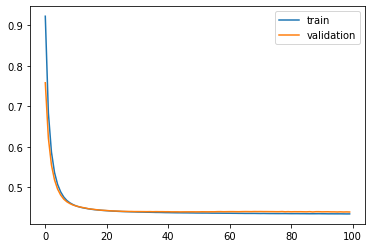

Time to train LSTM:  138.40953159332275
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 35s - loss: 0.9428 - val_loss: 0.7703

Epoch 00001: val_loss improved from inf to 0.77030, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6910 - val_loss: 0.6235

Epoch 00002: val_loss improved from 0.77030 to 0.62346, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5903 - val_loss: 0.5575

Epoch 00003: val_loss improved from 0.62346 to 0.55753, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5387 - val_loss: 0.5200

Epoch 00004: val_loss improved from 0.55753 to 0.51997, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5090 - val_loss: 0.4971

Epoch 00005: val_loss improved from 0.51997 to 0.49711, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4900 - val_loss: 0.4814

Epoch 00006: val_loss improved from 0.49711 to 0.48142, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4766 - val_loss: 0.4696

Epo

 - 1s - loss: 0.4364 - val_loss: 0.4398

Epoch 00065: val_loss did not improve from 0.43949
Epoch 66/100
 - 1s - loss: 0.4363 - val_loss: 0.4393

Epoch 00066: val_loss improved from 0.43949 to 0.43931, saving model to val_weights2.hdf5
Epoch 67/100
 - 1s - loss: 0.4363 - val_loss: 0.4397

Epoch 00067: val_loss did not improve from 0.43931
Epoch 68/100
 - 1s - loss: 0.4363 - val_loss: 0.4396

Epoch 00068: val_loss did not improve from 0.43931
Epoch 69/100
 - 1s - loss: 0.4362 - val_loss: 0.4395

Epoch 00069: val_loss did not improve from 0.43931
Epoch 70/100
 - 1s - loss: 0.4361 - val_loss: 0.4398

Epoch 00070: val_loss did not improve from 0.43931
Epoch 71/100
 - 1s - loss: 0.4359 - val_loss: 0.4396

Epoch 00071: val_loss did not improve from 0.43931
Epoch 72/100
 - 1s - loss: 0.4360 - val_loss: 0.4396

Epoch 00072: val_loss did not improve from 0.43931
Epoch 73/100
 - 1s - loss: 0.4361 - val_loss: 0.4398

Epoch 00073: val_loss did not improve from 0.43931
Epoch 74/100
 - 1s - loss: 0.

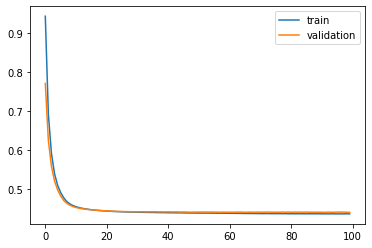

Time to train LSTM:  140.64348721504211
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 35s - loss: 1.0812 - val_loss: 0.8285

Epoch 00001: val_loss improved from inf to 0.82854, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7520 - val_loss: 0.6885

Epoch 00002: val_loss improved from 0.82854 to 0.68845, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.6476 - val_loss: 0.6124

Epoch 00003: val_loss improved from 0.68845 to 0.61241, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5865 - val_loss: 0.5668

Epoch 00004: val_loss improved from 0.61241 to 0.56682, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5478 - val_loss: 0.5372

Epoch 00005: val_loss improved from 0.56682 to 0.53715, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.5224 - val_loss: 0.5167

Epoch 00006: val_loss improved from 0.53715 to 0.51671, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.5046 - val_loss: 0.5020

Epo


Epoch 00062: val_loss did not improve from 0.44686
Epoch 63/100
 - 1s - loss: 0.4377 - val_loss: 0.4470

Epoch 00063: val_loss did not improve from 0.44686
Epoch 64/100
 - 1s - loss: 0.4376 - val_loss: 0.4464

Epoch 00064: val_loss improved from 0.44686 to 0.44644, saving model to val_weights3.hdf5
Epoch 65/100
 - 1s - loss: 0.4374 - val_loss: 0.4467

Epoch 00065: val_loss did not improve from 0.44644
Epoch 66/100
 - 1s - loss: 0.4376 - val_loss: 0.4467

Epoch 00066: val_loss did not improve from 0.44644
Epoch 67/100
 - 1s - loss: 0.4375 - val_loss: 0.4468

Epoch 00067: val_loss did not improve from 0.44644
Epoch 68/100
 - 1s - loss: 0.4373 - val_loss: 0.4462

Epoch 00068: val_loss improved from 0.44644 to 0.44625, saving model to val_weights3.hdf5
Epoch 69/100
 - 1s - loss: 0.4373 - val_loss: 0.4462

Epoch 00069: val_loss improved from 0.44625 to 0.44618, saving model to val_weights3.hdf5
Epoch 70/100
 - 1s - loss: 0.4372 - val_loss: 0.4461

Epoch 00070: val_loss improved from 0.4461

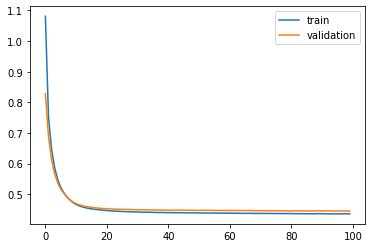

Time to train LSTM:  142.99769639968872
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 36s - loss: 0.8639 - val_loss: 0.7204

Epoch 00001: val_loss improved from inf to 0.72044, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.6600 - val_loss: 0.6028

Epoch 00002: val_loss improved from 0.72044 to 0.60278, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5767 - val_loss: 0.5456

Epoch 00003: val_loss improved from 0.60278 to 0.54561, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5332 - val_loss: 0.5125

Epoch 00004: val_loss improved from 0.54561 to 0.51253, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5069 - val_loss: 0.4921

Epoch 00005: val_loss improved from 0.51253 to 0.49206, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4902 - val_loss: 0.4786

Epoch 00006: val_loss improved from 0.49206 to 0.47864, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4788 - val_loss: 0.4691

Epo

 - 1s - loss: 0.4365 - val_loss: 0.4391

Epoch 00065: val_loss did not improve from 0.43911
Epoch 66/100
 - 1s - loss: 0.4365 - val_loss: 0.4390

Epoch 00066: val_loss improved from 0.43911 to 0.43901, saving model to val_weights4.hdf5
Epoch 67/100
 - 1s - loss: 0.4364 - val_loss: 0.4386

Epoch 00067: val_loss improved from 0.43901 to 0.43859, saving model to val_weights4.hdf5
Epoch 68/100
 - 1s - loss: 0.4363 - val_loss: 0.4386

Epoch 00068: val_loss did not improve from 0.43859
Epoch 69/100
 - 1s - loss: 0.4362 - val_loss: 0.4388

Epoch 00069: val_loss did not improve from 0.43859
Epoch 70/100
 - 1s - loss: 0.4361 - val_loss: 0.4392

Epoch 00070: val_loss did not improve from 0.43859
Epoch 71/100
 - 1s - loss: 0.4360 - val_loss: 0.4388

Epoch 00071: val_loss did not improve from 0.43859
Epoch 72/100
 - 1s - loss: 0.4360 - val_loss: 0.4390

Epoch 00072: val_loss did not improve from 0.43859
Epoch 73/100
 - 1s - loss: 0.4359 - val_loss: 0.4386

Epoch 00073: val_loss did not improve fro

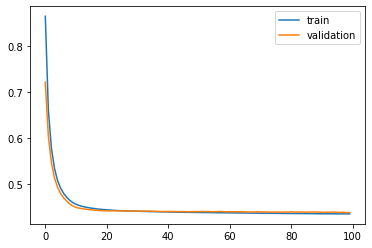

Time to train LSTM:  143.37131452560425
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 37s - loss: 0.9780 - val_loss: 0.8049

Epoch 00001: val_loss improved from inf to 0.80487, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7222 - val_loss: 0.6498

Epoch 00002: val_loss improved from 0.80487 to 0.64985, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6012 - val_loss: 0.5692

Epoch 00003: val_loss improved from 0.64985 to 0.56919, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5436 - val_loss: 0.5297

Epoch 00004: val_loss improved from 0.56919 to 0.52974, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5127 - val_loss: 0.5058

Epoch 00005: val_loss improved from 0.52974 to 0.50579, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4938 - val_loss: 0.4902

Epoch 00006: val_loss improved from 0.50579 to 0.49023, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4810 - val_loss: 0.4794

Epo

 - 1s - loss: 0.4358 - val_loss: 0.4444

Epoch 00064: val_loss improved from 0.44437 to 0.44435, saving model to val_weights5.hdf5
Epoch 65/100
 - 1s - loss: 0.4355 - val_loss: 0.4446

Epoch 00065: val_loss did not improve from 0.44435
Epoch 66/100
 - 1s - loss: 0.4356 - val_loss: 0.4443

Epoch 00066: val_loss improved from 0.44435 to 0.44431, saving model to val_weights5.hdf5
Epoch 67/100
 - 1s - loss: 0.4354 - val_loss: 0.4444

Epoch 00067: val_loss did not improve from 0.44431
Epoch 68/100
 - 1s - loss: 0.4355 - val_loss: 0.4445

Epoch 00068: val_loss did not improve from 0.44431
Epoch 69/100
 - 1s - loss: 0.4353 - val_loss: 0.4443

Epoch 00069: val_loss improved from 0.44431 to 0.44428, saving model to val_weights5.hdf5
Epoch 70/100
 - 1s - loss: 0.4354 - val_loss: 0.4443

Epoch 00070: val_loss did not improve from 0.44428
Epoch 71/100
 - 1s - loss: 0.4353 - val_loss: 0.4440

Epoch 00071: val_loss improved from 0.44428 to 0.44401, saving model to val_weights5.hdf5
Epoch 72/100
 - 1

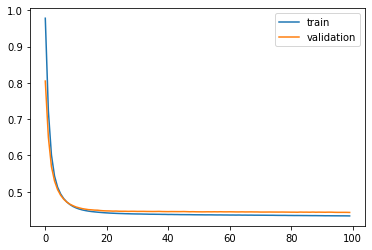

Time to train LSTM:  146.02582430839539
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 37s - loss: 0.9676 - val_loss: 0.8066

Epoch 00001: val_loss improved from inf to 0.80657, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7237 - val_loss: 0.6479

Epoch 00002: val_loss improved from 0.80657 to 0.64786, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.6045 - val_loss: 0.5661

Epoch 00003: val_loss improved from 0.64786 to 0.56607, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5422 - val_loss: 0.5206

Epoch 00004: val_loss improved from 0.56607 to 0.52064, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5073 - val_loss: 0.4938

Epoch 00005: val_loss improved from 0.52064 to 0.49377, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4860 - val_loss: 0.4759

Epoch 00006: val_loss improved from 0.49377 to 0.47587, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4717 - val_loss: 0.4647

Epo

 - 1s - loss: 0.4367 - val_loss: 0.4392

Epoch 00062: val_loss improved from 0.43943 to 0.43924, saving model to val_weights1.hdf5
Epoch 63/100
 - 1s - loss: 0.4366 - val_loss: 0.4393

Epoch 00063: val_loss did not improve from 0.43924
Epoch 64/100
 - 1s - loss: 0.4365 - val_loss: 0.4395

Epoch 00064: val_loss did not improve from 0.43924
Epoch 65/100
 - 1s - loss: 0.4365 - val_loss: 0.4395

Epoch 00065: val_loss did not improve from 0.43924
Epoch 66/100
 - 1s - loss: 0.4364 - val_loss: 0.4394

Epoch 00066: val_loss did not improve from 0.43924
Epoch 67/100
 - 1s - loss: 0.4363 - val_loss: 0.4391

Epoch 00067: val_loss improved from 0.43924 to 0.43915, saving model to val_weights1.hdf5
Epoch 68/100
 - 1s - loss: 0.4361 - val_loss: 0.4392

Epoch 00068: val_loss did not improve from 0.43915
Epoch 69/100
 - 1s - loss: 0.4360 - val_loss: 0.4392

Epoch 00069: val_loss did not improve from 0.43915
Epoch 70/100
 - 1s - loss: 0.4358 - val_loss: 0.4391

Epoch 00070: val_loss improved from 0.439

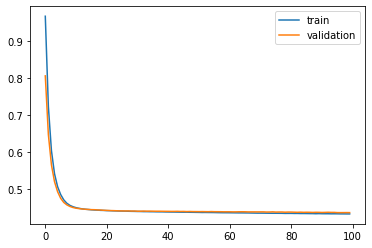

Time to train LSTM:  142.77335333824158
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 37s - loss: 0.9149 - val_loss: 0.7599

Epoch 00001: val_loss improved from inf to 0.75993, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6850 - val_loss: 0.6196

Epoch 00002: val_loss improved from 0.75993 to 0.61958, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5832 - val_loss: 0.5490

Epoch 00003: val_loss improved from 0.61958 to 0.54900, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5298 - val_loss: 0.5095

Epoch 00004: val_loss improved from 0.54900 to 0.50952, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.4992 - val_loss: 0.4857

Epoch 00005: val_loss improved from 0.50952 to 0.48573, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4806 - val_loss: 0.4711

Epoch 00006: val_loss improved from 0.48573 to 0.47115, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4691 - val_loss: 0.4623

Epo


Epoch 00064: val_loss did not improve from 0.43915
Epoch 65/100
 - 1s - loss: 0.4365 - val_loss: 0.4397

Epoch 00065: val_loss did not improve from 0.43915
Epoch 66/100
 - 1s - loss: 0.4362 - val_loss: 0.4400

Epoch 00066: val_loss did not improve from 0.43915
Epoch 67/100
 - 1s - loss: 0.4360 - val_loss: 0.4400

Epoch 00067: val_loss did not improve from 0.43915
Epoch 68/100
 - 1s - loss: 0.4359 - val_loss: 0.4392

Epoch 00068: val_loss did not improve from 0.43915
Epoch 69/100
 - 1s - loss: 0.4358 - val_loss: 0.4401

Epoch 00069: val_loss did not improve from 0.43915
Epoch 70/100
 - 1s - loss: 0.4359 - val_loss: 0.4396

Epoch 00070: val_loss did not improve from 0.43915
Epoch 71/100
 - 1s - loss: 0.4357 - val_loss: 0.4397

Epoch 00071: val_loss did not improve from 0.43915
Epoch 72/100
 - 1s - loss: 0.4359 - val_loss: 0.4396

Epoch 00072: val_loss did not improve from 0.43915
Epoch 73/100
 - 1s - loss: 0.4358 - val_loss: 0.4395

Epoch 00073: val_loss did not improve from 0.43915
Epo

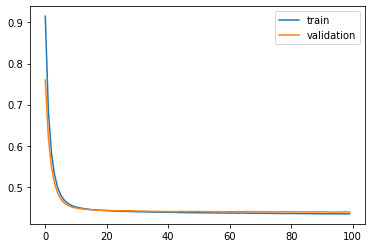

Time to train LSTM:  145.53077268600464
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 37s - loss: 0.9782 - val_loss: 0.7920

Epoch 00001: val_loss improved from inf to 0.79204, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6926 - val_loss: 0.6191

Epoch 00002: val_loss improved from 0.79204 to 0.61906, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5763 - val_loss: 0.5473

Epoch 00003: val_loss improved from 0.61906 to 0.54732, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5227 - val_loss: 0.5099

Epoch 00004: val_loss improved from 0.54732 to 0.50989, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.4932 - val_loss: 0.4877

Epoch 00005: val_loss improved from 0.50989 to 0.48766, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4759 - val_loss: 0.4744

Epoch 00006: val_loss improved from 0.48766 to 0.47440, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4656 - val_loss: 0.4665

Epo


Epoch 00065: val_loss did not improve from 0.44514
Epoch 66/100
 - 1s - loss: 0.4352 - val_loss: 0.4450

Epoch 00066: val_loss improved from 0.44514 to 0.44503, saving model to val_weights3.hdf5
Epoch 67/100
 - 1s - loss: 0.4350 - val_loss: 0.4453

Epoch 00067: val_loss did not improve from 0.44503
Epoch 68/100
 - 1s - loss: 0.4351 - val_loss: 0.4450

Epoch 00068: val_loss did not improve from 0.44503
Epoch 69/100
 - 1s - loss: 0.4350 - val_loss: 0.4455

Epoch 00069: val_loss did not improve from 0.44503
Epoch 70/100
 - 1s - loss: 0.4350 - val_loss: 0.4450

Epoch 00070: val_loss did not improve from 0.44503
Epoch 71/100
 - 1s - loss: 0.4349 - val_loss: 0.4449

Epoch 00071: val_loss improved from 0.44503 to 0.44492, saving model to val_weights3.hdf5
Epoch 72/100
 - 1s - loss: 0.4349 - val_loss: 0.4448

Epoch 00072: val_loss improved from 0.44492 to 0.44477, saving model to val_weights3.hdf5
Epoch 73/100
 - 1s - loss: 0.4347 - val_loss: 0.4449

Epoch 00073: val_loss did not improve from

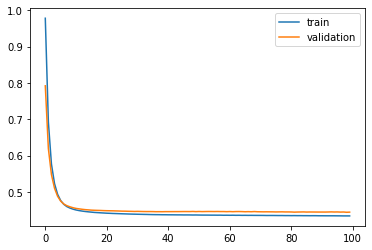

Time to train LSTM:  144.6051995754242
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 38s - loss: 1.0467 - val_loss: 0.8226

Epoch 00001: val_loss improved from inf to 0.82259, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7408 - val_loss: 0.6627

Epoch 00002: val_loss improved from 0.82259 to 0.66273, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6231 - val_loss: 0.5804

Epoch 00003: val_loss improved from 0.66273 to 0.58041, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5588 - val_loss: 0.5318

Epoch 00004: val_loss improved from 0.58041 to 0.53179, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5208 - val_loss: 0.5023

Epoch 00005: val_loss improved from 0.53179 to 0.50227, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4976 - val_loss: 0.4837

Epoch 00006: val_loss improved from 0.50227 to 0.48374, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4826 - val_loss: 0.4711

Epoc

 - 1s - loss: 0.4381 - val_loss: 0.4386

Epoch 00064: val_loss did not improve from 0.43815
Epoch 65/100
 - 1s - loss: 0.4381 - val_loss: 0.4385

Epoch 00065: val_loss did not improve from 0.43815
Epoch 66/100
 - 1s - loss: 0.4380 - val_loss: 0.4387

Epoch 00066: val_loss did not improve from 0.43815
Epoch 67/100
 - 1s - loss: 0.4379 - val_loss: 0.4383

Epoch 00067: val_loss did not improve from 0.43815
Epoch 68/100
 - 1s - loss: 0.4378 - val_loss: 0.4388

Epoch 00068: val_loss did not improve from 0.43815
Epoch 69/100
 - 1s - loss: 0.4378 - val_loss: 0.4384

Epoch 00069: val_loss did not improve from 0.43815
Epoch 70/100
 - 1s - loss: 0.4377 - val_loss: 0.4386

Epoch 00070: val_loss did not improve from 0.43815
Epoch 71/100
 - 1s - loss: 0.4376 - val_loss: 0.4384

Epoch 00071: val_loss did not improve from 0.43815
Epoch 72/100
 - 1s - loss: 0.4376 - val_loss: 0.4387

Epoch 00072: val_loss did not improve from 0.43815
Epoch 73/100
 - 1s - loss: 0.4374 - val_loss: 0.4384

Epoch 00073: v

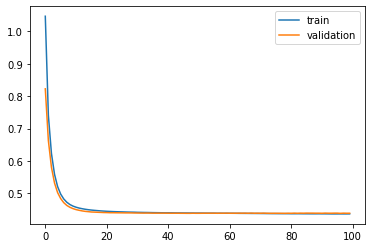

Time to train LSTM:  146.45543813705444
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 41s - loss: 1.0724 - val_loss: 0.8544

Epoch 00001: val_loss improved from inf to 0.85441, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7611 - val_loss: 0.6741

Epoch 00002: val_loss improved from 0.85441 to 0.67413, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6250 - val_loss: 0.5823

Epoch 00003: val_loss improved from 0.67413 to 0.58228, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5540 - val_loss: 0.5328

Epoch 00004: val_loss improved from 0.58228 to 0.53279, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5154 - val_loss: 0.5045

Epoch 00005: val_loss improved from 0.53279 to 0.50454, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4928 - val_loss: 0.4872

Epoch 00006: val_loss improved from 0.50454 to 0.48720, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4785 - val_loss: 0.4761

Epo

 - 1s - loss: 0.4373 - val_loss: 0.4453

Epoch 00062: val_loss did not improve from 0.44488
Epoch 63/100
 - 1s - loss: 0.4370 - val_loss: 0.4451

Epoch 00063: val_loss did not improve from 0.44488
Epoch 64/100
 - 1s - loss: 0.4369 - val_loss: 0.4447

Epoch 00064: val_loss improved from 0.44488 to 0.44472, saving model to val_weights5.hdf5
Epoch 65/100
 - 1s - loss: 0.4370 - val_loss: 0.4452

Epoch 00065: val_loss did not improve from 0.44472
Epoch 66/100
 - 1s - loss: 0.4370 - val_loss: 0.4450

Epoch 00066: val_loss did not improve from 0.44472
Epoch 67/100
 - 1s - loss: 0.4367 - val_loss: 0.4451

Epoch 00067: val_loss did not improve from 0.44472
Epoch 68/100
 - 1s - loss: 0.4366 - val_loss: 0.4452

Epoch 00068: val_loss did not improve from 0.44472
Epoch 69/100
 - 1s - loss: 0.4367 - val_loss: 0.4453

Epoch 00069: val_loss did not improve from 0.44472
Epoch 70/100
 - 1s - loss: 0.4366 - val_loss: 0.4454

Epoch 00070: val_loss did not improve from 0.44472
Epoch 71/100
 - 1s - loss: 0.

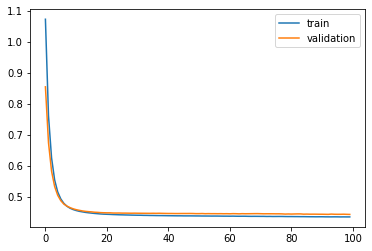

Time to train LSTM:  148.5571448802948
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 38s - loss: 0.9625 - val_loss: 0.7968

Epoch 00001: val_loss improved from inf to 0.79678, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7086 - val_loss: 0.6430

Epoch 00002: val_loss improved from 0.79678 to 0.64304, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.6003 - val_loss: 0.5664

Epoch 00003: val_loss improved from 0.64304 to 0.56635, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5427 - val_loss: 0.5234

Epoch 00004: val_loss improved from 0.56635 to 0.52336, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5099 - val_loss: 0.4979

Epoch 00005: val_loss improved from 0.52336 to 0.49793, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4902 - val_loss: 0.4822

Epoch 00006: val_loss improved from 0.49793 to 0.48220, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4773 - val_loss: 0.4718

Epoc

 - 1s - loss: 0.4373 - val_loss: 0.4414

Epoch 00065: val_loss improved from 0.44155 to 0.44142, saving model to val_weights1.hdf5
Epoch 66/100
 - 1s - loss: 0.4373 - val_loss: 0.4418

Epoch 00066: val_loss did not improve from 0.44142
Epoch 67/100
 - 1s - loss: 0.4373 - val_loss: 0.4411

Epoch 00067: val_loss improved from 0.44142 to 0.44113, saving model to val_weights1.hdf5
Epoch 68/100
 - 1s - loss: 0.4371 - val_loss: 0.4412

Epoch 00068: val_loss did not improve from 0.44113
Epoch 69/100
 - 1s - loss: 0.4370 - val_loss: 0.4411

Epoch 00069: val_loss improved from 0.44113 to 0.44109, saving model to val_weights1.hdf5
Epoch 70/100
 - 1s - loss: 0.4368 - val_loss: 0.4410

Epoch 00070: val_loss improved from 0.44109 to 0.44103, saving model to val_weights1.hdf5
Epoch 71/100
 - 1s - loss: 0.4366 - val_loss: 0.4413

Epoch 00071: val_loss did not improve from 0.44103
Epoch 72/100
 - 1s - loss: 0.4364 - val_loss: 0.4410

Epoch 00072: val_loss improved from 0.44103 to 0.44102, saving model

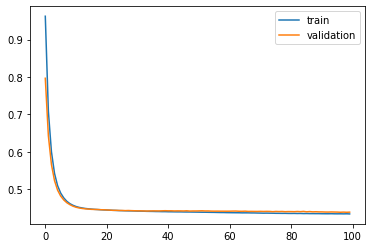

Time to train LSTM:  145.4008367061615
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 39s - loss: 1.0289 - val_loss: 0.8088

Epoch 00001: val_loss improved from inf to 0.80884, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7263 - val_loss: 0.6493

Epoch 00002: val_loss improved from 0.80884 to 0.64931, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.6121 - val_loss: 0.5719

Epoch 00003: val_loss improved from 0.64931 to 0.57189, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5516 - val_loss: 0.5272

Epoch 00004: val_loss improved from 0.57189 to 0.52720, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5157 - val_loss: 0.4996

Epoch 00005: val_loss improved from 0.52720 to 0.49964, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4931 - val_loss: 0.4825

Epoch 00006: val_loss improved from 0.49964 to 0.48252, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4786 - val_loss: 0.4718

Epoc


Epoch 00062: val_loss did not improve from 0.44099
Epoch 63/100
 - 1s - loss: 0.4382 - val_loss: 0.4412

Epoch 00063: val_loss did not improve from 0.44099
Epoch 64/100
 - 1s - loss: 0.4381 - val_loss: 0.4411

Epoch 00064: val_loss did not improve from 0.44099
Epoch 65/100
 - 1s - loss: 0.4380 - val_loss: 0.4408

Epoch 00065: val_loss improved from 0.44099 to 0.44084, saving model to val_weights2.hdf5
Epoch 66/100
 - 1s - loss: 0.4380 - val_loss: 0.4411

Epoch 00066: val_loss did not improve from 0.44084
Epoch 67/100
 - 1s - loss: 0.4378 - val_loss: 0.4409

Epoch 00067: val_loss did not improve from 0.44084
Epoch 68/100
 - 1s - loss: 0.4377 - val_loss: 0.4408

Epoch 00068: val_loss improved from 0.44084 to 0.44077, saving model to val_weights2.hdf5
Epoch 69/100
 - 1s - loss: 0.4379 - val_loss: 0.4410

Epoch 00069: val_loss did not improve from 0.44077
Epoch 70/100
 - 1s - loss: 0.4376 - val_loss: 0.4411

Epoch 00070: val_loss did not improve from 0.44077
Epoch 71/100
 - 1s - loss: 0.4

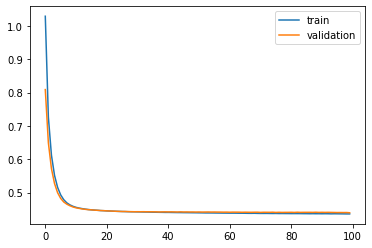

Time to train LSTM:  147.95374178886414


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f894469d240>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 40s - loss: 0.9946 - val_loss: 0.8179

Epoch 00001: val_loss improved from inf to 0.81791, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.7280 - val_loss: 0.6511

Epoch 00002: val_loss improved from 0.81791 to 0.65114, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.6040 - val_loss: 0.5687

Epoch 00003: val_loss improved from 0.65114 to 0.56867, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5422 - val_loss: 0.5255

Epoch 00004: val_loss improved from 0.56867 to 0.52550, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5093 - val_loss: 0.5016

Epoch 00005: val_loss improved from 0.52550 to 0.50158, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4901 - val_loss: 0.4865

Epoch 00006: val_loss improved from 0.50158 to 0.48648, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4774 - val_loss: 0.4762

Epoch 00007: val_loss improved from 0.48648

 - 1s - loss: 0.4353 - val_loss: 0.4438

Epoch 00062: val_loss improved from 0.44401 to 0.44375, saving model to val_weights3.hdf5
Epoch 63/100
 - 1s - loss: 0.4351 - val_loss: 0.4440

Epoch 00063: val_loss did not improve from 0.44375
Epoch 64/100
 - 1s - loss: 0.4353 - val_loss: 0.4440

Epoch 00064: val_loss did not improve from 0.44375
Epoch 65/100
 - 1s - loss: 0.4351 - val_loss: 0.4441

Epoch 00065: val_loss did not improve from 0.44375
Epoch 66/100
 - 1s - loss: 0.4348 - val_loss: 0.4439

Epoch 00066: val_loss did not improve from 0.44375
Epoch 67/100
 - 1s - loss: 0.4349 - val_loss: 0.4439

Epoch 00067: val_loss did not improve from 0.44375
Epoch 68/100
 - 1s - loss: 0.4350 - val_loss: 0.4438

Epoch 00068: val_loss did not improve from 0.44375
Epoch 69/100
 - 1s - loss: 0.4347 - val_loss: 0.4439

Epoch 00069: val_loss did not improve from 0.44375
Epoch 70/100
 - 1s - loss: 0.4349 - val_loss: 0.4433

Epoch 00070: val_loss improved from 0.44375 to 0.44333, saving model to val_weig

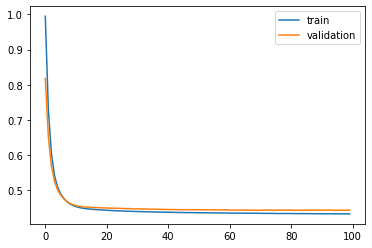

Time to train LSTM:  149.11047172546387
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 41s - loss: 1.2064 - val_loss: 0.8950

Epoch 00001: val_loss improved from inf to 0.89505, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.8009 - val_loss: 0.7131

Epoch 00002: val_loss improved from 0.89505 to 0.71307, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6673 - val_loss: 0.6190

Epoch 00003: val_loss improved from 0.71307 to 0.61900, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5946 - val_loss: 0.5646

Epoch 00004: val_loss improved from 0.61900 to 0.56464, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5508 - val_loss: 0.5310

Epoch 00005: val_loss improved from 0.56464 to 0.53098, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.5230 - val_loss: 0.5084

Epoch 00006: val_loss improved from 0.53098 to 0.50838, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.5047 - val_loss: 0.4926

Epo

 - 1s - loss: 0.4414 - val_loss: 0.4425

Epoch 00064: val_loss did not improve from 0.44203
Epoch 65/100
 - 1s - loss: 0.4414 - val_loss: 0.4424

Epoch 00065: val_loss did not improve from 0.44203
Epoch 66/100
 - 1s - loss: 0.4413 - val_loss: 0.4420

Epoch 00066: val_loss improved from 0.44203 to 0.44199, saving model to val_weights4.hdf5
Epoch 67/100
 - 1s - loss: 0.4412 - val_loss: 0.4423

Epoch 00067: val_loss did not improve from 0.44199
Epoch 68/100
 - 1s - loss: 0.4412 - val_loss: 0.4425

Epoch 00068: val_loss did not improve from 0.44199
Epoch 69/100
 - 1s - loss: 0.4410 - val_loss: 0.4425

Epoch 00069: val_loss did not improve from 0.44199
Epoch 70/100
 - 1s - loss: 0.4411 - val_loss: 0.4425

Epoch 00070: val_loss did not improve from 0.44199
Epoch 71/100
 - 1s - loss: 0.4409 - val_loss: 0.4421

Epoch 00071: val_loss did not improve from 0.44199
Epoch 72/100
 - 1s - loss: 0.4408 - val_loss: 0.4424

Epoch 00072: val_loss did not improve from 0.44199
Epoch 73/100
 - 1s - loss: 0.

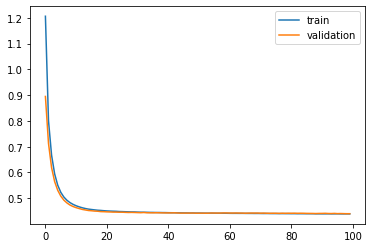

Time to train LSTM:  150.9088683128357
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 41s - loss: 0.9611 - val_loss: 0.7927

Epoch 00001: val_loss improved from inf to 0.79271, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6982 - val_loss: 0.6210

Epoch 00002: val_loss improved from 0.79271 to 0.62103, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5804 - val_loss: 0.5483

Epoch 00003: val_loss improved from 0.62103 to 0.54830, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5261 - val_loss: 0.5101

Epoch 00004: val_loss improved from 0.54830 to 0.51010, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.4962 - val_loss: 0.4882

Epoch 00005: val_loss improved from 0.51010 to 0.48822, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4786 - val_loss: 0.4760

Epoch 00006: val_loss improved from 0.48822 to 0.47600, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4680 - val_loss: 0.4682

Epoc


Epoch 00061: val_loss improved from 0.44317 to 0.44309, saving model to val_weights5.hdf5
Epoch 62/100
 - 1s - loss: 0.4375 - val_loss: 0.4431

Epoch 00062: val_loss did not improve from 0.44309
Epoch 63/100
 - 1s - loss: 0.4374 - val_loss: 0.4430

Epoch 00063: val_loss improved from 0.44309 to 0.44301, saving model to val_weights5.hdf5
Epoch 64/100
 - 1s - loss: 0.4374 - val_loss: 0.4430

Epoch 00064: val_loss improved from 0.44301 to 0.44300, saving model to val_weights5.hdf5
Epoch 65/100
 - 1s - loss: 0.4373 - val_loss: 0.4431

Epoch 00065: val_loss did not improve from 0.44300
Epoch 66/100
 - 1s - loss: 0.4373 - val_loss: 0.4430

Epoch 00066: val_loss did not improve from 0.44300
Epoch 67/100
 - 1s - loss: 0.4372 - val_loss: 0.4429

Epoch 00067: val_loss improved from 0.44300 to 0.44290, saving model to val_weights5.hdf5
Epoch 68/100
 - 1s - loss: 0.4371 - val_loss: 0.4430

Epoch 00068: val_loss did not improve from 0.44290
Epoch 69/100
 - 1s - loss: 0.4371 - val_loss: 0.4431

Epo

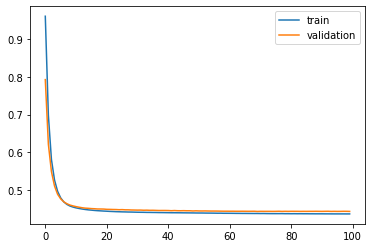

Time to train LSTM:  151.24222135543823
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 41s - loss: 1.0581 - val_loss: 0.8537

Epoch 00001: val_loss improved from inf to 0.85375, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7580 - val_loss: 0.6716

Epoch 00002: val_loss improved from 0.85375 to 0.67164, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.6235 - val_loss: 0.5816

Epoch 00003: val_loss improved from 0.67164 to 0.58165, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5558 - val_loss: 0.5333

Epoch 00004: val_loss improved from 0.58165 to 0.53328, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5184 - val_loss: 0.5055

Epoch 00005: val_loss improved from 0.53328 to 0.50551, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4960 - val_loss: 0.4879

Epoch 00006: val_loss improved from 0.50551 to 0.48794, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4813 - val_loss: 0.4759

Epo

 - 1s - loss: 0.4384 - val_loss: 0.4404

Epoch 00063: val_loss did not improve from 0.44013
Epoch 64/100
 - 1s - loss: 0.4382 - val_loss: 0.4404

Epoch 00064: val_loss did not improve from 0.44013
Epoch 65/100
 - 1s - loss: 0.4382 - val_loss: 0.4404

Epoch 00065: val_loss did not improve from 0.44013
Epoch 66/100
 - 1s - loss: 0.4380 - val_loss: 0.4406

Epoch 00066: val_loss did not improve from 0.44013
Epoch 67/100
 - 1s - loss: 0.4381 - val_loss: 0.4401

Epoch 00067: val_loss improved from 0.44013 to 0.44012, saving model to val_weights1.hdf5
Epoch 68/100
 - 1s - loss: 0.4379 - val_loss: 0.4404

Epoch 00068: val_loss did not improve from 0.44012
Epoch 69/100
 - 1s - loss: 0.4380 - val_loss: 0.4404

Epoch 00069: val_loss did not improve from 0.44012
Epoch 70/100
 - 1s - loss: 0.4379 - val_loss: 0.4402

Epoch 00070: val_loss did not improve from 0.44012
Epoch 71/100
 - 1s - loss: 0.4380 - val_loss: 0.4401

Epoch 00071: val_loss improved from 0.44012 to 0.44008, saving model to val_weig

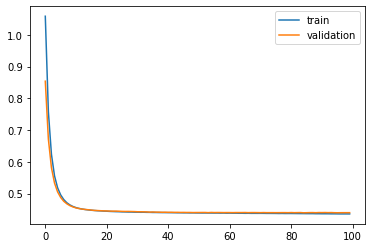

Time to train LSTM:  150.7367377281189
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 42s - loss: 0.9083 - val_loss: 0.7602

Epoch 00001: val_loss improved from inf to 0.76017, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6867 - val_loss: 0.6250

Epoch 00002: val_loss improved from 0.76017 to 0.62498, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5868 - val_loss: 0.5529

Epoch 00003: val_loss improved from 0.62498 to 0.55285, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5314 - val_loss: 0.5115

Epoch 00004: val_loss improved from 0.55285 to 0.51151, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.4990 - val_loss: 0.4866

Epoch 00005: val_loss improved from 0.51151 to 0.48658, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4788 - val_loss: 0.4708

Epoch 00006: val_loss improved from 0.48658 to 0.47080, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4671 - val_loss: 0.4624

Epoc


Epoch 00061: val_loss did not improve from 0.43833
Epoch 62/100
 - 1s - loss: 0.4363 - val_loss: 0.4385

Epoch 00062: val_loss did not improve from 0.43833
Epoch 63/100
 - 1s - loss: 0.4363 - val_loss: 0.4386

Epoch 00063: val_loss did not improve from 0.43833
Epoch 64/100
 - 1s - loss: 0.4363 - val_loss: 0.4384

Epoch 00064: val_loss did not improve from 0.43833
Epoch 65/100
 - 1s - loss: 0.4362 - val_loss: 0.4385

Epoch 00065: val_loss did not improve from 0.43833
Epoch 66/100
 - 1s - loss: 0.4361 - val_loss: 0.4387

Epoch 00066: val_loss did not improve from 0.43833
Epoch 67/100
 - 1s - loss: 0.4362 - val_loss: 0.4383

Epoch 00067: val_loss did not improve from 0.43833
Epoch 68/100
 - 1s - loss: 0.4361 - val_loss: 0.4387

Epoch 00068: val_loss did not improve from 0.43833
Epoch 69/100
 - 1s - loss: 0.4359 - val_loss: 0.4388

Epoch 00069: val_loss did not improve from 0.43833
Epoch 70/100
 - 1s - loss: 0.4360 - val_loss: 0.4388

Epoch 00070: val_loss did not improve from 0.43833
Epo

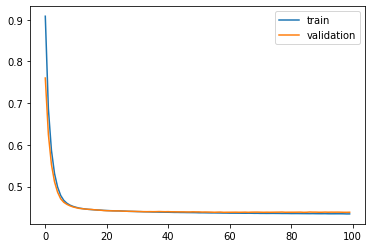

Time to train LSTM:  151.55221462249756
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 45s - loss: 0.9424 - val_loss: 0.7827

Epoch 00001: val_loss improved from inf to 0.78266, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6929 - val_loss: 0.6290

Epoch 00002: val_loss improved from 0.78266 to 0.62896, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5848 - val_loss: 0.5558

Epoch 00003: val_loss improved from 0.62896 to 0.55583, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5294 - val_loss: 0.5152

Epoch 00004: val_loss improved from 0.55583 to 0.51518, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.4978 - val_loss: 0.4921

Epoch 00005: val_loss improved from 0.51518 to 0.49213, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4797 - val_loss: 0.4787

Epoch 00006: val_loss improved from 0.49213 to 0.47872, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4692 - val_loss: 0.4709

Epo

 - 1s - loss: 0.4364 - val_loss: 0.4440

Epoch 00061: val_loss improved from 0.44447 to 0.44402, saving model to val_weights3.hdf5
Epoch 62/100
 - 1s - loss: 0.4364 - val_loss: 0.4447

Epoch 00062: val_loss did not improve from 0.44402
Epoch 63/100
 - 1s - loss: 0.4363 - val_loss: 0.4441

Epoch 00063: val_loss did not improve from 0.44402
Epoch 64/100
 - 1s - loss: 0.4362 - val_loss: 0.4444

Epoch 00064: val_loss did not improve from 0.44402
Epoch 65/100
 - 1s - loss: 0.4361 - val_loss: 0.4440

Epoch 00065: val_loss did not improve from 0.44402
Epoch 66/100
 - 1s - loss: 0.4360 - val_loss: 0.4442

Epoch 00066: val_loss did not improve from 0.44402
Epoch 67/100
 - 1s - loss: 0.4358 - val_loss: 0.4440

Epoch 00067: val_loss improved from 0.44402 to 0.44400, saving model to val_weights3.hdf5
Epoch 68/100
 - 1s - loss: 0.4359 - val_loss: 0.4445

Epoch 00068: val_loss did not improve from 0.44400
Epoch 69/100
 - 1s - loss: 0.4358 - val_loss: 0.4439

Epoch 00069: val_loss improved from 0.444

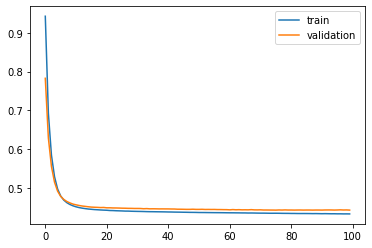

Time to train LSTM:  155.94983792304993
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 42s - loss: 1.0051 - val_loss: 0.8057

Epoch 00001: val_loss improved from inf to 0.80571, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7230 - val_loss: 0.6419

Epoch 00002: val_loss improved from 0.80571 to 0.64188, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6043 - val_loss: 0.5619

Epoch 00003: val_loss improved from 0.64188 to 0.56186, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5435 - val_loss: 0.5176

Epoch 00004: val_loss improved from 0.56186 to 0.51757, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5094 - val_loss: 0.4909

Epoch 00005: val_loss improved from 0.51757 to 0.49092, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4882 - val_loss: 0.4746

Epoch 00006: val_loss improved from 0.49092 to 0.47455, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4744 - val_loss: 0.4641

Epo

 - 1s - loss: 0.4374 - val_loss: 0.4391

Epoch 00065: val_loss did not improve from 0.43863
Epoch 66/100
 - 1s - loss: 0.4374 - val_loss: 0.4387

Epoch 00066: val_loss did not improve from 0.43863
Epoch 67/100
 - 1s - loss: 0.4371 - val_loss: 0.4387

Epoch 00067: val_loss did not improve from 0.43863
Epoch 68/100
 - 1s - loss: 0.4370 - val_loss: 0.4389

Epoch 00068: val_loss did not improve from 0.43863
Epoch 69/100
 - 1s - loss: 0.4370 - val_loss: 0.4391

Epoch 00069: val_loss did not improve from 0.43863
Epoch 70/100
 - 1s - loss: 0.4369 - val_loss: 0.4389

Epoch 00070: val_loss did not improve from 0.43863
Epoch 71/100
 - 1s - loss: 0.4369 - val_loss: 0.4391

Epoch 00071: val_loss did not improve from 0.43863
Epoch 72/100
 - 1s - loss: 0.4368 - val_loss: 0.4388

Epoch 00072: val_loss did not improve from 0.43863
Epoch 73/100
 - 1s - loss: 0.4366 - val_loss: 0.4390

Epoch 00073: val_loss did not improve from 0.43863
Epoch 74/100
 - 1s - loss: 0.4365 - val_loss: 0.4388

Epoch 00074: v

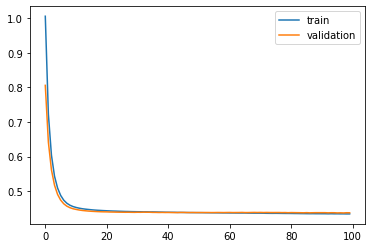

Time to train LSTM:  152.0183687210083
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 43s - loss: 1.0107 - val_loss: 0.8208

Epoch 00001: val_loss improved from inf to 0.82077, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7325 - val_loss: 0.6530

Epoch 00002: val_loss improved from 0.82077 to 0.65296, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6094 - val_loss: 0.5714

Epoch 00003: val_loss improved from 0.65296 to 0.57142, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5465 - val_loss: 0.5263

Epoch 00004: val_loss improved from 0.57142 to 0.52626, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5103 - val_loss: 0.4996

Epoch 00005: val_loss improved from 0.52626 to 0.49960, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4882 - val_loss: 0.4829

Epoch 00006: val_loss improved from 0.49960 to 0.48292, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4739 - val_loss: 0.4721

Epoc

 - 1s - loss: 0.4358 - val_loss: 0.4442

Epoch 00065: val_loss did not improve from 0.44400
Epoch 66/100
 - 1s - loss: 0.4357 - val_loss: 0.4443

Epoch 00066: val_loss did not improve from 0.44400
Epoch 67/100
 - 1s - loss: 0.4356 - val_loss: 0.4441

Epoch 00067: val_loss did not improve from 0.44400
Epoch 68/100
 - 1s - loss: 0.4356 - val_loss: 0.4443

Epoch 00068: val_loss did not improve from 0.44400
Epoch 69/100
 - 1s - loss: 0.4356 - val_loss: 0.4441

Epoch 00069: val_loss did not improve from 0.44400
Epoch 70/100
 - 1s - loss: 0.4355 - val_loss: 0.4441

Epoch 00070: val_loss did not improve from 0.44400
Epoch 71/100
 - 1s - loss: 0.4354 - val_loss: 0.4439

Epoch 00071: val_loss improved from 0.44400 to 0.44392, saving model to val_weights5.hdf5
Epoch 72/100
 - 1s - loss: 0.4354 - val_loss: 0.4441

Epoch 00072: val_loss did not improve from 0.44392
Epoch 73/100
 - 1s - loss: 0.4353 - val_loss: 0.4438

Epoch 00073: val_loss improved from 0.44392 to 0.44378, saving model to val_weig

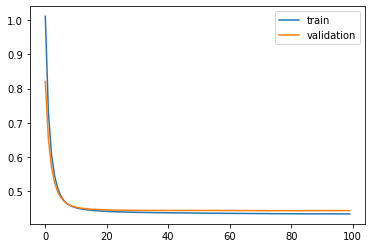

Time to train LSTM:  153.51742672920227
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 46s - loss: 0.8606 - val_loss: 0.7220

Epoch 00001: val_loss improved from inf to 0.72202, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6590 - val_loss: 0.6039

Epoch 00002: val_loss improved from 0.72202 to 0.60393, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5748 - val_loss: 0.5450

Epoch 00003: val_loss improved from 0.60393 to 0.54496, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5289 - val_loss: 0.5109

Epoch 00004: val_loss improved from 0.54496 to 0.51093, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5018 - val_loss: 0.4896

Epoch 00005: val_loss improved from 0.51093 to 0.48962, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4845 - val_loss: 0.4759

Epoch 00006: val_loss improved from 0.48962 to 0.47587, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4723 - val_loss: 0.4664

Epo

 - 1s - loss: 0.4368 - val_loss: 0.4421

Epoch 00066: val_loss did not improve from 0.44164
Epoch 67/100
 - 1s - loss: 0.4368 - val_loss: 0.4419

Epoch 00067: val_loss did not improve from 0.44164
Epoch 68/100
 - 1s - loss: 0.4368 - val_loss: 0.4419

Epoch 00068: val_loss did not improve from 0.44164
Epoch 69/100
 - 1s - loss: 0.4366 - val_loss: 0.4417

Epoch 00069: val_loss did not improve from 0.44164
Epoch 70/100
 - 1s - loss: 0.4366 - val_loss: 0.4419

Epoch 00070: val_loss did not improve from 0.44164
Epoch 71/100
 - 1s - loss: 0.4366 - val_loss: 0.4416

Epoch 00071: val_loss improved from 0.44164 to 0.44156, saving model to val_weights1.hdf5
Epoch 72/100
 - 1s - loss: 0.4367 - val_loss: 0.4418

Epoch 00072: val_loss did not improve from 0.44156
Epoch 73/100
 - 1s - loss: 0.4367 - val_loss: 0.4422

Epoch 00073: val_loss did not improve from 0.44156
Epoch 74/100
 - 1s - loss: 0.4367 - val_loss: 0.4420

Epoch 00074: val_loss did not improve from 0.44156
Epoch 75/100
 - 1s - loss: 0.

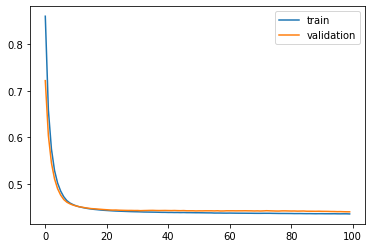

Time to train LSTM:  156.2842502593994
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 44s - loss: 1.0139 - val_loss: 0.7875

Epoch 00001: val_loss improved from inf to 0.78749, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7078 - val_loss: 0.6421

Epoch 00002: val_loss improved from 0.78749 to 0.64205, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.6066 - val_loss: 0.5735

Epoch 00003: val_loss improved from 0.64205 to 0.57348, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5533 - val_loss: 0.5345

Epoch 00004: val_loss improved from 0.57348 to 0.53453, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5219 - val_loss: 0.5101

Epoch 00005: val_loss improved from 0.53453 to 0.51008, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.5020 - val_loss: 0.4936

Epoch 00006: val_loss improved from 0.51008 to 0.49358, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4884 - val_loss: 0.4825

Epoc

 - 1s - loss: 0.4369 - val_loss: 0.4400

Epoch 00063: val_loss did not improve from 0.43965
Epoch 64/100
 - 1s - loss: 0.4370 - val_loss: 0.4414

Epoch 00064: val_loss did not improve from 0.43965
Epoch 65/100
 - 1s - loss: 0.4378 - val_loss: 0.4409

Epoch 00065: val_loss did not improve from 0.43965
Epoch 66/100
 - 1s - loss: 0.4377 - val_loss: 0.4397

Epoch 00066: val_loss did not improve from 0.43965
Epoch 67/100
 - 1s - loss: 0.4372 - val_loss: 0.4397

Epoch 00067: val_loss did not improve from 0.43965
Epoch 68/100
 - 1s - loss: 0.4365 - val_loss: 0.4400

Epoch 00068: val_loss did not improve from 0.43965
Epoch 69/100
 - 1s - loss: 0.4366 - val_loss: 0.4399

Epoch 00069: val_loss did not improve from 0.43965
Epoch 70/100
 - 1s - loss: 0.4362 - val_loss: 0.4394

Epoch 00070: val_loss improved from 0.43965 to 0.43936, saving model to val_weights2.hdf5
Epoch 71/100
 - 1s - loss: 0.4367 - val_loss: 0.4399

Epoch 00071: val_loss did not improve from 0.43936
Epoch 72/100
 - 1s - loss: 0.

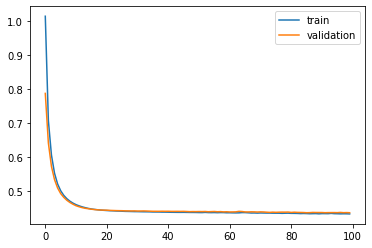

Time to train LSTM:  155.76428604125977
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 44s - loss: 0.8480 - val_loss: 0.7168

Epoch 00001: val_loss improved from inf to 0.71681, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6529 - val_loss: 0.6037

Epoch 00002: val_loss improved from 0.71681 to 0.60375, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5700 - val_loss: 0.5460

Epoch 00003: val_loss improved from 0.60375 to 0.54598, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5256 - val_loss: 0.5129

Epoch 00004: val_loss improved from 0.54598 to 0.51290, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.4992 - val_loss: 0.4928

Epoch 00005: val_loss improved from 0.51290 to 0.49284, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4826 - val_loss: 0.4803

Epoch 00006: val_loss improved from 0.49284 to 0.48033, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4714 - val_loss: 0.4716

Epo


Epoch 00062: val_loss improved from 0.44582 to 0.44576, saving model to val_weights3.hdf5
Epoch 63/100
 - 1s - loss: 0.4360 - val_loss: 0.4459

Epoch 00063: val_loss did not improve from 0.44576
Epoch 64/100
 - 1s - loss: 0.4359 - val_loss: 0.4460

Epoch 00064: val_loss did not improve from 0.44576
Epoch 65/100
 - 1s - loss: 0.4358 - val_loss: 0.4459

Epoch 00065: val_loss did not improve from 0.44576
Epoch 66/100
 - 1s - loss: 0.4357 - val_loss: 0.4461

Epoch 00066: val_loss did not improve from 0.44576
Epoch 67/100
 - 1s - loss: 0.4356 - val_loss: 0.4461

Epoch 00067: val_loss did not improve from 0.44576
Epoch 68/100
 - 1s - loss: 0.4357 - val_loss: 0.4461

Epoch 00068: val_loss did not improve from 0.44576
Epoch 69/100
 - 1s - loss: 0.4356 - val_loss: 0.4464

Epoch 00069: val_loss did not improve from 0.44576
Epoch 70/100
 - 1s - loss: 0.4355 - val_loss: 0.4464

Epoch 00070: val_loss did not improve from 0.44576
Epoch 71/100
 - 1s - loss: 0.4355 - val_loss: 0.4464

Epoch 00071: va

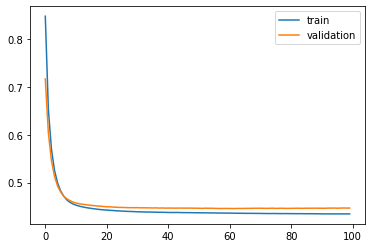

Time to train LSTM:  157.91288208961487
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 45s - loss: 0.9387 - val_loss: 0.7761

Epoch 00001: val_loss improved from inf to 0.77610, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7054 - val_loss: 0.6263

Epoch 00002: val_loss improved from 0.77610 to 0.62632, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5906 - val_loss: 0.5506

Epoch 00003: val_loss improved from 0.62632 to 0.55059, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5354 - val_loss: 0.5120

Epoch 00004: val_loss improved from 0.55059 to 0.51195, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5057 - val_loss: 0.4895

Epoch 00005: val_loss improved from 0.51195 to 0.48949, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4877 - val_loss: 0.4752

Epoch 00006: val_loss improved from 0.48949 to 0.47521, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4757 - val_loss: 0.4653

Epo


Epoch 00063: val_loss improved from 0.43905 to 0.43896, saving model to val_weights4.hdf5
Epoch 64/100
 - 1s - loss: 0.4367 - val_loss: 0.4390

Epoch 00064: val_loss did not improve from 0.43896
Epoch 65/100
 - 1s - loss: 0.4366 - val_loss: 0.4391

Epoch 00065: val_loss did not improve from 0.43896
Epoch 66/100
 - 1s - loss: 0.4366 - val_loss: 0.4389

Epoch 00066: val_loss improved from 0.43896 to 0.43893, saving model to val_weights4.hdf5
Epoch 67/100
 - 1s - loss: 0.4366 - val_loss: 0.4392

Epoch 00067: val_loss did not improve from 0.43893
Epoch 68/100
 - 1s - loss: 0.4365 - val_loss: 0.4390

Epoch 00068: val_loss did not improve from 0.43893
Epoch 69/100
 - 1s - loss: 0.4366 - val_loss: 0.4393

Epoch 00069: val_loss did not improve from 0.43893
Epoch 70/100
 - 1s - loss: 0.4364 - val_loss: 0.4390

Epoch 00070: val_loss did not improve from 0.43893
Epoch 71/100
 - 1s - loss: 0.4364 - val_loss: 0.4391

Epoch 00071: val_loss did not improve from 0.43893
Epoch 72/100
 - 1s - loss: 0.4

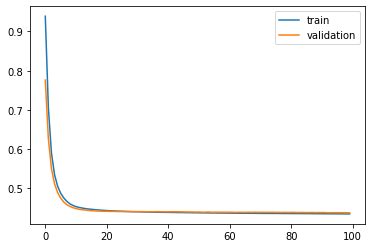

Time to train LSTM:  156.24971413612366
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 101s - loss: 0.9828 - val_loss: 0.7972

Epoch 00001: val_loss improved from inf to 0.79725, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.7004 - val_loss: 0.6226

Epoch 00002: val_loss improved from 0.79725 to 0.62256, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5830 - val_loss: 0.5557

Epoch 00003: val_loss improved from 0.62256 to 0.55569, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5329 - val_loss: 0.5206

Epoch 00004: val_loss improved from 0.55569 to 0.52056, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5051 - val_loss: 0.4997

Epoch 00005: val_loss improved from 0.52056 to 0.49971, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4880 - val_loss: 0.4855

Epoch 00006: val_loss improved from 0.49971 to 0.48554, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4759 - val_loss: 0.4754

Ep

 - 1s - loss: 0.4358 - val_loss: 0.4443

Epoch 00061: val_loss did not improve from 0.44388
Epoch 62/100
 - 1s - loss: 0.4357 - val_loss: 0.4439

Epoch 00062: val_loss did not improve from 0.44388
Epoch 63/100
 - 1s - loss: 0.4357 - val_loss: 0.4441

Epoch 00063: val_loss did not improve from 0.44388
Epoch 64/100
 - 1s - loss: 0.4355 - val_loss: 0.4441

Epoch 00064: val_loss did not improve from 0.44388
Epoch 65/100
 - 1s - loss: 0.4354 - val_loss: 0.4439

Epoch 00065: val_loss did not improve from 0.44388
Epoch 66/100
 - 1s - loss: 0.4353 - val_loss: 0.4442

Epoch 00066: val_loss did not improve from 0.44388
Epoch 67/100
 - 1s - loss: 0.4353 - val_loss: 0.4441

Epoch 00067: val_loss did not improve from 0.44388
Epoch 68/100
 - 1s - loss: 0.4352 - val_loss: 0.4441

Epoch 00068: val_loss did not improve from 0.44388
Epoch 69/100
 - 1s - loss: 0.4352 - val_loss: 0.4439

Epoch 00069: val_loss did not improve from 0.44388
Epoch 70/100
 - 1s - loss: 0.4352 - val_loss: 0.4442

Epoch 00070: v

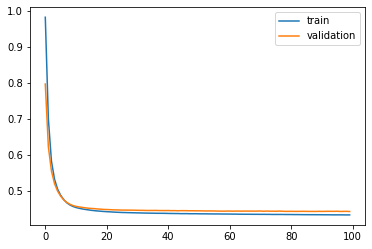

Time to train LSTM:  215.35880208015442
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 45s - loss: 0.9190 - val_loss: 0.7629

Epoch 00001: val_loss improved from inf to 0.76292, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6867 - val_loss: 0.6184

Epoch 00002: val_loss improved from 0.76292 to 0.61840, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5853 - val_loss: 0.5530

Epoch 00003: val_loss improved from 0.61840 to 0.55301, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5344 - val_loss: 0.5158

Epoch 00004: val_loss improved from 0.55301 to 0.51583, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5048 - val_loss: 0.4931

Epoch 00005: val_loss improved from 0.51583 to 0.49312, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4864 - val_loss: 0.4785

Epoch 00006: val_loss improved from 0.49312 to 0.47853, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4742 - val_loss: 0.4683

Epo

 - 1s - loss: 0.4363 - val_loss: 0.4398

Epoch 00063: val_loss improved from 0.44027 to 0.43983, saving model to val_weights1.hdf5
Epoch 64/100
 - 1s - loss: 0.4362 - val_loss: 0.4401

Epoch 00064: val_loss did not improve from 0.43983
Epoch 65/100
 - 1s - loss: 0.4361 - val_loss: 0.4401

Epoch 00065: val_loss did not improve from 0.43983
Epoch 66/100
 - 1s - loss: 0.4361 - val_loss: 0.4399

Epoch 00066: val_loss did not improve from 0.43983
Epoch 67/100
 - 1s - loss: 0.4359 - val_loss: 0.4399

Epoch 00067: val_loss did not improve from 0.43983
Epoch 68/100
 - 1s - loss: 0.4358 - val_loss: 0.4399

Epoch 00068: val_loss did not improve from 0.43983
Epoch 69/100
 - 1s - loss: 0.4359 - val_loss: 0.4398

Epoch 00069: val_loss improved from 0.43983 to 0.43982, saving model to val_weights1.hdf5
Epoch 70/100
 - 1s - loss: 0.4359 - val_loss: 0.4400

Epoch 00070: val_loss did not improve from 0.43982
Epoch 71/100
 - 1s - loss: 0.4359 - val_loss: 0.4400

Epoch 00071: val_loss did not improve fro

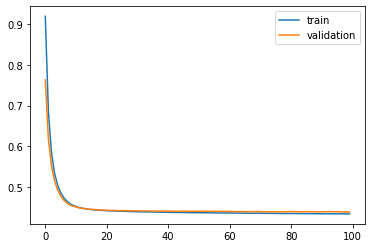

Time to train LSTM:  158.97466492652893
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 45s - loss: 0.9297 - val_loss: 0.7731

Epoch 00001: val_loss improved from inf to 0.77309, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.7010 - val_loss: 0.6310

Epoch 00002: val_loss improved from 0.77309 to 0.63099, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5941 - val_loss: 0.5570

Epoch 00003: val_loss improved from 0.63099 to 0.55702, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5401 - val_loss: 0.5196

Epoch 00004: val_loss improved from 0.55702 to 0.51961, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5101 - val_loss: 0.4970

Epoch 00005: val_loss improved from 0.51961 to 0.49697, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4911 - val_loss: 0.4812

Epoch 00006: val_loss improved from 0.49697 to 0.48117, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4778 - val_loss: 0.4699

Epo

 - 1s - loss: 0.4362 - val_loss: 0.4391

Epoch 00061: val_loss did not improve from 0.43908
Epoch 62/100
 - 1s - loss: 0.4361 - val_loss: 0.4390

Epoch 00062: val_loss improved from 0.43908 to 0.43901, saving model to val_weights2.hdf5
Epoch 63/100
 - 1s - loss: 0.4360 - val_loss: 0.4389

Epoch 00063: val_loss improved from 0.43901 to 0.43889, saving model to val_weights2.hdf5
Epoch 64/100
 - 1s - loss: 0.4359 - val_loss: 0.4388

Epoch 00064: val_loss improved from 0.43889 to 0.43880, saving model to val_weights2.hdf5
Epoch 65/100
 - 1s - loss: 0.4357 - val_loss: 0.4386

Epoch 00065: val_loss improved from 0.43880 to 0.43859, saving model to val_weights2.hdf5
Epoch 66/100
 - 1s - loss: 0.4356 - val_loss: 0.4385

Epoch 00066: val_loss improved from 0.43859 to 0.43847, saving model to val_weights2.hdf5
Epoch 67/100
 - 1s - loss: 0.4354 - val_loss: 0.4385

Epoch 00067: val_loss did not improve from 0.43847
Epoch 68/100
 - 1s - loss: 0.4355 - val_loss: 0.4385

Epoch 00068: val_loss did not

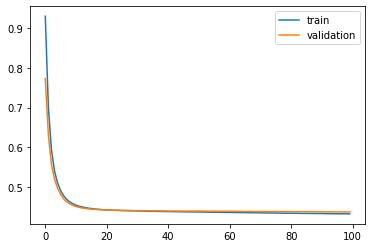

Time to train LSTM:  159.71490216255188
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 46s - loss: 0.8954 - val_loss: 0.7449

Epoch 00001: val_loss improved from inf to 0.74489, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6766 - val_loss: 0.6213

Epoch 00002: val_loss improved from 0.74489 to 0.62131, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5842 - val_loss: 0.5592

Epoch 00003: val_loss improved from 0.62131 to 0.55917, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5351 - val_loss: 0.5221

Epoch 00004: val_loss improved from 0.55917 to 0.52213, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5057 - val_loss: 0.4994

Epoch 00005: val_loss improved from 0.52213 to 0.49942, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4874 - val_loss: 0.4845

Epoch 00006: val_loss improved from 0.49942 to 0.48449, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4752 - val_loss: 0.4748

Epo

 - 1s - loss: 0.4357 - val_loss: 0.4440

Epoch 00061: val_loss improved from 0.44405 to 0.44402, saving model to val_weights3.hdf5
Epoch 62/100
 - 1s - loss: 0.4356 - val_loss: 0.4440

Epoch 00062: val_loss did not improve from 0.44402
Epoch 63/100
 - 1s - loss: 0.4356 - val_loss: 0.4441

Epoch 00063: val_loss did not improve from 0.44402
Epoch 64/100
 - 1s - loss: 0.4354 - val_loss: 0.4440

Epoch 00064: val_loss did not improve from 0.44402
Epoch 65/100
 - 1s - loss: 0.4352 - val_loss: 0.4441

Epoch 00065: val_loss did not improve from 0.44402
Epoch 66/100
 - 1s - loss: 0.4353 - val_loss: 0.4441

Epoch 00066: val_loss did not improve from 0.44402
Epoch 67/100
 - 1s - loss: 0.4352 - val_loss: 0.4440

Epoch 00067: val_loss improved from 0.44402 to 0.44402, saving model to val_weights3.hdf5
Epoch 68/100
 - 1s - loss: 0.4351 - val_loss: 0.4440

Epoch 00068: val_loss did not improve from 0.44402
Epoch 69/100
 - 1s - loss: 0.4350 - val_loss: 0.4438

Epoch 00069: val_loss improved from 0.444

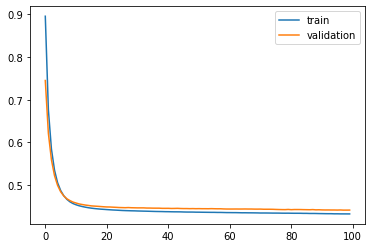

Time to train LSTM:  160.59890937805176
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 51s - loss: 1.0083 - val_loss: 0.8071

Epoch 00001: val_loss improved from inf to 0.80709, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7217 - val_loss: 0.6418

Epoch 00002: val_loss improved from 0.80709 to 0.64179, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6030 - val_loss: 0.5628

Epoch 00003: val_loss improved from 0.64179 to 0.56282, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5466 - val_loss: 0.5230

Epoch 00004: val_loss improved from 0.56282 to 0.52299, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5161 - val_loss: 0.4993

Epoch 00005: val_loss improved from 0.52299 to 0.49928, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4974 - val_loss: 0.4842

Epoch 00006: val_loss improved from 0.49928 to 0.48416, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4848 - val_loss: 0.4737

Epo

 - 1s - loss: 0.4370 - val_loss: 0.4378

Epoch 00063: val_loss did not improve from 0.43744
Epoch 64/100
 - 1s - loss: 0.4370 - val_loss: 0.4376

Epoch 00064: val_loss did not improve from 0.43744
Epoch 65/100
 - 1s - loss: 0.4369 - val_loss: 0.4375

Epoch 00065: val_loss did not improve from 0.43744
Epoch 66/100
 - 1s - loss: 0.4369 - val_loss: 0.4380

Epoch 00066: val_loss did not improve from 0.43744
Epoch 67/100
 - 1s - loss: 0.4369 - val_loss: 0.4374

Epoch 00067: val_loss improved from 0.43744 to 0.43741, saving model to val_weights4.hdf5
Epoch 68/100
 - 1s - loss: 0.4368 - val_loss: 0.4376

Epoch 00068: val_loss did not improve from 0.43741
Epoch 69/100
 - 1s - loss: 0.4367 - val_loss: 0.4378

Epoch 00069: val_loss did not improve from 0.43741
Epoch 70/100
 - 1s - loss: 0.4366 - val_loss: 0.4377

Epoch 00070: val_loss did not improve from 0.43741
Epoch 71/100
 - 1s - loss: 0.4365 - val_loss: 0.4374

Epoch 00071: val_loss did not improve from 0.43741
Epoch 72/100
 - 1s - loss: 0.

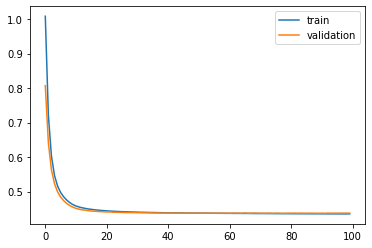

Time to train LSTM:  163.96641063690186
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 47s - loss: 0.9777 - val_loss: 0.7660

Epoch 00001: val_loss improved from inf to 0.76603, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6974 - val_loss: 0.6405

Epoch 00002: val_loss improved from 0.76603 to 0.64054, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.6020 - val_loss: 0.5740

Epoch 00003: val_loss improved from 0.64054 to 0.57405, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5512 - val_loss: 0.5369

Epoch 00004: val_loss improved from 0.57405 to 0.53691, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5215 - val_loss: 0.5137

Epoch 00005: val_loss improved from 0.53691 to 0.51373, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.5023 - val_loss: 0.4982

Epoch 00006: val_loss improved from 0.51373 to 0.49817, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4888 - val_loss: 0.4871

Epo

 - 1s - loss: 0.4355 - val_loss: 0.4440

Epoch 00062: val_loss did not improve from 0.44392
Epoch 63/100
 - 1s - loss: 0.4354 - val_loss: 0.4442

Epoch 00063: val_loss did not improve from 0.44392
Epoch 64/100
 - 1s - loss: 0.4353 - val_loss: 0.4442

Epoch 00064: val_loss did not improve from 0.44392
Epoch 65/100
 - 1s - loss: 0.4353 - val_loss: 0.4446

Epoch 00065: val_loss did not improve from 0.44392
Epoch 66/100
 - 1s - loss: 0.4354 - val_loss: 0.4441

Epoch 00066: val_loss did not improve from 0.44392
Epoch 67/100
 - 1s - loss: 0.4352 - val_loss: 0.4438

Epoch 00067: val_loss improved from 0.44392 to 0.44382, saving model to val_weights5.hdf5
Epoch 68/100
 - 1s - loss: 0.4350 - val_loss: 0.4439

Epoch 00068: val_loss did not improve from 0.44382
Epoch 69/100
 - 1s - loss: 0.4349 - val_loss: 0.4443

Epoch 00069: val_loss did not improve from 0.44382
Epoch 70/100
 - 1s - loss: 0.4351 - val_loss: 0.4438

Epoch 00070: val_loss did not improve from 0.44382
Epoch 71/100
 - 1s - loss: 0.

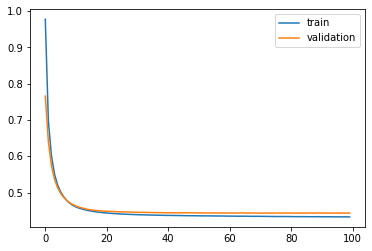

Time to train LSTM:  160.72673964500427
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 47s - loss: 1.0229 - val_loss: 0.7849

Epoch 00001: val_loss improved from inf to 0.78492, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.7025 - val_loss: 0.6314

Epoch 00002: val_loss improved from 0.78492 to 0.63139, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5977 - val_loss: 0.5669

Epoch 00003: val_loss improved from 0.63139 to 0.56688, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5474 - val_loss: 0.5288

Epoch 00004: val_loss improved from 0.56688 to 0.52876, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.5168 - val_loss: 0.5046

Epoch 00005: val_loss improved from 0.52876 to 0.50456, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4968 - val_loss: 0.4879

Epoch 00006: val_loss improved from 0.50456 to 0.48791, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4825 - val_loss: 0.4754

Epo

 - 1s - loss: 0.4380 - val_loss: 0.4406

Epoch 00060: val_loss did not improve from 0.44056
Epoch 61/100
 - 1s - loss: 0.4380 - val_loss: 0.4404

Epoch 00061: val_loss improved from 0.44056 to 0.44039, saving model to val_weights1.hdf5
Epoch 62/100
 - 1s - loss: 0.4379 - val_loss: 0.4406

Epoch 00062: val_loss did not improve from 0.44039
Epoch 63/100
 - 1s - loss: 0.4379 - val_loss: 0.4408

Epoch 00063: val_loss did not improve from 0.44039
Epoch 64/100
 - 1s - loss: 0.4377 - val_loss: 0.4405

Epoch 00064: val_loss did not improve from 0.44039
Epoch 65/100
 - 1s - loss: 0.4377 - val_loss: 0.4403

Epoch 00065: val_loss improved from 0.44039 to 0.44027, saving model to val_weights1.hdf5
Epoch 66/100
 - 1s - loss: 0.4375 - val_loss: 0.4400

Epoch 00066: val_loss improved from 0.44027 to 0.43999, saving model to val_weights1.hdf5
Epoch 67/100
 - 1s - loss: 0.4374 - val_loss: 0.4403

Epoch 00067: val_loss did not improve from 0.43999
Epoch 68/100
 - 1s - loss: 0.4373 - val_loss: 0.4402

Ep

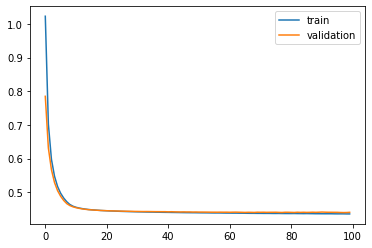

Time to train LSTM:  161.15237164497375
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 48s - loss: 0.9055 - val_loss: 0.7501

Epoch 00001: val_loss improved from inf to 0.75008, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6849 - val_loss: 0.6254

Epoch 00002: val_loss improved from 0.75008 to 0.62538, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5925 - val_loss: 0.5580

Epoch 00003: val_loss improved from 0.62538 to 0.55798, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5402 - val_loss: 0.5190

Epoch 00004: val_loss improved from 0.55798 to 0.51902, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.5085 - val_loss: 0.4950

Epoch 00005: val_loss improved from 0.51902 to 0.49500, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4886 - val_loss: 0.4791

Epoch 00006: val_loss improved from 0.49500 to 0.47913, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4757 - val_loss: 0.4688

Epo

 - 1s - loss: 0.4361 - val_loss: 0.4399

Epoch 00063: val_loss did not improve from 0.43983
Epoch 64/100
 - 1s - loss: 0.4360 - val_loss: 0.4400

Epoch 00064: val_loss did not improve from 0.43983
Epoch 65/100
 - 1s - loss: 0.4361 - val_loss: 0.4398

Epoch 00065: val_loss did not improve from 0.43983
Epoch 66/100
 - 1s - loss: 0.4358 - val_loss: 0.4398

Epoch 00066: val_loss improved from 0.43983 to 0.43979, saving model to val_weights2.hdf5
Epoch 67/100
 - 1s - loss: 0.4358 - val_loss: 0.4397

Epoch 00067: val_loss improved from 0.43979 to 0.43975, saving model to val_weights2.hdf5
Epoch 68/100
 - 1s - loss: 0.4357 - val_loss: 0.4399

Epoch 00068: val_loss did not improve from 0.43975
Epoch 69/100
 - 1s - loss: 0.4358 - val_loss: 0.4396

Epoch 00069: val_loss improved from 0.43975 to 0.43962, saving model to val_weights2.hdf5
Epoch 70/100
 - 1s - loss: 0.4356 - val_loss: 0.4398

Epoch 00070: val_loss did not improve from 0.43962
Epoch 71/100
 - 1s - loss: 0.4356 - val_loss: 0.4394

Ep

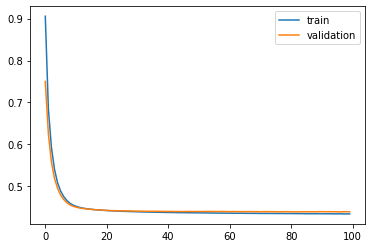

Time to train LSTM:  163.07088446617126
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 48s - loss: 0.8919 - val_loss: 0.7268

Epoch 00001: val_loss improved from inf to 0.72680, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6651 - val_loss: 0.6201

Epoch 00002: val_loss improved from 0.72680 to 0.62015, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5863 - val_loss: 0.5631

Epoch 00003: val_loss improved from 0.62015 to 0.56313, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5416 - val_loss: 0.5285

Epoch 00004: val_loss improved from 0.56313 to 0.52846, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.5136 - val_loss: 0.5065

Epoch 00005: val_loss improved from 0.52846 to 0.50655, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4948 - val_loss: 0.4914

Epoch 00006: val_loss improved from 0.50655 to 0.49140, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4818 - val_loss: 0.4808

Epo


Epoch 00063: val_loss did not improve from 0.44463
Epoch 64/100
 - 1s - loss: 0.4350 - val_loss: 0.4447

Epoch 00064: val_loss did not improve from 0.44463
Epoch 65/100
 - 1s - loss: 0.4351 - val_loss: 0.4451

Epoch 00065: val_loss did not improve from 0.44463
Epoch 66/100
 - 1s - loss: 0.4350 - val_loss: 0.4448

Epoch 00066: val_loss did not improve from 0.44463
Epoch 67/100
 - 1s - loss: 0.4350 - val_loss: 0.4451

Epoch 00067: val_loss did not improve from 0.44463
Epoch 68/100
 - 1s - loss: 0.4350 - val_loss: 0.4451

Epoch 00068: val_loss did not improve from 0.44463
Epoch 69/100
 - 1s - loss: 0.4349 - val_loss: 0.4454

Epoch 00069: val_loss did not improve from 0.44463
Epoch 70/100
 - 1s - loss: 0.4349 - val_loss: 0.4449

Epoch 00070: val_loss did not improve from 0.44463
Epoch 71/100
 - 1s - loss: 0.4348 - val_loss: 0.4452

Epoch 00071: val_loss did not improve from 0.44463
Epoch 72/100
 - 1s - loss: 0.4348 - val_loss: 0.4451

Epoch 00072: val_loss did not improve from 0.44463
Epo

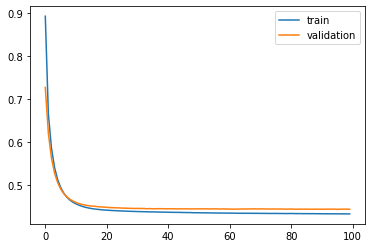

Time to train LSTM:  161.9042239189148
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 48s - loss: 0.9344 - val_loss: 0.7602

Epoch 00001: val_loss improved from inf to 0.76019, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.6918 - val_loss: 0.6247

Epoch 00002: val_loss improved from 0.76019 to 0.62472, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.5935 - val_loss: 0.5565

Epoch 00003: val_loss improved from 0.62472 to 0.55646, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5418 - val_loss: 0.5177

Epoch 00004: val_loss improved from 0.55646 to 0.51766, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5118 - val_loss: 0.4951

Epoch 00005: val_loss improved from 0.51766 to 0.49509, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4931 - val_loss: 0.4805

Epoch 00006: val_loss improved from 0.49509 to 0.48050, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4804 - val_loss: 0.4705

Epoc

 - 1s - loss: 0.4367 - val_loss: 0.4392

Epoch 00067: val_loss did not improve from 0.43882
Epoch 68/100
 - 1s - loss: 0.4367 - val_loss: 0.4390

Epoch 00068: val_loss did not improve from 0.43882
Epoch 69/100
 - 1s - loss: 0.4366 - val_loss: 0.4387

Epoch 00069: val_loss improved from 0.43882 to 0.43871, saving model to val_weights4.hdf5
Epoch 70/100
 - 1s - loss: 0.4365 - val_loss: 0.4390

Epoch 00070: val_loss did not improve from 0.43871
Epoch 71/100
 - 1s - loss: 0.4364 - val_loss: 0.4387

Epoch 00071: val_loss did not improve from 0.43871
Epoch 72/100
 - 1s - loss: 0.4363 - val_loss: 0.4391

Epoch 00072: val_loss did not improve from 0.43871
Epoch 73/100
 - 1s - loss: 0.4363 - val_loss: 0.4389

Epoch 00073: val_loss did not improve from 0.43871
Epoch 74/100
 - 1s - loss: 0.4362 - val_loss: 0.4391

Epoch 00074: val_loss did not improve from 0.43871
Epoch 75/100
 - 1s - loss: 0.4362 - val_loss: 0.4390

Epoch 00075: val_loss did not improve from 0.43871
Epoch 76/100
 - 1s - loss: 0.

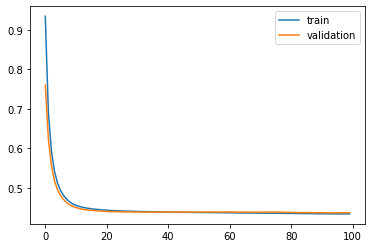

Time to train LSTM:  162.6088728904724
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 49s - loss: 0.9119 - val_loss: 0.7434

Epoch 00001: val_loss improved from inf to 0.74339, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6665 - val_loss: 0.6058

Epoch 00002: val_loss improved from 0.74339 to 0.60583, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5733 - val_loss: 0.5469

Epoch 00003: val_loss improved from 0.60583 to 0.54689, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5285 - val_loss: 0.5148

Epoch 00004: val_loss improved from 0.54689 to 0.51482, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5026 - val_loss: 0.4952

Epoch 00005: val_loss improved from 0.51482 to 0.49522, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4860 - val_loss: 0.4818

Epoch 00006: val_loss improved from 0.49522 to 0.48184, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4741 - val_loss: 0.4722

Epoc

 - 1s - loss: 0.4362 - val_loss: 0.4459

Epoch 00067: val_loss did not improve from 0.44550
Epoch 68/100
 - 1s - loss: 0.4362 - val_loss: 0.4458

Epoch 00068: val_loss did not improve from 0.44550
Epoch 69/100
 - 1s - loss: 0.4361 - val_loss: 0.4463

Epoch 00069: val_loss did not improve from 0.44550
Epoch 70/100
 - 1s - loss: 0.4360 - val_loss: 0.4460

Epoch 00070: val_loss did not improve from 0.44550
Epoch 71/100
 - 1s - loss: 0.4360 - val_loss: 0.4460

Epoch 00071: val_loss did not improve from 0.44550
Epoch 72/100
 - 1s - loss: 0.4359 - val_loss: 0.4460

Epoch 00072: val_loss did not improve from 0.44550
Epoch 73/100
 - 1s - loss: 0.4358 - val_loss: 0.4464

Epoch 00073: val_loss did not improve from 0.44550
Epoch 74/100
 - 1s - loss: 0.4357 - val_loss: 0.4459

Epoch 00074: val_loss did not improve from 0.44550
Epoch 75/100
 - 1s - loss: 0.4355 - val_loss: 0.4463

Epoch 00075: val_loss did not improve from 0.44550
Epoch 76/100
 - 1s - loss: 0.4356 - val_loss: 0.4463

Epoch 00076: v

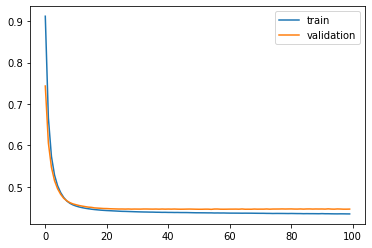

Time to train LSTM:  162.05835890769958


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f8c0bf015c0>>
Traceback (most recent call last):
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/whsu014/.conda/envs/whsuphd/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 52s - loss: 0.8485 - val_loss: 0.7067

Epoch 00001: val_loss improved from inf to 0.70666, saving model to val_weights1.hdf5
Epoch 2/100
 - 1s - loss: 0.6416 - val_loss: 0.5881

Epoch 00002: val_loss improved from 0.70666 to 0.58812, saving model to val_weights1.hdf5
Epoch 3/100
 - 1s - loss: 0.5602 - val_loss: 0.5336

Epoch 00003: val_loss improved from 0.58812 to 0.53357, saving model to val_weights1.hdf5
Epoch 4/100
 - 1s - loss: 0.5185 - val_loss: 0.5020

Epoch 00004: val_loss improved from 0.53357 to 0.50200, saving model to val_weights1.hdf5
Epoch 5/100
 - 1s - loss: 0.4938 - val_loss: 0.4827

Epoch 00005: val_loss improved from 0.50200 to 0.48273, saving model to val_weights1.hdf5
Epoch 6/100
 - 1s - loss: 0.4782 - val_loss: 0.4712

Epoch 00006: val_loss improved from 0.48273 to 0.47122, saving model to val_weights1.hdf5
Epoch 7/100
 - 1s - loss: 0.4683 - val_loss: 0.4639

Epoch 00007: val_loss improved from 0.47122


Epoch 00066: val_loss improved from 0.44077 to 0.44071, saving model to val_weights1.hdf5
Epoch 67/100
 - 1s - loss: 0.4370 - val_loss: 0.4407

Epoch 00067: val_loss did not improve from 0.44071
Epoch 68/100
 - 1s - loss: 0.4369 - val_loss: 0.4409

Epoch 00068: val_loss did not improve from 0.44071
Epoch 69/100
 - 1s - loss: 0.4369 - val_loss: 0.4411

Epoch 00069: val_loss did not improve from 0.44071
Epoch 70/100
 - 1s - loss: 0.4368 - val_loss: 0.4412

Epoch 00070: val_loss did not improve from 0.44071
Epoch 71/100
 - 1s - loss: 0.4368 - val_loss: 0.4406

Epoch 00071: val_loss improved from 0.44071 to 0.44059, saving model to val_weights1.hdf5
Epoch 72/100
 - 1s - loss: 0.4369 - val_loss: 0.4413

Epoch 00072: val_loss did not improve from 0.44059
Epoch 73/100
 - 1s - loss: 0.4369 - val_loss: 0.4410

Epoch 00073: val_loss did not improve from 0.44059
Epoch 74/100
 - 1s - loss: 0.4366 - val_loss: 0.4407

Epoch 00074: val_loss did not improve from 0.44059
Epoch 75/100
 - 1s - loss: 0.4

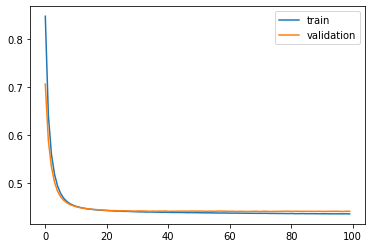

Time to train LSTM:  167.33568143844604
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 49s - loss: 0.8480 - val_loss: 0.7131

Epoch 00001: val_loss improved from inf to 0.71307, saving model to val_weights2.hdf5
Epoch 2/100
 - 1s - loss: 0.6395 - val_loss: 0.5810

Epoch 00002: val_loss improved from 0.71307 to 0.58097, saving model to val_weights2.hdf5
Epoch 3/100
 - 1s - loss: 0.5533 - val_loss: 0.5257

Epoch 00003: val_loss improved from 0.58097 to 0.52566, saving model to val_weights2.hdf5
Epoch 4/100
 - 1s - loss: 0.5125 - val_loss: 0.4963

Epoch 00004: val_loss improved from 0.52566 to 0.49625, saving model to val_weights2.hdf5
Epoch 5/100
 - 1s - loss: 0.4891 - val_loss: 0.4778

Epoch 00005: val_loss improved from 0.49625 to 0.47780, saving model to val_weights2.hdf5
Epoch 6/100
 - 1s - loss: 0.4738 - val_loss: 0.4664

Epoch 00006: val_loss improved from 0.47780 to 0.46635, saving model to val_weights2.hdf5
Epoch 7/100
 - 1s - loss: 0.4642 - val_loss: 0.4589

Epo

 - 1s - loss: 0.4364 - val_loss: 0.4410

Epoch 00066: val_loss did not improve from 0.44020
Epoch 67/100
 - 1s - loss: 0.4364 - val_loss: 0.4407

Epoch 00067: val_loss did not improve from 0.44020
Epoch 68/100
 - 1s - loss: 0.4362 - val_loss: 0.4406

Epoch 00068: val_loss did not improve from 0.44020
Epoch 69/100
 - 1s - loss: 0.4362 - val_loss: 0.4402

Epoch 00069: val_loss did not improve from 0.44020
Epoch 70/100
 - 1s - loss: 0.4361 - val_loss: 0.4406

Epoch 00070: val_loss did not improve from 0.44020
Epoch 71/100
 - 1s - loss: 0.4361 - val_loss: 0.4401

Epoch 00071: val_loss improved from 0.44020 to 0.44013, saving model to val_weights2.hdf5
Epoch 72/100
 - 1s - loss: 0.4360 - val_loss: 0.4405

Epoch 00072: val_loss did not improve from 0.44013
Epoch 73/100
 - 1s - loss: 0.4359 - val_loss: 0.4402

Epoch 00073: val_loss did not improve from 0.44013
Epoch 74/100
 - 1s - loss: 0.4358 - val_loss: 0.4405

Epoch 00074: val_loss did not improve from 0.44013
Epoch 75/100
 - 1s - loss: 0.

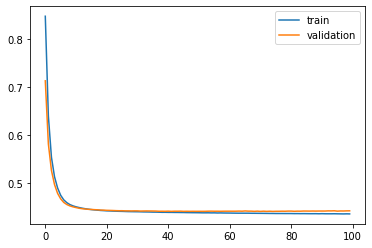

Time to train LSTM:  163.23133373260498
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 50s - loss: 0.8827 - val_loss: 0.7392

Epoch 00001: val_loss improved from inf to 0.73917, saving model to val_weights3.hdf5
Epoch 2/100
 - 1s - loss: 0.6631 - val_loss: 0.6073

Epoch 00002: val_loss improved from 0.73917 to 0.60726, saving model to val_weights3.hdf5
Epoch 3/100
 - 1s - loss: 0.5667 - val_loss: 0.5438

Epoch 00003: val_loss improved from 0.60726 to 0.54378, saving model to val_weights3.hdf5
Epoch 4/100
 - 1s - loss: 0.5190 - val_loss: 0.5095

Epoch 00004: val_loss improved from 0.54378 to 0.50950, saving model to val_weights3.hdf5
Epoch 5/100
 - 1s - loss: 0.4928 - val_loss: 0.4895

Epoch 00005: val_loss improved from 0.50950 to 0.48952, saving model to val_weights3.hdf5
Epoch 6/100
 - 1s - loss: 0.4771 - val_loss: 0.4769

Epoch 00006: val_loss improved from 0.48952 to 0.47695, saving model to val_weights3.hdf5
Epoch 7/100
 - 1s - loss: 0.4667 - val_loss: 0.4682

Epo

 - 1s - loss: 0.4356 - val_loss: 0.4458

Epoch 00064: val_loss did not improve from 0.44560
Epoch 65/100
 - 1s - loss: 0.4356 - val_loss: 0.4456

Epoch 00065: val_loss did not improve from 0.44560
Epoch 66/100
 - 1s - loss: 0.4356 - val_loss: 0.4457

Epoch 00066: val_loss did not improve from 0.44560
Epoch 67/100
 - 1s - loss: 0.4354 - val_loss: 0.4459

Epoch 00067: val_loss did not improve from 0.44560
Epoch 68/100
 - 1s - loss: 0.4355 - val_loss: 0.4455

Epoch 00068: val_loss improved from 0.44560 to 0.44551, saving model to val_weights3.hdf5
Epoch 69/100
 - 1s - loss: 0.4354 - val_loss: 0.4458

Epoch 00069: val_loss did not improve from 0.44551
Epoch 70/100
 - 1s - loss: 0.4353 - val_loss: 0.4457

Epoch 00070: val_loss did not improve from 0.44551
Epoch 71/100
 - 1s - loss: 0.4352 - val_loss: 0.4458

Epoch 00071: val_loss did not improve from 0.44551
Epoch 72/100
 - 1s - loss: 0.4351 - val_loss: 0.4458

Epoch 00072: val_loss did not improve from 0.44551
Epoch 73/100
 - 1s - loss: 0.

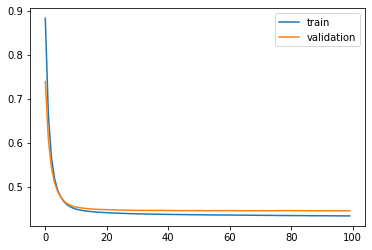

Time to train LSTM:  165.18716621398926
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 50s - loss: 1.0192 - val_loss: 0.8058

Epoch 00001: val_loss improved from inf to 0.80585, saving model to val_weights4.hdf5
Epoch 2/100
 - 1s - loss: 0.7212 - val_loss: 0.6391

Epoch 00002: val_loss improved from 0.80585 to 0.63914, saving model to val_weights4.hdf5
Epoch 3/100
 - 1s - loss: 0.6014 - val_loss: 0.5619

Epoch 00003: val_loss improved from 0.63914 to 0.56190, saving model to val_weights4.hdf5
Epoch 4/100
 - 1s - loss: 0.5454 - val_loss: 0.5215

Epoch 00004: val_loss improved from 0.56190 to 0.52146, saving model to val_weights4.hdf5
Epoch 5/100
 - 1s - loss: 0.5137 - val_loss: 0.4969

Epoch 00005: val_loss improved from 0.52146 to 0.49695, saving model to val_weights4.hdf5
Epoch 6/100
 - 1s - loss: 0.4940 - val_loss: 0.4805

Epoch 00006: val_loss improved from 0.49695 to 0.48055, saving model to val_weights4.hdf5
Epoch 7/100
 - 1s - loss: 0.4807 - val_loss: 0.4690

Epo


Epoch 00063: val_loss did not improve from 0.43761
Epoch 64/100
 - 1s - loss: 0.4368 - val_loss: 0.4378

Epoch 00064: val_loss did not improve from 0.43761
Epoch 65/100
 - 1s - loss: 0.4369 - val_loss: 0.4379

Epoch 00065: val_loss did not improve from 0.43761
Epoch 66/100
 - 1s - loss: 0.4367 - val_loss: 0.4379

Epoch 00066: val_loss did not improve from 0.43761
Epoch 67/100
 - 1s - loss: 0.4366 - val_loss: 0.4378

Epoch 00067: val_loss did not improve from 0.43761
Epoch 68/100
 - 1s - loss: 0.4365 - val_loss: 0.4380

Epoch 00068: val_loss did not improve from 0.43761
Epoch 69/100
 - 1s - loss: 0.4364 - val_loss: 0.4379

Epoch 00069: val_loss did not improve from 0.43761
Epoch 70/100
 - 1s - loss: 0.4364 - val_loss: 0.4381

Epoch 00070: val_loss did not improve from 0.43761
Epoch 71/100
 - 1s - loss: 0.4363 - val_loss: 0.4381

Epoch 00071: val_loss did not improve from 0.43761
Epoch 72/100
 - 1s - loss: 0.4362 - val_loss: 0.4380

Epoch 00072: val_loss did not improve from 0.43761
Epo

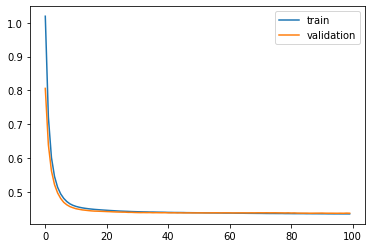

Time to train LSTM:  165.1837866306305
Train on 81000 samples, validate on 9000 samples
Epoch 1/100
 - 54s - loss: 0.9383 - val_loss: 0.7716

Epoch 00001: val_loss improved from inf to 0.77163, saving model to val_weights5.hdf5
Epoch 2/100
 - 1s - loss: 0.6963 - val_loss: 0.6309

Epoch 00002: val_loss improved from 0.77163 to 0.63094, saving model to val_weights5.hdf5
Epoch 3/100
 - 1s - loss: 0.5931 - val_loss: 0.5626

Epoch 00003: val_loss improved from 0.63094 to 0.56261, saving model to val_weights5.hdf5
Epoch 4/100
 - 1s - loss: 0.5401 - val_loss: 0.5243

Epoch 00004: val_loss improved from 0.56261 to 0.52426, saving model to val_weights5.hdf5
Epoch 5/100
 - 1s - loss: 0.5093 - val_loss: 0.5011

Epoch 00005: val_loss improved from 0.52426 to 0.50109, saving model to val_weights5.hdf5
Epoch 6/100
 - 1s - loss: 0.4898 - val_loss: 0.4857

Epoch 00006: val_loss improved from 0.50109 to 0.48571, saving model to val_weights5.hdf5
Epoch 7/100
 - 1s - loss: 0.4764 - val_loss: 0.4752

Epoc

 - 1s - loss: 0.4359 - val_loss: 0.4433

Epoch 00060: val_loss improved from 0.44329 to 0.44326, saving model to val_weights5.hdf5
Epoch 61/100
 - 1s - loss: 0.4359 - val_loss: 0.4432

Epoch 00061: val_loss improved from 0.44326 to 0.44315, saving model to val_weights5.hdf5
Epoch 62/100
 - 1s - loss: 0.4358 - val_loss: 0.4430

Epoch 00062: val_loss improved from 0.44315 to 0.44303, saving model to val_weights5.hdf5
Epoch 63/100
 - 1s - loss: 0.4357 - val_loss: 0.4434

Epoch 00063: val_loss did not improve from 0.44303
Epoch 64/100
 - 1s - loss: 0.4356 - val_loss: 0.4432

Epoch 00064: val_loss did not improve from 0.44303
Epoch 65/100
 - 1s - loss: 0.4356 - val_loss: 0.4432

Epoch 00065: val_loss did not improve from 0.44303
Epoch 66/100
 - 1s - loss: 0.4355 - val_loss: 0.4432

Epoch 00066: val_loss did not improve from 0.44303
Epoch 67/100
 - 1s - loss: 0.4354 - val_loss: 0.4431

Epoch 00067: val_loss did not improve from 0.44303
Epoch 68/100
 - 1s - loss: 0.4354 - val_loss: 0.4431

Ep

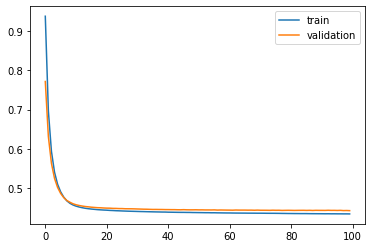

Time to train LSTM:  171.26766777038574
Entire process took:  16566.209816217422
Experiment record:
[[16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 0, 0.43987639170222814], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 1, 0.4372662083837721], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 2, 0.44567474529478285], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 3, 0.4382176331943936], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 4, 0.4437246675491333], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 0, 0.43825197784105935], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 1, 0.4412613475587633], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 2, 0.4445653887589773], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 3, 0.43705326456493804], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 4, 0.44568431764178806], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 0, 0.4370287908713023], [16,

In [16]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


num_per_fold = x_train.shape[0]//10
print(num_per_fold)

units = 16
batch_s = 2048

start_time = time.time()

exp_record = []

for i in range(25):
    L2_1 = L2_1_list[i]
    L2_2 = L2_2_list[i]
    for f in range(5):#10
        #start = f*num_per_fold
        end = (f+1)*num_per_fold
        train1_x = x_train[:end, ]
        train2_x = x_train[end:, ]
        train_x_lstm = np.append(train2_x, train1_x, axis=0) #new obj
        train1_y = y_train[:end, ]
        train2_y = y_train[end:, ]
        train_y_lstm = np.append(train2_y, train1_y, axis=0)

        start_time_inner = time.time()
        #config = tf.ConfigProto(log_device_placement = True)
        #config.gpu_options.visible_device_list='1'
        with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
            model = Sequential()
            model.add(SimpleRNN(units, #CuDNNLSTM
                                kernel_regularizer=regularizers.l2(L2_1),
                                input_shape=(8, 182))) #20 , 27
            model.add(RepeatVector(20))
            model.add(SimpleRNN(units, 
                                kernel_regularizer=regularizers.l2(L2_2),
                                return_sequences=True))
            model.add(TimeDistributed(Dense(1)))
            #adam = optimizers.Adam(lr=0.0015) #decay=1e-4
            #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-7) 
            model.compile(loss='mae', optimizer='adam')#'adam'
            #weight = "weightsCuDNNLSTMPDC" + str(f+1) + ".hdf5" #"Test"+str(f+1)+".hdf5" 
            train_weight = "train_weights" + str(f+1) + ".hdf5"
            val_weight = "val_weights" + str(f+1) + ".hdf5"
            #train_checkpointer = ModelCheckpoint(filepath=train_weight,
            #                            monitor='loss', verbose=1,
            #                            save_best_only=True)
            val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                               monitor='val_loss', verbose=1,
                                               save_best_only=True)
            history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                                epochs=100, validation_split=0.1, 
                                callbacks=[val_checkpointer], 
                                verbose=2, 
                                shuffle=False) 
            print("#################################")
            print("Number of units:", units)
            print("Batch size:", batch_s)
            print("L2 Layer 1:", L2_1)
            print("L2 layer 2:", L2_2)
            print("Fold:", f)
            print("best val loss:", min(history.history['val_loss']))
            exp_record.append([units, batch_s, L2_1, L2_2, 
                               f, min(history.history['val_loss'])])
            print("#################################")
            if(f==4):
                print(exp_record)
            pyplot.plot(history.history['loss'], label='train')
            pyplot.plot(history.history['val_loss'], label='validation')
            pyplot.legend()
            pyplot.show()
        print("Time to train LSTM: ", time.time() - start_time_inner)
print("Entire process took: ", time.time() - start_time)

print("Experiment record:")
print(exp_record)

In [3]:
exp_record = [[16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 0, 0.43987639170222814], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 1, 0.4372662083837721], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 2, 0.44567474529478285], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 3, 0.4382176331943936], [16, 2048, 0.0072199317108973945, 2.6505914783975005e-05, 4, 0.4437246675491333], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 0, 0.43825197784105935], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 1, 0.4412613475587633], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 2, 0.4445653887589773], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 3, 0.43705326456493804], [16, 2048, 0.013707323061773764, 2.175447240794305e-05, 4, 0.44568431764178806], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 0, 0.4370287908713023], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 1, 0.4356034419271681], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 2, 0.4436153397030301], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 3, 0.4371352961593204], [16, 2048, 0.007067191553394264, 1.394048500868052e-08, 4, 0.43995901894569395], [16, 2048, 0.014186109079379214, 1.4424246609572321e-08, 0, 0.4406578532324897], [16, 2048, 0.014186109079379214, 1.4424246609572321e-08, 1, 0.439705086045795], [16, 2048, 0.014186109079379214, 1.4424246609572321e-08, 2, 0.4454740773306953], [16, 2048, 0.014186109079379214, 1.4424246609572321e-08, 3, 0.43749323235617743], [16, 2048, 0.014186109079379214, 1.4424246609572321e-08, 4, 0.44406479252709286], [16, 2048, 0.00988411188794829, 1.76336159394718e-05, 0, 0.43967600870132445], [16, 2048, 0.00988411188794829, 1.76336159394718e-05, 1, 0.4375574666923947], [16, 2048, 0.00988411188794829, 1.76336159394718e-05, 2, 0.4432875973648495], [16, 2048, 0.00988411188794829, 1.76336159394718e-05, 3, 0.43852613928582934], [16, 2048, 0.00988411188794829, 1.76336159394718e-05, 4, 0.44378368563122217], [16, 2048, 0.011117438629026456, 7.994176883795366e-05, 0, 0.4403038235770331], [16, 2048, 0.011117438629026456, 7.994176883795366e-05, 1, 0.43844595540894404], [16, 2048, 0.011117438629026456, 7.994176883795366e-05, 2, 0.445364586909612], [16, 2048, 0.011117438629026456, 7.994176883795366e-05, 3, 0.43951839545038013], [16, 2048, 0.011117438629026456, 7.994176883795366e-05, 4, 0.44347371827231513], [16, 2048, 0.012659078564803155, 1.5197698149525386e-05, 0, 0.4389632124370999], [16, 2048, 0.012659078564803155, 1.5197698149525386e-05, 1, 0.43789355521731904], [16, 2048, 0.012659078564803155, 1.5197698149525386e-05, 2, 0.4449456870290968], [16, 2048, 0.012659078564803155, 1.5197698149525386e-05, 3, 0.4393259892993503], [16, 2048, 0.012659078564803155, 1.5197698149525386e-05, 4, 0.44215514890352886], [16, 2048, 0.010184179878729431, 1.5871776653550959e-07, 0, 0.4376873513327705], [16, 2048, 0.010184179878729431, 1.5871776653550959e-07, 1, 0.4378253588941362], [16, 2048, 0.010184179878729431, 1.5871776653550959e-07, 2, 0.44560066604614257], [16, 2048, 0.010184179878729431, 1.5871776653550959e-07, 3, 0.4361002361774445], [16, 2048, 0.010184179878729431, 1.5871776653550959e-07, 4, 0.44239699074957106], [16, 2048, 0.007968005015762218, 7.619766407841797e-08, 0, 0.4387839797867669], [16, 2048, 0.007968005015762218, 7.619766407841797e-08, 1, 0.4384610231982337], [16, 2048, 0.007968005015762218, 7.619766407841797e-08, 2, 0.4412179002232022], [16, 2048, 0.007968005015762218, 7.619766407841797e-08, 3, 0.43853609042697483], [16, 2048, 0.007968005015762218, 7.619766407841797e-08, 4, 0.4427770745754242], [16, 2048, 0.006877212286612516, 8.095946512357794e-05, 0, 0.4381820935673184], [16, 2048, 0.006877212286612516, 8.095946512357794e-05, 1, 0.43952949902746413], [16, 2048, 0.006877212286612516, 8.095946512357794e-05, 2, 0.44545025997691684], [16, 2048, 0.006877212286612516, 8.095946512357794e-05, 3, 0.43585596606466503], [16, 2048, 0.006877212286612516, 8.095946512357794e-05, 4, 0.44271476586659747], [16, 2048, 0.005807412687648748, 4.890447122292986e-07, 0, 0.4381476314862569], [16, 2048, 0.005807412687648748, 4.890447122292986e-07, 1, 0.4370674483511183], [16, 2048, 0.005807412687648748, 4.890447122292986e-07, 2, 0.44570923823780484], [16, 2048, 0.005807412687648748, 4.890447122292986e-07, 3, 0.43508194881015355], [16, 2048, 0.005807412687648748, 4.890447122292986e-07, 4, 0.4406840127574073], [16, 2048, 0.012384402961989699, 9.849888381867553e-05, 0, 0.4410082759062449], [16, 2048, 0.012384402961989699, 9.849888381867553e-05, 1, 0.4400690722200606], [16, 2048, 0.012384402961989699, 9.849888381867553e-05, 2, 0.4448856189250946], [16, 2048, 0.012384402961989699, 9.849888381867553e-05, 3, 0.4376023993757036], [16, 2048, 0.012384402961989699, 9.849888381867553e-05, 4, 0.44444473796420625], [16, 2048, 0.00941309222895953, 8.671805976616734e-07, 0, 0.43868642701043026], [16, 2048, 0.00941309222895953, 8.671805976616734e-07, 1, 0.4390277277363671], [16, 2048, 0.00941309222895953, 8.671805976616734e-07, 2, 0.44213965084817675], [16, 2048, 0.00941309222895953, 8.671805976616734e-07, 3, 0.43526953853501216], [16, 2048, 0.00941309222895953, 8.671805976616734e-07, 4, 0.43969774881998697], [16, 2048, 0.006583098677126512, 2.7594294531006584e-07, 0, 0.43899713712268407], [16, 2048, 0.006583098677126512, 2.7594294531006584e-07, 1, 0.4369435025321113], [16, 2048, 0.006583098677126512, 2.7594294531006584e-07, 2, 0.44313219968477885], [16, 2048, 0.006583098677126512, 2.7594294531006584e-07, 3, 0.438609069665273], [16, 2048, 0.006583098677126512, 2.7594294531006584e-07, 4, 0.4377903198136224], [16, 2048, 0.013799370312012789, 1.1415695836643046e-08, 0, 0.439318780236774], [16, 2048, 0.013799370312012789, 1.1415695836643046e-08, 1, 0.4387027692000071], [16, 2048, 0.013799370312012789, 1.1415695836643046e-08, 2, 0.44380646816889446], [16, 2048, 0.013799370312012789, 1.1415695836643046e-08, 3, 0.4374601412349277], [16, 2048, 0.013799370312012789, 1.1415695836643046e-08, 4, 0.44548241239123876], [16, 2048, 0.0077408646199222456, 9.196225549195255e-06, 0, 0.43699439001083373], [16, 2048, 0.0077408646199222456, 9.196225549195255e-06, 1, 0.43755446897612676], [16, 2048, 0.0077408646199222456, 9.196225549195255e-06, 2, 0.44279596887694467], [16, 2048, 0.0077408646199222456, 9.196225549195255e-06, 3, 0.43901391265127393], [16, 2048, 0.0077408646199222456, 9.196225549195255e-06, 4, 0.4427731762727102], [16, 2048, 0.009142350190810514, 6.16612690862605e-08, 0, 0.4408895714812809], [16, 2048, 0.009142350190810514, 6.16612690862605e-08, 1, 0.4382351215415531], [16, 2048, 0.009142350190810514, 6.16612690862605e-08, 2, 0.44594515622986686], [16, 2048, 0.009142350190810514, 6.16612690862605e-08, 3, 0.435372636185752], [16, 2048, 0.009142350190810514, 6.16612690862605e-08, 4, 0.44246232101652355], [16, 2048, 0.007960799327336478, 3.296610609559953e-08, 0, 0.4395313114060296], [16, 2048, 0.007960799327336478, 3.296610609559953e-08, 1, 0.4391650662951999], [16, 2048, 0.007960799327336478, 3.296610609559953e-08, 2, 0.44466319449742636], [16, 2048, 0.007960799327336478, 3.296610609559953e-08, 3, 0.43742344273461237], [16, 2048, 0.007960799327336478, 3.296610609559953e-08, 4, 0.442944985654619], [16, 2048, 0.011287879088794833, 2.0370493208123712e-08, 0, 0.4371966403855218], [16, 2048, 0.011287879088794833, 2.0370493208123712e-08, 1, 0.4388853307035234], [16, 2048, 0.011287879088794833, 2.0370493208123712e-08, 2, 0.44356264967388576], [16, 2048, 0.011287879088794833, 2.0370493208123712e-08, 3, 0.43808883494800993], [16, 2048, 0.011287879088794833, 2.0370493208123712e-08, 4, 0.44284712062941656], [16, 2048, 0.01079837810189545, 9.798128929770903e-05, 0, 0.43880624832047355], [16, 2048, 0.01079837810189545, 9.798128929770903e-05, 1, 0.43947855660650464], [16, 2048, 0.01079837810189545, 9.798128929770903e-05, 2, 0.4431697980297936], [16, 2048, 0.01079837810189545, 9.798128929770903e-05, 3, 0.4400676459206475], [16, 2048, 0.01079837810189545, 9.798128929770903e-05, 4, 0.4425410390959846], [16, 2048, 0.010999291966249875, 1.3244833798622884e-06, 0, 0.43971068575647143], [16, 2048, 0.010999291966249875, 1.3244833798622884e-06, 1, 0.4383146397272746], [16, 2048, 0.010999291966249875, 1.3244833798622884e-06, 2, 0.44328271725442675], [16, 2048, 0.010999291966249875, 1.3244833798622884e-06, 3, 0.43761374547746446], [16, 2048, 0.010999291966249875, 1.3244833798622884e-06, 4, 0.443668400393592], [16, 2048, 0.007658191175355072, 1.186110224365971e-08, 0, 0.4398632729053497], [16, 2048, 0.007658191175355072, 1.186110224365971e-08, 1, 0.43738905567593045], [16, 2048, 0.007658191175355072, 1.186110224365971e-08, 2, 0.44576165662871464], [16, 2048, 0.007658191175355072, 1.186110224365971e-08, 3, 0.4378464745415582], [16, 2048, 0.007658191175355072, 1.186110224365971e-08, 4, 0.44302025604248046], [16, 2048, 0.007846858806413637, 2.5364177537659193e-06, 0, 0.4387321456803216], [16, 2048, 0.007846858806413637, 2.5364177537659193e-06, 1, 0.43734468303786384], [16, 2048, 0.007846858806413637, 2.5364177537659193e-06, 2, 0.441458276324802], [16, 2048, 0.007846858806413637, 2.5364177537659193e-06, 3, 0.4372600283357832], [16, 2048, 0.007846858806413637, 2.5364177537659193e-06, 4, 0.44375060955683393], [16, 2048, 0.007535882057737874, 5.559939804467083e-08, 0, 0.4395619704458449], [16, 2048, 0.007535882057737874, 5.559939804467083e-08, 1, 0.43922205209732057], [16, 2048, 0.007535882057737874, 5.559939804467083e-08, 2, 0.4441011519961887], [16, 2048, 0.007535882057737874, 5.559939804467083e-08, 3, 0.43708597948816086], [16, 2048, 0.007535882057737874, 5.559939804467083e-08, 4, 0.44549679785304597], [16, 2048, 0.00827563947688734, 6.518895333308883e-07, 0, 0.4405926344394684], [16, 2048, 0.00827563947688734, 6.518895333308883e-07, 1, 0.44012760474946766], [16, 2048, 0.00827563947688734, 6.518895333308883e-07, 2, 0.44528878890143503], [16, 2048, 0.00827563947688734, 6.518895333308883e-07, 3, 0.43668930096096464], [16, 2048, 0.00827563947688734, 6.518895333308883e-07, 4, 0.44187380978796215]]
#print(exp_record)
complete_v = np.array(exp_record)
print(complete_v.shape)
print(min(complete_v[:, 5]))

(125, 6)
0.43508194881015355


In [4]:
x = np.array([4,8,16,32,64])
y = np.array([64,128,256,512,1024])
complete_list = [[0.45296,0.45168,0.45208,0.45476,0.45669],
                 [0.44948,0.44763,0.44831,0.45019,0.45222],
                 [0.44769,0.44617,0.44644,0.44724,0.44933],
                 [0.44699,0.44449,0.44464,0.4455,0.44846],
                 [0.44757,0.44507,0.44461,0.44634,0.44817]]
X,Y = np.meshgrid(x, y)
print(X)
print(Y)
print(np.round(complete_list, decimals=5))

[[ 4  8 16 32 64]
 [ 4  8 16 32 64]
 [ 4  8 16 32 64]
 [ 4  8 16 32 64]
 [ 4  8 16 32 64]]
[[  64   64   64   64   64]
 [ 128  128  128  128  128]
 [ 256  256  256  256  256]
 [ 512  512  512  512  512]
 [1024 1024 1024 1024 1024]]
[[0.45296 0.45168 0.45208 0.45476 0.45669]
 [0.44948 0.44763 0.44831 0.45019 0.45222]
 [0.44769 0.44617 0.44644 0.44724 0.44933]
 [0.44699 0.44449 0.44464 0.4455  0.44846]
 [0.44757 0.44507 0.44461 0.44634 0.44817]]


(5, 5)
(5, 5)
(5, 5)


<IPython.core.display.Javascript object>


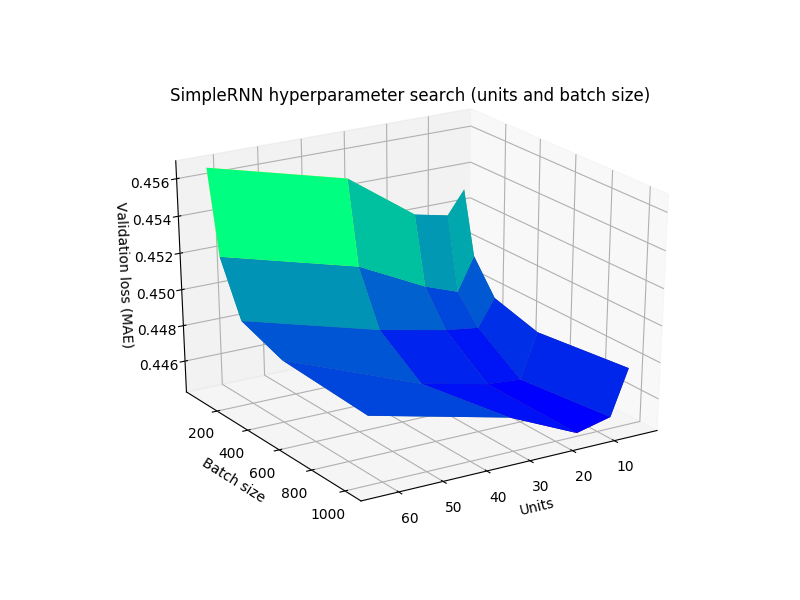

In [8]:
%matplotlib notebook
from mpl_toolkits.mplot3d import axes3d    
from mpl_toolkits import mplot3d

x = np.array([4,8,16,32,64])
y = np.array([64,128,256,512,1024])
X,Y = np.meshgrid(x, y)
z = np.array(complete_list)
print(X.shape)
print(Y.shape)
print(z.shape)
fig = pyplot.figure(figsize=(8, 6))
ax = pyplot.axes(projection='3d')
ax.plot_surface(X, Y, z,cmap='viridis', edgecolor='none')
#ax.plot_wireframe(X, Y, z, color='g')
ax.set_xlabel('Units')
ax.set_ylabel('Batch size')
ax.set_zlabel('Validation loss (MAE)')
#ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z, rstride=1, cstride=1,
                cmap='winter', edgecolor='none')
ax.set_title('SimpleRNN hyperparameter search (units and batch size)')
pyplot.show()

## Stop here